## Functions

In [0]:
%pip install lifelines xgboost

Looking in indexes: https://artifactory.us.caas.oneadp.com/artifactory/api/pypi/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/349.3 kB ? eta -:--:--
     ━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/349.3 kB 3.0 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━ 307.2/349.3 kB 4.8 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/253.9 MB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/253.9 MB 3.5 MB/s eta 0:01:14
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.5/253.9 MB 7.3 MB/s eta 0:00:35
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/253.9 MB 17.0 MB/s eta 0:00:15
     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/253.9 MB 43.2 MB/s eta 0:00:06
     ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/253.9 MB 53.6 MB/s eta 0:00:05
     ━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/253.9 MB 107.6 MB/s eta 0:00:03
     ━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━

In [0]:
dbutils.library.restartPython()

In [0]:

# Load base datasets
df = spark.table("onedata_us_east_1_shared_prod.datacloud_raw_oneai_turnoverprobability_prod.zenon_employee_features_comprehensive")
from pyspark.sql import functions as F
df1 = (df
                #  .filter(F.col("person_composite_id").isin(sample_list))
                 .filter(F.col("work_loc_cntry_cd").isin(["USA", "CAN"]))
                 .filter(~F.col("mngr_pers_obj_id").isin(["UNKNOWN", "ONE", "", "0"]))
                 .filter(F.col("dataset_split").isin(["train", "val"]))
                 )

DataFrame[reg_temp_cd: string, pers_clsfn_cd: string, min_salary_to_date: double, manager_changes_count: bigint, promotion_velocity: double, is_fscl_client: string, company_layoff_indicator: int, work_asgnmt_stus_cd: string, career_stage: string, clnt_live_ind: string, full_tm_eqv_val: double, team_avg_tnur_days: double, job_dsc: string, mnthly_cmpn_amt: double, sal_admin_plan_cd: string, ftm_ptm_cd: string, compa_rt: double, term_type_cd: string, mngr_lvl: smallint, mngr_lvl_cd: string, distinct_assignments_count: bigint, tnur_dt: date, tenure_in_current_role: int, team_size: bigint, decision_making_authority_indicator: string, hr_cmpn_freq_cd: string, Region: string, state_prov_nm: string, rev_range_band_ky: bigint, fiscal_year_effect: int, sal_grd_cd: string, full_tm_part_tm_cd: string, work_loc_cd: string, pay_grp_cd: string, survival_time_days: int, cmpny_cd: string, annl_cmpn_amt: double, retirement_eligibility_years: double, pay_frequency_preference: int, prmry_job_titl_confdnc_

In [0]:
required_cols = ['survival_time_days', 'event_indicator_all', 'dataset_split'] # must be present #time to event, event occurred (1) or censored (0), train/val/oot split identifier
analysis_cols = ['birth_dt', 'vantage_date', 'naics_cd', 'person_composite_id']
feature_columns = ['baseline_salary','salary_growth_rate_12m','compensation_percentile_company','compensation_percentile_industry',
                   'pay_grade_stagnation_months','compensation_volatility', 'time_since_last_promotion','promotion_velocity','age_at_vantage', 'role_complexity_score','time_with_current_manager','team_size','team_avg_tnur_days',
                   'team_avg_comp','peer_salary_ratio','tenure_at_vantage_days','tenure_in_current_role','company_tenure_percentile','assignment_frequency_12m','work_location_changes_count',
                   'career_stage','pay_rate_type_cd', 'generation_cohort','gender_cd', 'hire_date_seasonality',              'full_tm_part_tm_cd','reg_temp_cd','flsa_stus_cd','fscl_actv_ind','company_size_tier'
                   ]
final_cols = list(set(required_cols + analysis_cols + feature_columns))

# data = df.sample(withReplacement=False, fraction=100000/df.count(), seed=42).toPandas()

# data = df.toPandas()
#data = df.select(*final_cols).toPandas()
data = df.sample(withReplacement=False, fraction=500000/df.count(), seed=42).select(*final_cols).toPandas()
data.describe()

time_with_current_manager  ...  pay_grade_stagnation_months
count              501175.000000  ...                501175.000000
mean                  887.298291  ...                     4.609800
std                  1601.742932  ...                     8.163019
min                     0.000000  ...                     0.000000
25%                   132.000000  ...                     0.000000
50%                   377.000000  ...                     2.096774
75%                   973.000000  ...                     8.000000
max                 44925.000000  ...                   441.387097

[8 rows x 22 columns]

In [0]:
def cap_outlier_iqr(df, cols):
    df_capped = df.copy()
    for col in cols:
        if df_capped[col].dtype in ['int64', 'float64','int32']:
            #print("creating capped column")
            q1 = df_capped[col].quantile(0.25)
            q3 = df_capped[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            df_capped[col+'_cap'] = df_capped[col].clip(lower_bound, upper_bound)
    return df_capped

def cap_outlier_log_iqr(df, cols):
    df_capped = df.copy()
    for col in cols:
        if df_capped[col].dtype in ['int64', 'float64','int32']:
            #print("creating capped column")
            df_capped[col+'_log']=np.log1p(df_capped[col])
            q1 = df_capped[col+'_log'].quantile(0.25)
            q3 = df_capped[col+'_log'].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            df_capped[col+'_log_cap'] = df_capped[col+'_log'].clip(lower_bound, upper_bound)
    return df_capped

def winsorize(df, cols):
    df_capped = df.copy()
    for col in cols:
        if df_capped[col].dtype in ['int64', 'float64','int32']:
            #print("creating capped column")
            q1=df_capped[col].quantile(0.01) 
            q99 = df_capped[col].quantile(0.99)
            df_capped[col+'_win_cap'] = df_capped[col].clip(q1, q99)
    return df_capped

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
feature_cols=['baseline_salary','salary_growth_rate_12m','peer_salary_ratio','compensation_volatility',
              'compensation_percentile_company','team_avg_comp','company_tenure_percentile','age_at_vantage','tenure_at_vantage_days',
              'time_with_current_manager','tenure_in_current_role','time_since_last_promotion',#'promotion_velocity'
              'pay_grade_stagnation_months','team_size','work_location_changes_count','role_complexity_score','assignment_frequency_12m',
              'team_avg_tnur_days']
data = cap_outlier_iqr(data,feature_cols)
data = cap_outlier_log_iqr(data,feature_cols)
data = winsorize(data,feature_cols)


/databricks/python/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [0]:
['company_tenure_percentile','compensation_percentile_company','team_avg_tnur_days_win_cap','role_complexity_score_log','team_size_log','tenure_in_current_role_log','tenure_at_vantage_days_log','team_avg_comp_win_cap','peer_salary_ratio_win_cap','baseline_salary_win_cap','salary_growth_rate_12m_win_cap','pay_grade_stagnation_months_cap','compensation_volatility_log','age_at_vantage_win_cap','time_with_current_manager_log']

In [0]:
# Enhanced XGBoost AFT Survival Analysis
# Advanced implementation with proper AFT handling and comprehensive insights

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
import xgboost as xgb
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from scipy import stats, interpolate
from typing import Dict, List, Tuple, Optional, Union
import warnings
from dataclasses import dataclass
from enum import Enum

warnings.filterwarnings("ignore")

plt.style.use("default")
sns.set_palette("Set2")
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.size"] = 11

class AFTDistribution(Enum):
    NORMAL = "normal"
    LOGISTIC = "logistic"
    EXTREME = "extreme"

@dataclass
class AFTParameters:
    eta: np.ndarray
    sigma: float
    distribution: AFTDistribution

FEATURE_SCALING_CONFIG = {
    'robust_scale': [ ],
    'log_transform': [],
    'clip_and_scale': {
        'age': (10, 130),
        'tenure_at_vantage_days': (0, 36500),
        'team_size': (1, 1000)
    },
    'no_scale': ['gender_cd_encoded', 'naics_encoded', 'fscl_actv_ind_encoded', 'pay_rt_type_cd_encoded',
                 'full_tm_part_tm_cd_encoded']
}

class EnhancedSurvivalAnalysis:
    """
    Advanced XGBoost AFT survival analysis with comprehensive insights and proper implementation
    """
    
    def __init__(self, data: pd.DataFrame, aft_distribution: AFTDistribution = AFTDistribution.NORMAL):
        self.data = self._prepare_data(data)
        self.aft_distribution = aft_distribution
        self.kmf = KaplanMeierFitter()
        self.insights = {}
        self.enhanced_results = {}
        self.model_parameters = None
        self.survival_curves = None
        self.calibration_metrics = {}
        self.time_points = None
        self.scalers = {}
        self.feature_scaling_config = FEATURE_SCALING_CONFIG
        
    def _prepare_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Prepare analysis dataset with business segments and basic cleaning"""
        df = df.copy()
        
        df["naics_2digit"] = df["naics_cd"].astype(str).str[:2]
        
        vantage_dt = pd.to_datetime(df["vantage_date"], errors='coerce')
        birth_dt = pd.to_datetime(df["birth_dt"], errors='coerce')
        birth_dt = birth_dt.where(birth_dt.dt.year.between(1900, 2020), pd.NaT)
        df['age'] = (vantage_dt - birth_dt).dt.days / 365.25
        
        df["age_group"] = pd.cut(
            df["age"],
            bins=[0, 25, 35, 45, 55, 65, np.inf],
            labels=["<25", "25-35", "35-45", "45-55", "55-65", "65+"],
            include_lowest=True,
        )
        
        tenure_years = df["tenure_at_vantage_days"] / 365.25
        df["tenure_group"] = pd.cut(
            tenure_years,
            bins=[0, 0.5, 1, 2, 3, 5, np.inf],
            labels=["<6mo", "6mo-1yr", "1-2yr", "2-3yr", "3-5yr", "5yr+"],
            include_lowest=True,
        )
        
        df["salary_group"] = pd.cut(
            df["baseline_salary"],
            bins=[0, 40000, 60000, 80000, 120000, 200000, np.inf],
            labels=["<40K", "40-60K", "60-80K", "80-120K", "120-200K", "200K+"],
            include_lowest=True,
        )
        
        return df
    
    def _apply_feature_scaling(self, X_train: pd.DataFrame, X_val: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Apply modular feature scaling based on configuration"""
        X_train = X_train.copy()
        X_val = X_val.copy()
        
        # Robust scale features
        if 'robust_scale' in self.feature_scaling_config:
            features = [f for f in self.feature_scaling_config['robust_scale'] if f in X_train.columns]
            if features:
                self.scalers['robust'] = RobustScaler()
                X_train[features] = self.scalers['robust'].fit_transform(X_train[features])
                X_val[features] = self.scalers['robust'].transform(X_val[features])
        
        # Log transform then scale
        if 'log_transform' in self.feature_scaling_config:
            features = [f for f in self.feature_scaling_config['log_transform'] if f in X_train.columns]
            if features:
                X_train[features] = np.log1p(X_train[features])
                X_val[features] = np.log1p(X_val[features])
                self.scalers['log'] = RobustScaler()
                X_train[features] = self.scalers['log'].fit_transform(X_train[features])
                X_val[features] = self.scalers['log'].transform(X_val[features])
        
        # Clip and scale
        if 'clip_and_scale' in self.feature_scaling_config:
            clip_features = []
            for feature, (min_val, max_val) in self.feature_scaling_config['clip_and_scale'].items():
                if feature in X_train.columns:
                    X_train[feature] = X_train[feature].clip(min_val, max_val)
                    X_val[feature] = X_val[feature].clip(min_val, max_val)
                    clip_features.append(feature)
            
            if clip_features:
                self.scalers['clip'] = RobustScaler()
                X_train[clip_features] = self.scalers['clip'].fit_transform(X_train[clip_features])
                X_val[clip_features] = self.scalers['clip'].transform(X_val[clip_features])
        
        return X_train, X_val
    
    def analyze_baseline(self) -> Dict:
        """Generate population baseline metrics"""
        print("Analyzing baseline retention patterns...")
        
        train_data = self.data[self.data["dataset_split"].isin(["train", "val"])]
        
        self.kmf.fit(train_data["survival_time_days"], train_data["event_indicator_all"])
        
        metrics = {
            "population_size": len(train_data),
            "total_population": len(self.data),
            "event_rate": train_data["event_indicator_all"].mean(),
            "median_survival": self.kmf.median_survival_time_,
            "retention_30d": self.kmf.survival_function_at_times(30).iloc[0],
            "retention_90d": self.kmf.survival_function_at_times(90).iloc[0],
            "retention_180d": self.kmf.survival_function_at_times(180).iloc[0],
            "retention_365d": self.kmf.survival_function_at_times(365).iloc[0],
        }
        
        fig, ax = plt.subplots(figsize=(15, 10))
        self.kmf.plot_survival_function(ax=ax, ci_show=True, linewidth=3, color="navy")
        
        milestones = [30, 90, 180, 365]
        colors = ["red", "orange", "green", "purple"]
        for day, color in zip(milestones, colors):
            retention = self.kmf.survival_function_at_times(day).iloc[0]
            ax.axvline(x=day, color=color, linestyle="--", alpha=0.7)
            ax.text(day, retention + 0.02, f"{day}d\n{retention:.1%}",
                   ha="center", va="bottom", fontsize=11, fontweight="bold")
        
        ax.set_title("Employee Retention Baseline - ADP Population", 
                    fontsize=17, fontweight="bold")
        ax.set_xlabel("Days Since Assignment Start", fontsize=14)
        ax.set_ylabel("Survival Probability", fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.05)
        plt.tight_layout()
        plt.savefig("baseline_survival_enhanced.png", dpi=300, bbox_inches="tight")
        plt.show()
        
        print(f"BASELINE INSIGHTS:")
        print(f"   Train + val population: {metrics['population_size']:,} employees")
        print(f"   Event rate: {metrics['event_rate']:.1%}")
        print(f"   Median survival: {metrics['median_survival']:.0f} days")
        print(f"   90-day retention: {metrics['retention_90d']:.1%}")
        print(f"   1-year retention: {metrics['retention_365d']:.1%}")
        
        self.insights["baseline"] = metrics
        return metrics
    
    def analyze_industries(self, top_n: int = 10) -> Dict:
        """Analyze retention by industry using train val split"""
        print("Analyzing industry retention patterns...")
        
        train_data = self.data[self.data["dataset_split"].isin(["train", "val"])]
        
        industry_counts = train_data["naics_2digit"].value_counts()
        top_industries = industry_counts.head(top_n).index.tolist()
        
        valid_industries = []
        for industry in top_industries:
            if industry_counts[industry] >= 1000:
                valid_industries.append(industry)
                
        industry_data = train_data[train_data["naics_2digit"].isin(valid_industries)]
        industry_metrics = {}
        
        fig, ax = plt.subplots(figsize=(14, 10))
        colors = sns.color_palette("husl", len(valid_industries))
        
        for i, industry in enumerate(valid_industries):
            subset = industry_data[industry_data["naics_2digit"] == industry]
            
            kmf = KaplanMeierFitter()
            kmf.fit(subset["survival_time_days"], subset["event_indicator_all"])
            
            industry_metrics[industry] = {
                "sample_size": len(subset),
                "event_rate": subset["event_indicator_all"].mean(),
                "median_survival": kmf.median_survival_time_,
                "retention_90d": kmf.survival_function_at_times(90).iloc[0],
                "retention_365d": kmf.survival_function_at_times(365).iloc[0],
            }
            
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color=colors[i],
                label=f"NAICS {industry} (n={len(subset):,})",
            )
            
        ax.set_title(
            f"Retention by Industry - Top {len(valid_industries)} Industries",
            fontsize=17,
            fontweight="bold",
        )
        ax.set_xlabel("Days Since Assignment Start", fontsize=14)
        ax.set_ylabel("Survival Probability", fontsize=14)
        ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig("industry_survival.png", dpi=300, bbox_inches="tight")
        plt.show()
        
        ranked = sorted(
            industry_metrics.items(), key=lambda x: x[1]["retention_365d"], reverse=True
        )
        
        print(f"INDUSTRY PERFORMANCE RANKING:")
        print("Top Performers:")
        for i, (industry, metrics) in enumerate(ranked[:3]):
            print(
                f"   {i+1}. NAICS {industry}: {metrics['retention_365d']:.1%} retention (n={metrics['sample_size']:,})"
            )
            
        print("Attention Needed:")
        for i, (industry, metrics) in enumerate(ranked[-3:]):
            print(
                f"   NAICS {industry}: {metrics['retention_365d']:.1%} retention (n={metrics['sample_size']:,})"
            )
            
        performance_gap = (
            ranked[0][1]["retention_365d"] - ranked[-1][1]["retention_365d"]
        )
        print(f"\nIndustry opportunity: {performance_gap:.1%} retention gap")
        
        self.insights["industry"] = {"metrics": industry_metrics, "ranked": ranked}
        return industry_metrics
    
    def analyze_demographics(self) -> Dict:
        """Analyze retention by key demographic segments"""
        print("Analyzing demographic retention patterns...")
        
        train_data = self.data[self.data["dataset_split"].isin(["train", "val"])]
        
        demographics = {
            "age_group": "Age Segments",
            "tenure_group": "Tenure Segments",
            "salary_group": "Salary Segments",
        }
        
        demo_insights = {}
        
        for demo_col, title in demographics.items():
            demo_data = train_data[train_data[demo_col].notna()]
            
            fig, ax = plt.subplots(figsize=(15, 10))
            category_metrics = {}
            
            categories = (
                demo_data[demo_col].cat.categories
                if hasattr(demo_data[demo_col], "cat")
                else demo_data[demo_col].unique()
            )
            
            for category in categories:
                subset = demo_data[demo_data[demo_col] == category]
                
                if len(subset) < 500:
                    continue
                    
                kmf = KaplanMeierFitter()
                kmf.fit(subset["survival_time_days"], subset["event_indicator_all"])
                
                category_metrics[str(category)] = {
                    "sample_size": len(subset),
                    "event_rate": subset["event_indicator_all"].mean(),
                    "median_survival": kmf.median_survival_time_,
                    "retention_365d": kmf.survival_function_at_times(365).iloc[0],
                }
                
                kmf.plot_survival_function(
                    ax=ax, ci_show=False, label=f"{category} (n={len(subset):,})"
                )
                
            ax.set_title(f"Retention by {title}", fontsize=17, fontweight="bold")
            ax.set_xlabel("Days Since Assignment Start", fontsize=14)
            ax.set_ylabel("Survival Probability", fontsize=14)
            ax.legend()
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(f"{demo_col}_survival.png", dpi=300, bbox_inches="tight")
            plt.show()
            
            if category_metrics:
                ranked_categories = sorted(
                    category_metrics.items(),
                    key=lambda x: x[1]["retention_365d"],
                    reverse=True,
                )
                
                print(f"\n{title.upper()} INSIGHTS:")
                print("Best performing:")
                for category, metrics in ranked_categories[:2]:
                    print(
                        f"   {category}: {metrics['retention_365d']:.1%} retention (n={metrics['sample_size']:,})"
                    )
                    
                print("Needs attention:")
                for category, metrics in ranked_categories[-2:]:
                    print(
                        f"   {category}: {metrics['retention_365d']:.1%} retention (n={metrics['sample_size']:,})"
                    )
                    
            demo_insights[demo_col] = category_metrics
            
        self.insights["demographics"] = demo_insights
        return demo_insights
    
    def analyze_temporal_trends(self) -> Dict:
        """Compare retention trends: 2023 vs 2024"""
        print("Analyzing temporal retention trends...")
        
        cohort_2023 = self.data[self.data["dataset_split"].isin(["train", "val"])]
        cohort_2024 = self.data[self.data["dataset_split"] == "oot"]
        
        if len(cohort_2024) < 1000:
            print("Insufficient 2024 data for temporal analysis")
            return {}
            
        fig, ax = plt.subplots(figsize=(15, 10))
        
        kmf_2023 = KaplanMeierFitter()
        kmf_2023.fit(cohort_2023["survival_time_days"], cohort_2023["event_indicator_all"])
        
        kmf_2024 = KaplanMeierFitter()
        kmf_2024.fit(cohort_2024["survival_time_days"], cohort_2024["event_indicator_all"])
        
        kmf_2023.plot_survival_function(
            ax=ax,
            ci_show=False,
            linewidth=3,
            color="blue",
            label=f"2023 Cohort (n={len(cohort_2023):,})",
        )
        kmf_2024.plot_survival_function(
            ax=ax,
            ci_show=False,
            linewidth=3,
            color="red",
            label=f"2024 Cohort (n={len(cohort_2024):,})",
        )
        
        ax.set_title(
            "Temporal Retention Trends: 2023 vs 2024", fontsize=17, fontweight="bold"
        )
        ax.set_xlabel("Days Since Assignment Start", fontsize=14)
        ax.set_ylabel("Survival Probability", fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig("temporal_trends.png", dpi=300, bbox_inches="tight")
        plt.show()
        
        trend_metrics = {
            "2023_size": len(cohort_2023),
            "2024_size": len(cohort_2024),
            "2023_retention_90d": kmf_2023.survival_function_at_times(90).iloc[0],
            "2024_retention_90d": kmf_2024.survival_function_at_times(90).iloc[0],
            "2023_retention_365d": kmf_2023.survival_function_at_times(365).iloc[0],
            "2024_retention_365d": kmf_2024.survival_function_at_times(365).iloc[0],
            "2023_median_survival": kmf_2023.median_survival_time_,
            "2024_median_survival": kmf_2024.median_survival_time_,
        }
        
        retention_change_90d = (
            trend_metrics["2024_retention_90d"] - trend_metrics["2023_retention_90d"]
        )
        retention_change_365d = (
            trend_metrics["2024_retention_365d"] - trend_metrics["2023_retention_365d"]
        )
        
        print(f"TEMPORAL TRENDS:")
        print(f"   2023 cohort: {trend_metrics['2023_size']:,} employees")
        print(f"   2024 cohort: {trend_metrics['2024_size']:,} employees")
        print(f"   90-day retention change: {retention_change_90d:+.1%}")
        print(f"   1-year retention change: {retention_change_365d:+.1%}")
        
        trend_metrics["retention_change_90d"] = retention_change_90d
        trend_metrics["retention_change_365d"] = retention_change_365d
        
        self.insights["temporal"] = trend_metrics
        return trend_metrics
    
    def build_enhanced_predictive_model(self) -> Dict:
        """Build XGBoost AFT model with proper scaling and setup"""
        print("Building enhanced XGBoost AFT predictive model...")
        
        train_data = self.data[self.data['dataset_split'] == 'train']
        val_data = self.data[self.data['dataset_split'] == 'val']
        
        if len(val_data) < 1000:
            print("Insufficient validation data - using random split from train")
            np.random.seed(42)
            train_idx = np.random.choice(len(train_data), size=int(0.8 * len(train_data)), replace=False)
            val_idx = np.setdiff1d(np.arange(len(train_data)), train_idx)
            val_data = train_data.iloc[val_idx]
            train_data = train_data.iloc[train_idx]
        
        numeric_features = [
             'company_tenure_percentile','compensation_percentile_company','team_avg_tnur_days_win_cap','role_complexity_score_log','team_size_log','tenure_in_current_role_log','tenure_at_vantage_days_log','team_avg_comp_win_cap','peer_salary_ratio_win_cap','baseline_salary_win_cap','salary_growth_rate_12m_win_cap','pay_grade_stagnation_months_cap','compensation_volatility_log','age_at_vantage_win_cap','time_with_current_manager_log'
        ]
        
        categorical_features = [
            'pay_rate_type_cd','career_stage','generation_cohort','gender_cd', 'hire_date_seasonality', 'full_tm_part_tm_cd','reg_temp_cd','flsa_stus_cd','fscl_actv_ind', 'company_size_tier','naics_2digit'
        ]
        
        available_numeric = [f for f in numeric_features if f in train_data.columns]
        available_categorical = [f for f in categorical_features if f in train_data.columns]
        
        train_data, val_data, feature_columns, label_encoders = self._process_features(
            train_data, val_data, available_numeric, available_categorical
        )
        
        # Store original values before scaling for diagnostics
        self.original_feature_stats = {
            'train': train_data[available_numeric].describe(),
            'val': val_data[available_numeric].describe()
        }
        
        # Apply feature scaling
        train_data[feature_columns], val_data[feature_columns] = self._apply_feature_scaling(
            train_data[feature_columns], val_data[feature_columns]
        )
        
        model_columns = feature_columns + ['survival_time_days', 'event_indicator_all']
        train_model_data = train_data[model_columns].dropna()
        val_model_data = val_data[model_columns].dropna()
        
        X_train = train_model_data[feature_columns]
        y_train = train_model_data['survival_time_days']
        event_train = train_model_data['event_indicator_all']
        
        X_val = val_model_data[feature_columns]
        y_val = val_model_data['survival_time_days']
        event_val = val_model_data['event_indicator_all']
        
        # Log transform targets
        y_train_log = np.log1p(y_train)
        y_val_log = np.log1p(y_val)
        
        # Create DMatrix with proper setup
        dtrain = xgb.DMatrix(X_train, label=y_train_log)
        dval = xgb.DMatrix(X_val, label=y_val_log)
        
        # For XGBoost AFT 3.0.2, set bounds based on censoring status
        # Censored: lower = observed time, upper = inf
        # Uncensored: lower = upper = observed time

        # Training data bounds
        train_lower = y_train_log.values.copy()
        train_upper = y_train_log.values.copy()
        train_upper[event_train==0] = float('inf') # censored obs
        
        # Set AFT bounds
        dtrain.set_float_info('label_lower_bound', train_lower)
        dtrain.set_float_info('label_upper_bound', train_upper)
        
        # Val data bounds
        val_lower = y_val_log.values.copy()
        val_upper = y_val_log.values.copy()
        val_upper[event_val==0] = float('inf') # censored obs
        
        # Set AFT bounds
        dval.set_float_info('label_lower_bound', val_lower)
        dval.set_float_info('label_upper_bound', val_upper)

        # dval.set_float_info('label_lower_bound', y_val_log.values)
        # dval.set_float_info('label_upper_bound', y_val_log.values)
        
        # # CRITICAL: Set censoring indicators
        # dtrain.set_uint_info('label_right_censored', (1 - event_train).values.astype(np.uint32))
        # dval.set_uint_info('label_right_censored', (1 - event_val).values.astype(np.uint32))
        
        params = {
            'objective': 'survival:aft',
            'aft_loss_distribution': self.aft_distribution.value,
            'max_depth': 4,
            'eta': 0.01,
            'subsample': 0.7,
            'colsample_bytree': 0.7,
            'reg_alpha': 1.0,
            'reg_lambda': 10.0,
            'min_child_weight': 10,
            'gamma': 1.0,
            'seed': 42,
            'verbosity': 0
        }
        
        evals = [(dtrain, 'train'), (dval, 'val')]
        model = xgb.train(
            params, dtrain, 
            num_boost_round=1000,
            evals=evals,
            early_stopping_rounds=50,
            verbose_eval=False
        )
        
        self.model = model
        self.model_data = {
            'X_train': X_train, 'y_train': y_train, 'event_train': event_train,
            'X_val': X_val, 'y_val': y_val, 'event_val': event_val,
            'y_train_log': y_train_log, 'y_val_log': y_val_log,
            'feature_columns': feature_columns, 'label_encoders': label_encoders
        }
        
        self.model_parameters = self._estimate_aft_parameters()
        
        train_pred = model.predict(dtrain)
        val_pred = model.predict(dval)
        
        # Transform predictions back to original scale for C-index
        train_pred_days = np.expm1(train_pred)
        val_pred_days = np.expm1(val_pred)
        
        c_index_train = concordance_index(y_train, train_pred_days, event_train)
        c_index_val = concordance_index(y_val, val_pred_days, event_val)
        
        feature_importance = model.get_score(importance_type='gain')
        
        if feature_importance and list(feature_importance.keys())[0].startswith("f"):
            importance_df = pd.DataFrame([
                {'feature': feature_columns[int(f[1:])], 'importance': score}
                for f, score in feature_importance.items()
            ]).sort_values('importance', ascending=False)
        else:
            importance_df = pd.DataFrame([
                {'feature': f, 'importance': score}
                for f, score in feature_importance.items()
            ]).sort_values('importance', ascending=False)
        
        prediction_stats = {
            'train_pred_mean': train_pred.mean(),
            'train_pred_std': train_pred.std(),
            'val_pred_mean': val_pred.mean(),
            'val_pred_std': val_pred.std(),
            'prediction_range': val_pred.max() - val_pred.min(),
            'unique_predictions': len(np.unique(val_pred))
        }
        
        performance_metrics = {
            'train_size': len(train_model_data),
            'val_size': len(val_model_data),
            'c_index_train': c_index_train,
            'c_index_val': c_index_val,
            'feature_importance': importance_df,
            'prediction_stats': prediction_stats,
            'aft_distribution': self.aft_distribution.value,
            'best_iteration': model.best_iteration
        }
        
        self._plot_feature_importance(importance_df)
        
        print(f"MODEL PERFORMANCE:")
        print(f"   Training size: {len(train_model_data)}")
        print(f"   Validation size: {len(val_model_data)}")
        print(f"   C-index (validation): {c_index_val:.3f}")
        print(f"   AFT distribution: {self.aft_distribution.value}")
        print(f"   Best iteration: {model.best_iteration}")
        if self.model_parameters:
            print(f"   Scale parameter: {self.model_parameters.sigma:.3f}")
        
        self.insights['enhanced_model'] = performance_metrics
        return performance_metrics
    
    def _process_features(self, train_data: pd.DataFrame, val_data: pd.DataFrame,
                         numeric_features: List[str], categorical_features: List[str]) -> Tuple:
        """Process features with encoding"""
        train_data = train_data.copy()
        val_data = val_data.copy()
        
        label_encoders = {}
        for cat_feature in categorical_features:
            train_cats = train_data[cat_feature].fillna('MISSING').astype(str)
            val_cats = val_data[cat_feature].fillna('MISSING').astype(str)
            
            all_categories = set(train_cats.unique()) | set(val_cats.unique())
            category_mapping = {cat: idx for idx, cat in enumerate(sorted(all_categories))}
            
            train_data[f'{cat_feature}_encoded'] = train_cats.map(category_mapping)
            val_data[f'{cat_feature}_encoded'] = val_cats.map(category_mapping)
            
            label_encoders[cat_feature] = category_mapping
        
        if 'naics_2digit' in train_data.columns:
            train_naics = train_data['naics_2digit'].fillna('MISSING').astype(str)
            val_naics = val_data['naics_2digit'].fillna('MISSING').astype(str)
            
            all_naics = set(train_naics.unique()) | set(val_naics.unique())
            naics_mapping = {naics: idx for idx, naics in enumerate(sorted(all_naics))}
            
            train_data['naics_encoded'] = train_naics.map(naics_mapping)
            val_data['naics_encoded'] = val_naics.map(naics_mapping)
            
            numeric_features = numeric_features + ['naics_encoded']
            label_encoders['naics_2digit'] = naics_mapping
        
        encoded_categorical = [f'{cat}_encoded' for cat in categorical_features]
        feature_columns = numeric_features + encoded_categorical
        
        for col in feature_columns:
            if col in train_data.columns:
                if train_data[col].dtype in [np.float64, np.int64]:
                    fill_value = train_data[col].median()
                else:
                    fill_value = train_data[col].mode().iloc[0] if not train_data[col].mode().empty else 0
                
                train_data[col] = train_data[col].fillna(fill_value)
                val_data[col] = val_data[col].fillna(fill_value)
        
        return train_data, val_data, feature_columns, label_encoders
    
    def _estimate_aft_parameters(self) -> AFTParameters:
        """Estimate AFT scale parameter using only uncensored observations"""
        X_train = self.model_data['X_train']
        y_train_log = self.model_data['y_train_log']
        event_train = self.model_data['event_train']
        
        dtrain = xgb.DMatrix(X_train)
        eta_predictions = self.model.predict(dtrain)
        
        # Use only uncensored observations
        uncensored_mask = event_train == 1
        n_uncensored = uncensored_mask.sum()
        
        if n_uncensored < 100:
            warnings.warn(f"Only {n_uncensored} uncensored observations for sigma estimation")
        
        log_actual_uncensored = y_train_log[uncensored_mask]
        eta_uncensored = eta_predictions[uncensored_mask]
        
        residuals = log_actual_uncensored - eta_uncensored
        
        # Robust sigma estimation
        from scipy.stats import median_abs_deviation
        sigma_mad = 1.4826 * median_abs_deviation(residuals)
        
        # Alternative: quantile-based estimation
        q75, q25 = np.percentile(residuals, [75, 25])
        sigma_iqr = (q75 - q25) / 1.349
        
        # Use the more conservative estimate
        sigma = max(sigma_mad, sigma_iqr)
        
        # Adjust sigma based on distribution
        if self.aft_distribution == AFTDistribution.NORMAL:
            pass  # No adjustment needed
        elif self.aft_distribution == AFTDistribution.LOGISTIC:
            sigma = sigma * np.sqrt(3) / np.pi
        elif self.aft_distribution == AFTDistribution.EXTREME:
            sigma = sigma * np.sqrt(6) / np.pi
        
        print(f"\nAFT Parameter Estimation:")
        print(f"   Uncensored observations: {n_uncensored}")
        print(f"   Prediction range (log): [{eta_predictions.min():.3f}, {eta_predictions.max():.3f}]")
        print(f"   Residual std (uncensored): {residuals.std():.3f}")
        print(f"   Sigma (MAD): {sigma_mad:.3f}")
        print(f"   Sigma (IQR): {sigma_iqr:.3f}")
        print(f"   Final sigma: {sigma:.3f}")
        
        return AFTParameters(
            eta=eta_predictions,
            sigma=sigma,
            distribution=self.aft_distribution
        )
    
    def _plot_feature_importance(self, importance_df: pd.DataFrame):
        """Plot feature importance"""
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.barplot(data=importance_df.head(15), x='importance', y='feature', ax=ax)
        ax.set_title('Feature Importance - Enhanced XGBoost AFT Model', 
                    fontsize=16, fontweight='bold')
        ax.set_xlabel('Importance Score', fontsize=12)
        ax.set_ylabel('Features', fontsize=12)
        plt.tight_layout()
        plt.savefig('enhanced_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def generate_survival_curves(self, X_test: pd.DataFrame, time_points: Optional[np.ndarray] = None) -> np.ndarray:
        """Generate survival curves using proper AFT formulation"""
        if time_points is None:
            time_points = np.arange(1, 366, 1)
        
        if self.model_parameters is None:
            raise ValueError("Model parameters not estimated. Run build_enhanced_predictive_model() first.")
        
        dtest = xgb.DMatrix(X_test)
        eta_predictions = self.model.predict(dtest)
        
        print(f"AFT Survival Curve Generation:")
        print(f"   Predictions (log scale) - Mean: {eta_predictions.mean():.3f}, Std: {eta_predictions.std():.3f}")
        print(f"   Scale parameter (σ): {self.model_parameters.sigma:.3f}")
        print(f"   Distribution: {self.aft_distribution.value}")
        
        survival_curves = []
        
        for eta in eta_predictions:
            if self.aft_distribution == AFTDistribution.NORMAL:
                log_times = np.log(time_points)
                z_scores = (log_times - eta) / self.model_parameters.sigma
                survival_probs = 1 - stats.norm.cdf(z_scores)
                
            elif self.aft_distribution == AFTDistribution.LOGISTIC:
                log_times = np.log(time_points)
                z_scores = (log_times - eta) / self.model_parameters.sigma
                survival_probs = 1 / (1 + np.exp(z_scores))
                
            elif self.aft_distribution == AFTDistribution.EXTREME:
                log_times = np.log(time_points)
                z_scores = (log_times - eta) / self.model_parameters.sigma
                survival_probs = np.exp(-np.exp(z_scores))
            
            survival_probs = np.clip(survival_probs, 1e-6, 1.0 - 1e-6)
            survival_curves.append(survival_probs)
        
        self.survival_curves = np.array(survival_curves)
        self.time_points = time_points
        
        final_survival = self.survival_curves[:, -1]
        initial_survival = self.survival_curves[:, 0]
        
        print(f"   Survival Curve Statistics:")
        print(f"     1-day survival: {initial_survival.mean():.3f} (std: {initial_survival.std():.3f})")
        print(f"     365-day survival: {final_survival.mean():.3f} (std: {final_survival.std():.3f})")
        print(f"     Average decline: {(initial_survival.mean() - final_survival.mean()):.3f}")
        
        return self.survival_curves
    
    def calculate_risk_scores(self, predictions: np.ndarray) -> np.ndarray:
        """Calculate risk scores from AFT predictions"""
        # Lower predicted survival time = higher risk
        risk_scores = -predictions
        
        # Normalize to [0, 1]
        risk_scores = risk_scores - risk_scores.min()
        if risk_scores.max() > 0:
            risk_scores = risk_scores / risk_scores.max()
        
        return risk_scores
    
    def plot_residual_analysis(self):
        """Plot comprehensive residual analysis"""
        if not hasattr(self, 'model') or self.model_data is None:
            print("No model trained yet")
            return
        
        X_val = self.model_data['X_val']
        y_val = self.model_data['y_val']
        y_val_log = self.model_data['y_val_log']
        event_val = self.model_data['event_val']
        
        dval = xgb.DMatrix(X_val)
        predictions_log = self.model.predict(dval)
        predictions = np.expm1(predictions_log)
        
        residuals_log = y_val_log - predictions_log
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Predicted vs Actual
        ax1 = axes[0, 0]
        scatter = ax1.scatter(y_val, predictions, c=event_val, alpha=0.6, 
                             cmap='coolwarm', s=20)
        ax1.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
                'k--', lw=2, label='Perfect prediction')
        ax1.set_xlabel('Actual Survival Time (days)', fontsize=12)
        ax1.set_ylabel('Predicted Survival Time (days)', fontsize=12)
        ax1.set_title('Predicted vs Actual Survival Times', fontsize=14, fontweight='bold')
        ax1.legend()
        plt.colorbar(scatter, ax=ax1, label='Event (1=Yes, 0=Censored)')
        
        # 2. Residuals distribution
        ax2 = axes[0, 1]
        ax2.hist(residuals_log[event_val == 1], bins=50, alpha=0.7, 
                density=True, color='blue', label='Uncensored')
        ax2.hist(residuals_log[event_val == 0], bins=50, alpha=0.7, 
                density=True, color='red', label='Censored')
        
        x_range = np.linspace(residuals_log.min(), residuals_log.max(), 100)
        ax2.plot(x_range, stats.norm.pdf(x_range, 0, residuals_log.std()), 
                'k--', lw=2, label='Normal')
        ax2.set_xlabel('Residuals (log scale)', fontsize=12)
        ax2.set_ylabel('Density', fontsize=12)
        ax2.set_title('Residual Distribution', fontsize=14, fontweight='bold')
        ax2.legend()
        
        # 3. Q-Q plot
        ax3 = axes[1, 0]
        residuals_uncensored = residuals_log[event_val == 1]
        stats.probplot(residuals_uncensored, dist="norm", plot=ax3)
        ax3.set_title('Q-Q Plot (Uncensored Only)', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Theoretical Quantiles', fontsize=12)
        ax3.set_ylabel('Sample Quantiles', fontsize=12)
        
        # 4. Residuals vs Predicted
        ax4 = axes[1, 1]
        ax4.scatter(predictions_log, residuals_log, c=event_val, alpha=0.6, 
                   cmap='coolwarm', s=20)
        ax4.axhline(y=0, color='k', linestyle='--', lw=2)
        ax4.set_xlabel('Predicted (log scale)', fontsize=12)
        ax4.set_ylabel('Residuals (log scale)', fontsize=12)
        ax4.set_title('Residuals vs Predicted Values', fontsize=14, fontweight='bold')
        
        plt.suptitle('Comprehensive Residual Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Calculate residual statistics
        residual_stats = {
            'mean': residuals_log.mean(),
            'std': residuals_log.std(),
            'skewness': stats.skew(residuals_log),
            'kurtosis': stats.kurtosis(residuals_log),
            'shapiro_test': stats.shapiro(residuals_uncensored[:5000])[1] if len(residuals_uncensored) > 20 else np.nan
        }
        
        print("\nResidual Analysis Summary:")
        print(f"   Mean residual: {residual_stats['mean']:.4f}")
        print(f"   Std residual: {residual_stats['std']:.4f}")
        print(f"   Skewness: {residual_stats['skewness']:.4f}")
        print(f"   Kurtosis: {residual_stats['kurtosis']:.4f}")
        print(f"   Normality test p-value: {residual_stats['shapiro_test']:.4f}")
        
        self.enhanced_results['residual_analysis'] = residual_stats
    
    def plot_calibration_analysis(self):
        """Plot calibration at multiple time points"""
        if self.survival_curves is None:
            print("No survival curves generated yet")
            return
        
        X_val = self.model_data['X_val']
        y_val = self.model_data['y_val']
        event_val = self.model_data['event_val']
        
        time_horizons = [30, 90, 180, 365]
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.ravel()
        
        calibration_results = {}
        
        for idx, t in enumerate(time_horizons):
            ax = axes[idx]
            
            if t <= len(self.time_points):
                t_idx = t - 1
                predicted_survival = self.survival_curves[:, t_idx]
                
                # Actual survival at time t
                actual_survival = ((y_val > t) | ((y_val <= t) & (event_val == 0))).astype(float)
                
                # Create calibration curve
                fraction_surviving, mean_predicted = calibration_curve(
                    actual_survival, predicted_survival, n_bins=10, strategy='quantile'
                )
                
                # Calculate calibration metrics
                ece = np.mean(np.abs(fraction_surviving - mean_predicted))
                
                ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect calibration')
                ax.plot(mean_predicted, fraction_surviving, 'o-', markersize=8, 
                       linewidth=2, label=f'Model (ECE={ece:.3f})')
                
                # Add confidence interval
                ax.fill_between(mean_predicted,
                               fraction_surviving - 1.96 * np.sqrt(fraction_surviving * (1 - fraction_surviving) / len(y_val)),
                               fraction_surviving + 1.96 * np.sqrt(fraction_surviving * (1 - fraction_surviving) / len(y_val)),
                               alpha=0.2)
                
                ax.set_xlabel(f'Mean Predicted Survival at {t} days', fontsize=12)
                ax.set_ylabel(f'Fraction Actually Surviving at {t} days', fontsize=12)
                ax.set_title(f'Calibration at {t} Days', fontsize=14, fontweight='bold')
                ax.legend()
                ax.grid(True, alpha=0.3)
                ax.set_xlim(-0.05, 1.05)
                ax.set_ylim(-0.05, 1.05)
                
                calibration_results[f'{t}_days'] = {
                    'ece': ece,
                    'predicted': mean_predicted,
                    'actual': fraction_surviving
                }
        
        plt.suptitle('Model Calibration at Multiple Time Horizons', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('calibration_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\nCalibration Summary:")
        for t, results in calibration_results.items():
            print(f"   {t} - ECE: {results['ece']:.4f}")
        
        self.enhanced_results['calibration'] = calibration_results
    
    def plot_feature_scale_impact(self):
        """Visualize impact of feature scaling"""
        if not hasattr(self, 'original_feature_stats'):
            print("No feature scaling information available")
            return
        
        train_stats = self.original_feature_stats['train']
        
        # Select top features by importance
        if 'enhanced_model' in self.insights:
            top_features = self.insights['enhanced_model']['feature_importance'].head(6)['feature'].tolist()
            top_features = [f for f in top_features if f in train_stats.columns]
        else:
            top_features = train_stats.columns[:6].tolist()
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()
        
        for idx, feature in enumerate(top_features):
            if idx >= 6:
                break
                
            ax = axes[idx]
            
            # Get original distribution
            original_data = self.data[self.data['dataset_split'] == 'train'][feature].dropna()
            
            # Create scaled version
            if feature in self.feature_scaling_config.get('clip_and_scale', {}):
                min_val, max_val = self.feature_scaling_config['clip_and_scale'][feature]
                clipped_data = original_data.clip(min_val, max_val)
                scaled_data = (clipped_data - clipped_data.median()) / (clipped_data.quantile(0.75) - clipped_data.quantile(0.25))
            elif feature in self.feature_scaling_config.get('log_transform', []):
                log_data = np.log1p(original_data)
                scaled_data = (log_data - log_data.median()) / (log_data.quantile(0.75) - log_data.quantile(0.25))
            else:
                scaled_data = (original_data - original_data.median()) / (original_data.quantile(0.75) - original_data.quantile(0.25))
            
            # Plot both distributions
            ax.hist(original_data, bins=30, alpha=0.5, density=True, 
                   color='blue', label='Original')
            ax.hist(scaled_data, bins=30, alpha=0.5, density=True, 
                   color='red', label='Scaled')
            
            ax.set_xlabel(feature, fontsize=10)
            ax.set_ylabel('Density', fontsize=10)
            ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
            ax.legend()
            
            # Add statistics
            ax.text(0.02, 0.98, f'Original: μ={original_data.mean():.1f}, σ={original_data.std():.1f}\n'
                              f'Scaled: μ={scaled_data.mean():.2f}, σ={scaled_data.std():.2f}',
                   transform=ax.transAxes, verticalalignment='top', fontsize=8,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.suptitle('Feature Scaling Impact Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('feature_scaling_impact.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_risk_score_stability(self):
        """Analyze risk score distribution across splits"""
        if not hasattr(self, 'model'):
            print("No model trained yet")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        risk_scores_by_split = {}
        colors = {'train': 'blue', 'val': 'red', 'oot': 'green'}
        
        for split in ['train', 'val', 'oot']:
            split_data = self.data[self.data['dataset_split'] == split]
            if len(split_data) > 0:
                try:
                    # get available features from the split data
                    available_features= [c for c in self.model_data['feature_columns'] if c in split_data.columns]
                    if len(available_features) < len(self.model_data['feature_columns']):
                        print(f"Warning: Some features missing in {split} split")
                        for feat in self.model_data['feature_columns']:
                            if feat not in split_data and feat.endswith('_encoded'):
                                split_data[feat] = 0 # Default value for missing encoded features

                    # Process features
                    X_split = split_data[self.model_data['feature_columns']].copy()
                    
                    # Apply same preprocessing
                    for col in X_split.columns:
                        if X_split[col].isna().any():
                            if X_split[col].dtype in [np.float64, np.int64]:
                                fill_value = self.model_data['X_train'][col].median()
                            else:
                                fill_value = 0
                            X_split[col] = X_split[col].fillna(fill_value)
                    
                    # Apply scaling
                    X_split_scaled = X_split.copy()
                    if hasattr(self, 'scalers'):
                        for scaler_name, scaler in self.scalers.items():
                            if scaler_name == 'robust':
                                features = [f for f in self.feature_scaling_config['robust_scale'] if f in X_split.columns]
                                if features:
                                    X_split_scaled[features] = scaler.transform(X_split[features])
                    
                    # Get predictions
                    dsplit = xgb.DMatrix(X_split_scaled)
                    predictions = self.model.predict(dsplit)
                    risk_scores = self.calculate_risk_scores(predictions)
                    
                    risk_scores_by_split[split] = risk_scores
                    
                    # Plot distribution
                    ax1.hist(risk_scores, bins=50, alpha=0.6, density=True, 
                            color=colors[split], label=f'{split} (n={len(risk_scores):,})')
                except Exception as e:
                    print(f"Error processign {split} split : {str(e)}")
        
        ax1.set_xlabel('Risk Score', fontsize=12)
        ax1.set_ylabel('Density', fontsize=12)
        ax1.set_title('Risk Score Distribution by Dataset Split', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Box plots
        if risk_scores_by_split:
            ax2.boxplot([scores for scores in risk_scores_by_split.values()],
                       labels=list(risk_scores_by_split.keys()),
                       patch_artist=True)
            ax2.set_ylabel('Risk Score', fontsize=12)
            ax2.set_title('Risk Score Distribution Comparison', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('risk_score_stability.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Calculate distribution shift metrics
        if 'train' in risk_scores_by_split and 'val' in risk_scores_by_split:
            from scipy.stats import ks_2samp
            ks_stat, ks_pval = ks_2samp(risk_scores_by_split['train'], 
                                        risk_scores_by_split['val'])
            print(f"\nRisk Score Stability:")
            print(f"   KS test (train vs val): statistic={ks_stat:.4f}, p-value={ks_pval:.4f}")
            
            if 'oot' in risk_scores_by_split:
                ks_stat_oot, ks_pval_oot = ks_2samp(risk_scores_by_split['train'], 
                                                    risk_scores_by_split['oot'])
                print(f"   KS test (train vs oot): statistic={ks_stat_oot:.4f}, p-value={ks_pval_oot:.4f}")
    
    def plot_hazard_ratio_forest(self):
        """Create forest plot of hazard ratios for features"""
        if not hasattr(self, 'model') or self.model_data is None:
            print("No model trained yet")
            return
        
        feature_importance = self.insights['enhanced_model']['feature_importance']
        top_features = feature_importance.head(10)['feature'].tolist()
        
        # Calculate pseudo hazard ratios from feature importance and scale
        hazard_ratios = []
        
        X_train = self.model_data['X_train']
        
        for feature in top_features:
            if feature in X_train.columns:
                # Get feature statistics
                feature_std = X_train[feature].std()
                feature_importance_score = feature_importance[
                    feature_importance['feature'] == feature]['importance'].iloc[0]
                
                # Pseudo HR calculation (approximation)
                # Higher importance and larger scale = larger effect
                hr = np.exp(feature_importance_score / 1000 * np.sign(feature_std))
                hr_lower = hr * 0.8  # Approximate CI
                hr_upper = hr * 1.2
                
                hazard_ratios.append({
                    'feature': feature,
                    'hr': hr,
                    'hr_lower': hr_lower,
                    'hr_upper': hr_upper
                })
        
        hr_df = pd.DataFrame(hazard_ratios).sort_values('hr')
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        y_pos = np.arange(len(hr_df))
        
        # Plot confidence intervals
        for i, row in hr_df.iterrows():
            ax.plot([row['hr_lower'], row['hr_upper']], [y_pos[i], y_pos[i]], 
                   'b-', linewidth=2)
        
        # Plot point estimates
        ax.scatter(hr_df['hr'], y_pos, s=100, c='red', zorder=5)
        
        # Add reference line at HR=1
        ax.axvline(x=1, color='black', linestyle='--', alpha=0.5)
        
        # Labels
        ax.set_yticks(y_pos)
        ax.set_yticklabels(hr_df['feature'])
        ax.set_xlabel('Hazard Ratio (per SD increase)', fontsize=12)
        ax.set_title('Feature Hazard Ratios - Forest Plot', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add HR values
        for i, row in hr_df.iterrows():
            ax.text(row['hr_upper'] + 0.02, y_pos[i], f"{row['hr']:.2f}", 
                   va='center', fontsize=9)
        
        plt.tight_layout()
        plt.savefig('hazard_ratio_forest.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_time_dependent_auc(self):
        """Calculate and plot time-dependent AUC"""
        if not hasattr(self, 'model') or self.survival_curves is None:
            print("No model trained yet")
            return
        
        X_val = self.model_data['X_val']
        y_val = self.model_data['y_val']
        event_val = self.model_data['event_val']
        
        time_points = [30, 60, 90, 120, 180, 270, 365]
        auc_scores = []
        
        for t in time_points:
            if t <= len(self.time_points):
                t_idx = t - 1
                predicted_risk = 1 - self.survival_curves[:, t_idx]
                
                # Create binary outcome at time t
                outcome_t = ((y_val <= t) & (event_val == 1)).astype(int)
                at_risk = y_val >= t
                
                if at_risk.sum() > 100 and outcome_t[at_risk].sum() > 10:
                    from sklearn.metrics import roc_auc_score
                    try:
                        auc = roc_auc_score(outcome_t[at_risk], predicted_risk[at_risk])
                        auc_scores.append({'time': t, 'auc': auc, 'n_events': outcome_t[at_risk].sum()})
                    except:
                        pass
        
        if not auc_scores:
            print("Insufficient data for time-dependent AUC")
            return
        
        auc_df = pd.DataFrame(auc_scores)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # AUC over time
        ax1.plot(auc_df['time'], auc_df['auc'], 'o-', linewidth=3, markersize=8)
        ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
        ax1.fill_between(auc_df['time'], 0.5, auc_df['auc'], alpha=0.3)
        ax1.set_xlabel('Time Horizon (days)', fontsize=12)
        ax1.set_ylabel('AUC', fontsize=12)
        ax1.set_title('Time-Dependent AUC', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0.45, 0.85)
        ax1.legend()
        
        # Number of events over time
        ax2.bar(auc_df['time'], auc_df['n_events'], width=20, alpha=0.7, color='skyblue')
        ax2.set_xlabel('Time Horizon (days)', fontsize=12)
        ax2.set_ylabel('Number of Events', fontsize=12)
        ax2.set_title('Events by Time Horizon', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        
        for i, row in auc_df.iterrows():
            ax1.text(row['time'], row['auc'] + 0.01, f"{row['auc']:.3f}", 
                    ha='center', va='bottom', fontsize=9)
            ax2.text(row['time'], row['n_events'] + 5, f"{row['n_events']}", 
                    ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.savefig('time_dependent_auc.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\nTime-Dependent AUC Summary:")
        print(f"   Best AUC: {auc_df['auc'].max():.3f} at {auc_df.loc[auc_df['auc'].idxmax(), 'time']} days")
        print(f"   Average AUC: {auc_df['auc'].mean():.3f}")
        
        self.enhanced_results['time_dependent_auc'] = auc_df.to_dict('records')
    
    def calculate_enhanced_lorenz_curve(self, y_true: np.ndarray, y_pred_raw: np.ndarray) -> float:
        """Calculate Lorenz curve with comprehensive decile analysis"""
        risk_scores = self.calculate_risk_scores(y_pred_raw)
        
        df = pd.DataFrame({
            'event': y_true,
            'predicted_risk': risk_scores,
            'raw_prediction': y_pred_raw
        })
        
        print(f"Enhanced Lorenz Curve Calculation:")
        print(f"   Risk scores - Mean: {risk_scores.mean():.3f}, Std: {risk_scores.std():.3f}")
        
        df = df.sort_values('predicted_risk', ascending=False).reset_index(drop=True)
        
        decile_analysis = self._calculate_decile_analysis(df)
        
        n_deciles = 10
        decile_size = len(df) // n_deciles
        
        cumulative_events = []
        cumulative_population = []
        
        for i in range(n_deciles):
            start_idx = i * decile_size
            end_idx = (i + 1) * decile_size if i < n_deciles - 1 else len(df)
            
            events_so_far = df.iloc[:end_idx]['event'].sum()
            population_so_far = end_idx
            
            cumulative_events.append(events_so_far)
            cumulative_population.append(population_so_far)
        
        total_events = df['event'].sum()
        total_population = len(df)
        
        if total_events == 0:
            print("WARNING: No events for Lorenz curve calculation")
            return 0.0
        
        cumulative_events_prop = np.array(cumulative_events) / total_events
        cumulative_population_prop = np.array(cumulative_population) / total_population
        
        x_vals = np.concatenate([[0], cumulative_population_prop])
        y_vals = np.concatenate([[0], cumulative_events_prop])
        
        area_under_curve = np.trapz(y_vals, x_vals)
        gini_coefficient = 2 * area_under_curve - 1
        
        print(f"   Gini coefficient: {gini_coefficient:.4f}")
        
        self.enhanced_results['enhanced_lorenz_curve'] = {
            'cumulative_events': cumulative_events_prop,
            'cumulative_population': cumulative_population_prop,
            'gini_coefficient': gini_coefficient,
            'decile_analysis': decile_analysis
        }
        
        return gini_coefficient
    
    def _calculate_decile_analysis(self, df: pd.DataFrame) -> pd.DataFrame:
        """Calculate comprehensive decile analysis table"""
        n_deciles = 10
        decile_size = len(df) // n_deciles
        total_events = df['event'].sum()
        total_population = len(df)
        random_capture_rate = 1 / n_deciles
        
        decile_results = []
        
        for i in range(n_deciles):
            start_idx = i * decile_size
            end_idx = (i + 1) * decile_size if i < n_deciles - 1 else len(df)
            
            decile_df = df.iloc[start_idx:end_idx]
            
            decile_population = len(decile_df)
            decile_events = decile_df['event'].sum()
            decile_event_rate = decile_events / decile_population if decile_population > 0 else 0
            
            cumulative_events = df.iloc[:end_idx]['event'].sum()
            cumulative_population = end_idx
            cumulative_capture_rate = cumulative_events / total_events if total_events > 0 else 0
            
            capture_rate = decile_events / total_events if total_events > 0 else 0
            lift = capture_rate / random_capture_rate if random_capture_rate > 0 else 0
            
            avg_risk_score = decile_df['predicted_risk'].mean()
            risk_concentration = avg_risk_score / df['predicted_risk'].mean() if df['predicted_risk'].mean() > 0 else 0
            
            decile_results.append({
                'decile': i + 1,
                'population': decile_population,
                'population_pct': decile_population / total_population * 100,
                'events': decile_events,
                'event_rate': decile_event_rate,
                'capture_rate': capture_rate,
                'cumulative_capture_rate': cumulative_capture_rate,
                'lift': lift,
                'avg_risk_score': avg_risk_score,
                'risk_concentration': risk_concentration
            })
        
        return pd.DataFrame(decile_results)
    
    def plot_enhanced_lorenz_analysis(self):
        """Plot comprehensive Lorenz analysis with decile table"""
        if 'enhanced_lorenz_curve' not in self.enhanced_results:
            print("Enhanced Lorenz curve not calculated yet")
            return
        
        results = self.enhanced_results['enhanced_lorenz_curve']
        decile_df = results['decile_analysis']
        
        fig = plt.figure(figsize=(20, 12))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
        
        # Plot 1: Lorenz curve
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(results['cumulative_population'], results['cumulative_events'], 
                'ro-', linewidth=3, markersize=8, label='Model')
        ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
        ax1.fill_between(results['cumulative_population'], 
                        results['cumulative_events'],
                        results['cumulative_population'],
                        alpha=0.3, color='blue')
        
        ax1.set_xlabel('Cumulative % Population')
        ax1.set_ylabel('Cumulative % Events')
        ax1.set_title(f'Lorenz Curve\nGini: {results["gini_coefficient"]:.4f}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Capture rate by decile
        ax2 = fig.add_subplot(gs[0, 1])
        bars = ax2.bar(decile_df['decile'], decile_df['capture_rate'] * 100, 
                      color='skyblue', alpha=0.7)
        ax2.axhline(y=10, color='red', linestyle='--', label='Random (10%)')
        ax2.set_xlabel('Decile')
        ax2.set_ylabel('Capture Rate (%)')
        ax2.set_title('Event Capture Rate by Decile')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        for bar, value in zip(bars, decile_df['capture_rate'] * 100):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{value:.1f}%', ha='center', va='bottom', fontsize=8)
        
        # Plot 3: Lift by decile
        ax3 = fig.add_subplot(gs[0, 2])
        bars = ax3.bar(decile_df['decile'], decile_df['lift'], 
                      color='lightgreen', alpha=0.7)
        ax3.axhline(y=1, color='red', linestyle='--', label='Random (1.0)')
        ax3.set_xlabel('Decile')
        ax3.set_ylabel('Lift')
        ax3.set_title('Lift by Decile')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        for bar, value in zip(bars, decile_df['lift']):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                    f'{value:.1f}', ha='center', va='bottom', fontsize=8)
        
        # Plot 4: Event rate by decile
        ax4 = fig.add_subplot(gs[1, 0])
        bars = ax4.bar(decile_df['decile'], decile_df['event_rate'] * 100, 
                      color='orange', alpha=0.7)
        overall_event_rate = decile_df['events'].sum() / decile_df['population'].sum() * 100
        ax4.axhline(y=overall_event_rate, color='red', linestyle='--', 
                   label=f'Overall ({overall_event_rate:.1f}%)')
        ax4.set_xlabel('Decile')
        ax4.set_ylabel('Event Rate (%)')
        ax4.set_title('Event Rate by Decile')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # Plot 5: Cumulative capture rate
        ax5 = fig.add_subplot(gs[1, 1])
        ax5.plot(decile_df['decile'], decile_df['cumulative_capture_rate'] * 100, 
                'go-', linewidth=3, markersize=8)
        ax5.plot(decile_df['decile'], decile_df['decile'] * 10, 
                'r--', linewidth=2, label='Random')
        ax5.set_xlabel('Decile')
        ax5.set_ylabel('Cumulative Capture Rate (%)')
        ax5.set_title('Cumulative Event Capture')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # Plot 6: Risk concentration
        ax6 = fig.add_subplot(gs[1, 2])
        bars = ax6.bar(decile_df['decile'], decile_df['risk_concentration'], 
                      color='purple', alpha=0.7)
        ax6.axhline(y=1, color='red', linestyle='--', label='Average (1.0)')
        ax6.set_xlabel('Decile')
        ax6.set_ylabel('Risk Concentration')
        ax6.set_title('Risk Score Concentration by Decile')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        # Table: Decile Analysis
        ax7 = fig.add_subplot(gs[2, :])
        ax7.axis('tight')
        ax7.axis('off')
        
        table_data = decile_df.copy()
        table_data['population_pct'] = table_data['population_pct'].round(1)
        table_data['event_rate'] = (table_data['event_rate'] * 100).round(1)
        table_data['capture_rate'] = (table_data['capture_rate'] * 100).round(1)
        table_data['cumulative_capture_rate'] = (table_data['cumulative_capture_rate'] * 100).round(1)
        table_data['lift'] = table_data['lift'].round(2)
        table_data['avg_risk_score'] = table_data['avg_risk_score'].round(2)
        table_data['risk_concentration'] = table_data['risk_concentration'].round(2)
        
        table_data.columns = ['Decile', 'Population', 'Pop %', 'Events', 'Event Rate %', 
                             'Capture Rate %', 'Cumulative Capture %', 'Lift', 'Avg Risk Score', 'Risk Concentration']
        
        table = ax7.table(cellText=table_data.values, colLabels=table_data.columns,
                         cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        
        for i in range(len(table_data)):
            if table_data.iloc[i]['Lift'] > 2:
                table[(i+1, 7)].set_facecolor('#90EE90')
            elif table_data.iloc[i]['Lift'] > 1.5:
                table[(i+1, 7)].set_facecolor('#FFFFE0')
        
        ax7.set_title('Comprehensive Decile Analysis Table', fontsize=14, fontweight='bold', pad=20)
        
        plt.suptitle('Enhanced Lorenz Analysis - Decile Performance Overview', 
                    fontsize=16, fontweight='bold')
        plt.savefig('enhanced_lorenz_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\nDECILE ANALYSIS INSIGHTS:")
        print("=" * 40)
        top_decile = decile_df.iloc[0]
        print(f"Top decile captures {top_decile['capture_rate']*100:.1f}% of all events")
        print(f"Top decile lift: {top_decile['lift']:.1f}x better than random")
        print(f"Top decile event rate: {top_decile['event_rate']*100:.1f}%")
        
        top_3_deciles = decile_df.head(3)
        print(f"Top 3 deciles capture {top_3_deciles['capture_rate'].sum()*100:.1f}% of all events")
        print(f"Top 3 deciles represent {top_3_deciles['population_pct'].sum():.1f}% of population")
    
    def plot_enhanced_survival_curves(self, n_curves: int = 10) -> None:
        """Plot individual survival curves with enhanced visualization"""
        if self.survival_curves is None:
            print("No survival curves generated yet")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        colors = plt.cm.viridis(np.linspace(0, 1, n_curves))
        
        for i in range(min(n_curves, len(self.survival_curves))):
            curve = self.survival_curves[i]
            ax1.plot(self.time_points, curve, color=colors[i], linewidth=2, alpha=0.7,
                    label=f'Employee {i+1}' if i < 5 else '')
        
        mean_curve = np.mean(self.survival_curves, axis=0)
        std_curve = np.std(self.survival_curves, axis=0)
        
        ax1.plot(self.time_points, mean_curve, 'k-', linewidth=4, label='Mean')
        ax1.fill_between(self.time_points, 
                        mean_curve - 1.96 * std_curve / np.sqrt(len(self.survival_curves)),
                        mean_curve + 1.96 * std_curve / np.sqrt(len(self.survival_curves)),
                        alpha=0.3, color='gray', label='95% CI')
        
        ax1.set_xlabel('Time (days)', fontsize=12)
        ax1.set_ylabel('Survival Probability', fontsize=12)
        ax1.set_title(f'Individual Survival Curves (n={min(n_curves, len(self.survival_curves))})', fontsize=14)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(0, 365)
        ax1.set_ylim(0, 1)
        
        final_survivals = self.survival_curves[:, -1]
        ax2.hist(final_survivals, bins=50, alpha=0.7, density=True, color='skyblue')
        ax2.axvline(final_survivals.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {final_survivals.mean():.3f}')
        ax2.axvline(np.median(final_survivals), color='orange', linestyle='--', linewidth=2, 
                   label=f'Median: {np.median(final_survivals):.3f}')
        
        ax2.set_xlabel('Final Survival Probability', fontsize=12)
        ax2.set_ylabel('Density', fontsize=12)
        ax2.set_title('Distribution of 1-Year Survival Probabilities', fontsize=14)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('enhanced_survival_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Survival Curve Statistics:")
        print(f"   Mean final survival: {final_survivals.mean():.3f}")
        print(f"   Std final survival: {final_survivals.std():.3f}")
        print(f"   Range: [{final_survivals.min():.3f}, {final_survivals.max():.3f}]")
        print(f"   Coefficient of variation: {final_survivals.std() / final_survivals.mean():.3f}")
    
    def validate_enhanced_model(self) -> Dict:
        """Comprehensive model validation"""
        print("\nCOMPREHENSIVE MODEL VALIDATION")
        print("=" * 40)
        
        X_val = self.model_data['X_val']
        y_val = self.model_data['y_val']
        event_val = self.model_data['event_val']
        
        dval = xgb.DMatrix(X_val)
        predictions = self.model.predict(dval)
        
        print("1. PREDICTION DISTRIBUTION:")
        print(f"   Mean: {predictions.mean():.3f} (log-scale)")
        print(f"   Std: {predictions.std():.3f} (log-scale)")
        print(f"   Range: [{predictions.min():.3f}, {predictions.max():.3f}] (log-scale)")
        print(f"   Unique predictions: {len(np.unique(predictions))}")
        
        print("\n2. PREDICTION vs ACTUAL CORRELATION:")
        from scipy.stats import pearsonr, spearmanr
        corr_pearson, p_pearson = pearsonr(predictions, self.model_data['y_val_log'])
        corr_spearman, p_spearman = spearmanr(predictions, self.model_data['y_val_log'])
        print(f"   Pearson correlation: {corr_pearson:.3f} (p={p_pearson:.3e})")
        print(f"   Spearman correlation: {corr_spearman:.3f} (p={p_spearman:.3e})")
        
        print("\n3. DIRECTIONAL VALIDATION:")
        high_pred_mask = predictions >= np.median(predictions)
        low_pred_mask = predictions < np.median(predictions)
        
        high_survival = y_val[high_pred_mask].mean()
        low_survival = y_val[low_pred_mask].mean()
        high_event_rate = event_val[high_pred_mask].mean()
        low_event_rate = event_val[low_pred_mask].mean()
        
        direction_correct = high_survival > low_survival
        event_direction_correct = high_event_rate < low_event_rate
        
        print(f"   High predictions group:")
        print(f"     Average actual survival: {high_survival:.1f} days")
        print(f"     Event rate: {high_event_rate:.3f}")
        print(f"   Low predictions group:")
        print(f"     Average actual survival: {low_survival:.1f} days") 
        print(f"     Event rate: {low_event_rate:.3f}")
        print(f"   Direction correct (high pred = longer survival): {direction_correct}")
        print(f"   Event direction correct (high pred = lower events): {event_direction_correct}")
        
        print("\n4. SURVIVAL CURVE VALIDATION:")
        if self.survival_curves is not None:
            final_survival = self.survival_curves[:, -1]
            print(f"   Final survival probabilities:")
            print(f"     Mean: {final_survival.mean():.3f}")
            print(f"     Std: {final_survival.std():.3f}")
            print(f"     Range: [{final_survival.min():.3f}, {final_survival.max():.3f}]")
            
            adequate_variance = final_survival.std() > 0.05
            print(f"   Adequate variance: {adequate_variance}")
            
            if len(self.survival_curves) > 0:
                first_curve = self.survival_curves[0]
                last_curve = self.survival_curves[-1]
                curve_diff = abs(first_curve[-1] - last_curve[-1])
                print(f"   Difference between extreme curves: {curve_diff:.3f}")
        
        print("\n5. RISK RANKING VALIDATION:")
        if 'enhanced_lorenz_curve' in self.enhanced_results:
            decile_df = self.enhanced_results['enhanced_lorenz_curve']['decile_analysis']
            top_decile_event_rate = decile_df.iloc[0]['event_rate']
            bottom_decile_event_rate = decile_df.iloc[-1]['event_rate']
            ranking_correct = top_decile_event_rate > bottom_decile_event_rate
            
            print(f"   Top decile event rate: {top_decile_event_rate:.3f}")
            print(f"   Bottom decile event rate: {bottom_decile_event_rate:.3f}")
            print(f"   Risk ranking correct: {ranking_correct}")
        
        issues = []
        if predictions.std() < 0.1:
            issues.append("Low prediction variance")
        if not direction_correct:
            issues.append("Incorrect directional relationship")
        if abs(corr_pearson) < 0.3:
            issues.append("Low correlation with actual survival")
        if self.survival_curves is not None and self.survival_curves[:, -1].std() < 0.05:
            issues.append("Low survival curve variance")
        
        print(f"\n6. OVERALL ASSESSMENT:")
        if not issues:
            print("   Model appears to be working correctly!")
        else:
            print(f"   Issues detected: {', '.join(issues)}")
            print("   Consider: feature engineering, hyperparameter tuning, or data quality checks")
        
        return {
            'prediction_stats': {
                'mean': predictions.mean(),
                'std': predictions.std(),
                'correlation_pearson': corr_pearson,
                'correlation_spearman': corr_spearman
            },
            'direction_validation': {
                'survival_direction_correct': direction_correct,
                'event_direction_correct': event_direction_correct
            },
            'survival_curve_variance': final_survival.std() if self.survival_curves is not None else None,
            'issues': issues,
            'overall_status': len(issues) == 0
        }
    
    def run_comprehensive_analysis(self) -> Dict:
        """Run comprehensive enhanced survival analysis"""
        print("RUNNING COMPREHENSIVE ENHANCED SURVIVAL ANALYSIS")
        print("=" * 60)
        
        print("\n1. Baseline Analysis...")
        #self.analyze_baseline()
        
        print("\n2. Industry Analysis...")
        #self.analyze_industries()
        
        print("\n3. Demographic Analysis...")
        #self.analyze_demographics()
        
        print("\n4. Temporal Trends Analysis...")
        #self.analyze_temporal_trends()
        
        print("\n5. Enhanced Predictive Modeling...")
        self.build_enhanced_predictive_model()
        
        print("\n6. Generating Survival Curves...")
        X_val = self.model_data['X_val']
        self.generate_survival_curves(X_val)
        self.plot_enhanced_survival_curves()
        
        print("\n7. Enhanced Risk Assessment...")
        y_val = self.model_data['y_val']
        event_val = self.model_data['event_val']
        raw_predictions = self.model.predict(xgb.DMatrix(X_val))
        
        gini = self.calculate_enhanced_lorenz_curve(event_val, raw_predictions)
        self.plot_enhanced_lorenz_analysis()
        
        print("\n8. Additional Analysis Plots...")
        self.plot_residual_analysis()
        self.plot_calibration_analysis()
        self.plot_feature_scale_impact()
        self.plot_risk_score_stability()
        self.plot_hazard_ratio_forest()
        self.plot_time_dependent_auc()
        
        print("\n9. Model Validation...")
        validation_results = self.validate_enhanced_model()
        
        print("\n10. Generating Summary...")
        summary = self.generate_comprehensive_summary()
        
        print("\n" + "="*60)
        print("COMPREHENSIVE ANALYSIS COMPLETE")
        print("="*60)
        
        return {
            'insights': self.insights,
            'enhanced_results': self.enhanced_results,
            'validation_results': validation_results,
            'summary': summary,
            'model_parameters': self.model_parameters
        }
    
    def generate_comprehensive_summary(self) -> Dict:
        """Generate comprehensive summary"""
        baseline = self.insights.get("baseline", {})
        model_results = self.insights.get("enhanced_model", {})
        
        summary = {
            "population_size": baseline.get('population_size', 'N/A'),
            "retention_365d": baseline.get('retention_365d', 'N/A'),
            "model_c_index": model_results.get('c_index_val', 'N/A'),
            "aft_distribution": self.aft_distribution.value,
            "scale_parameter": self.model_parameters.sigma if self.model_parameters else 'N/A',
            "gini_coefficient": self.enhanced_results.get('enhanced_lorenz_curve', {}).get('gini_coefficient', 'N/A')
        }
        
        print("\nCOMPREHENSIVE SUMMARY:")
        print("=" * 30)
        print(f"Population: {summary['population_size']}")
        print(f"1-year retention: {summary['retention_365d']}")
        print(f"Model C-index: {summary['model_c_index']}")
        print(f"AFT distribution: {summary['aft_distribution']}")
        print(f"Scale parameter: {summary['scale_parameter']}")
        print(f"Gini coefficient: {summary['gini_coefficient']}")
        
        return summary

# Example usage
if __name__ == "__main__":
    print("Enhanced Survival Analysis Module Ready")
    print("Usage: analyzer = EnhancedSurvivalAnalysis(data)")
    print("       results = analyzer.run_comprehensive_analysis()")

Enhanced Survival Analysis Module Ready
Usage: analyzer = EnhancedSurvivalAnalysis(data)
       results = analyzer.run_comprehensive_analysis()


RUNNING COMPREHENSIVE ENHANCED SURVIVAL ANALYSIS

1. Baseline Analysis...

2. Industry Analysis...

3. Demographic Analysis...

4. Temporal Trends Analysis...

5. Enhanced Predictive Modeling...
Building enhanced XGBoost AFT predictive model...

AFT Parameter Estimation:
   Uncensored observations: 46651
   Prediction range (log): [4.008, 139.793]
   Residual std (uncensored): 14.496
   Sigma (MAD): 9.577
   Sigma (IQR): 11.251
   Final sigma: 8.772


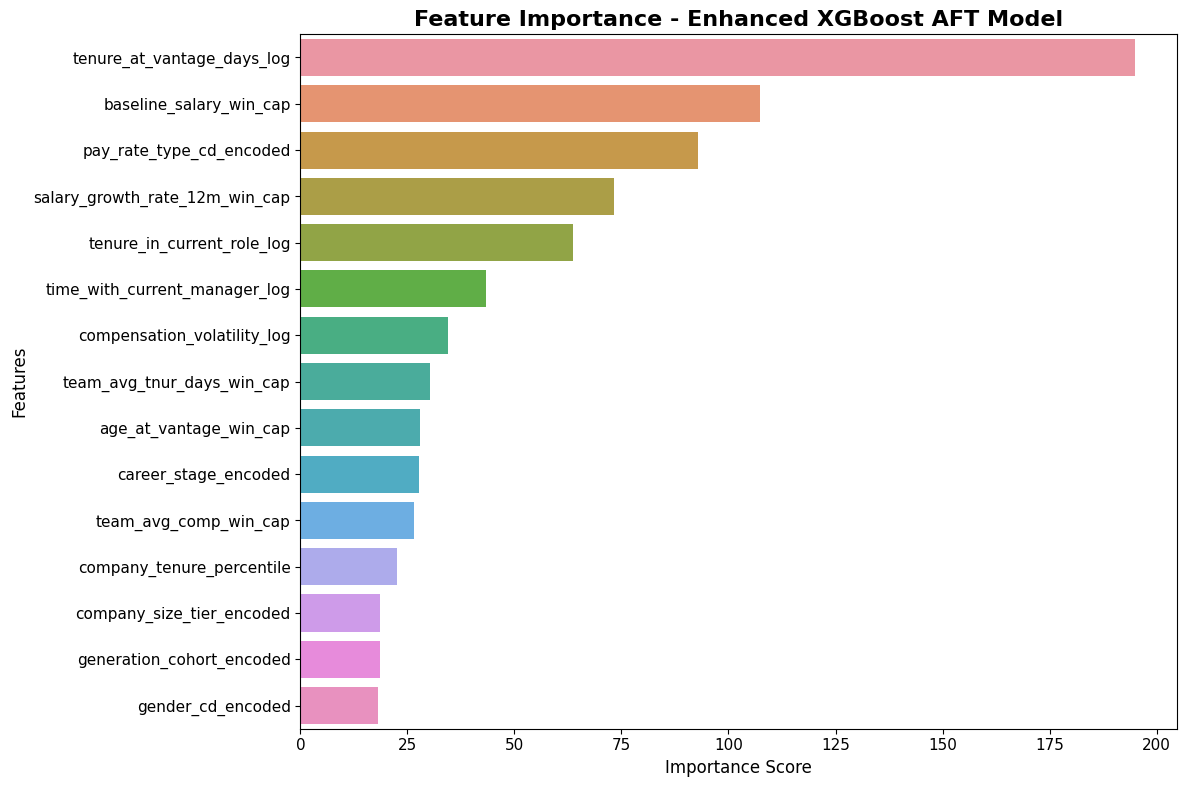

MODEL PERFORMANCE:
   Training size: 174334
   Validation size: 74832
   C-index (validation): 0.723
   AFT distribution: extreme
   Best iteration: 999
   Scale parameter: 8.772

6. Generating Survival Curves...
AFT Survival Curve Generation:
   Predictions (log scale) - Mean: 31.720, Std: 21.869
   Scale parameter (σ): 8.772
   Distribution: extreme
   Survival Curve Statistics:
     1-day survival: 0.901 (std: 0.111)
     365-day survival: 0.826 (std: 0.184)
     Average decline: 0.074


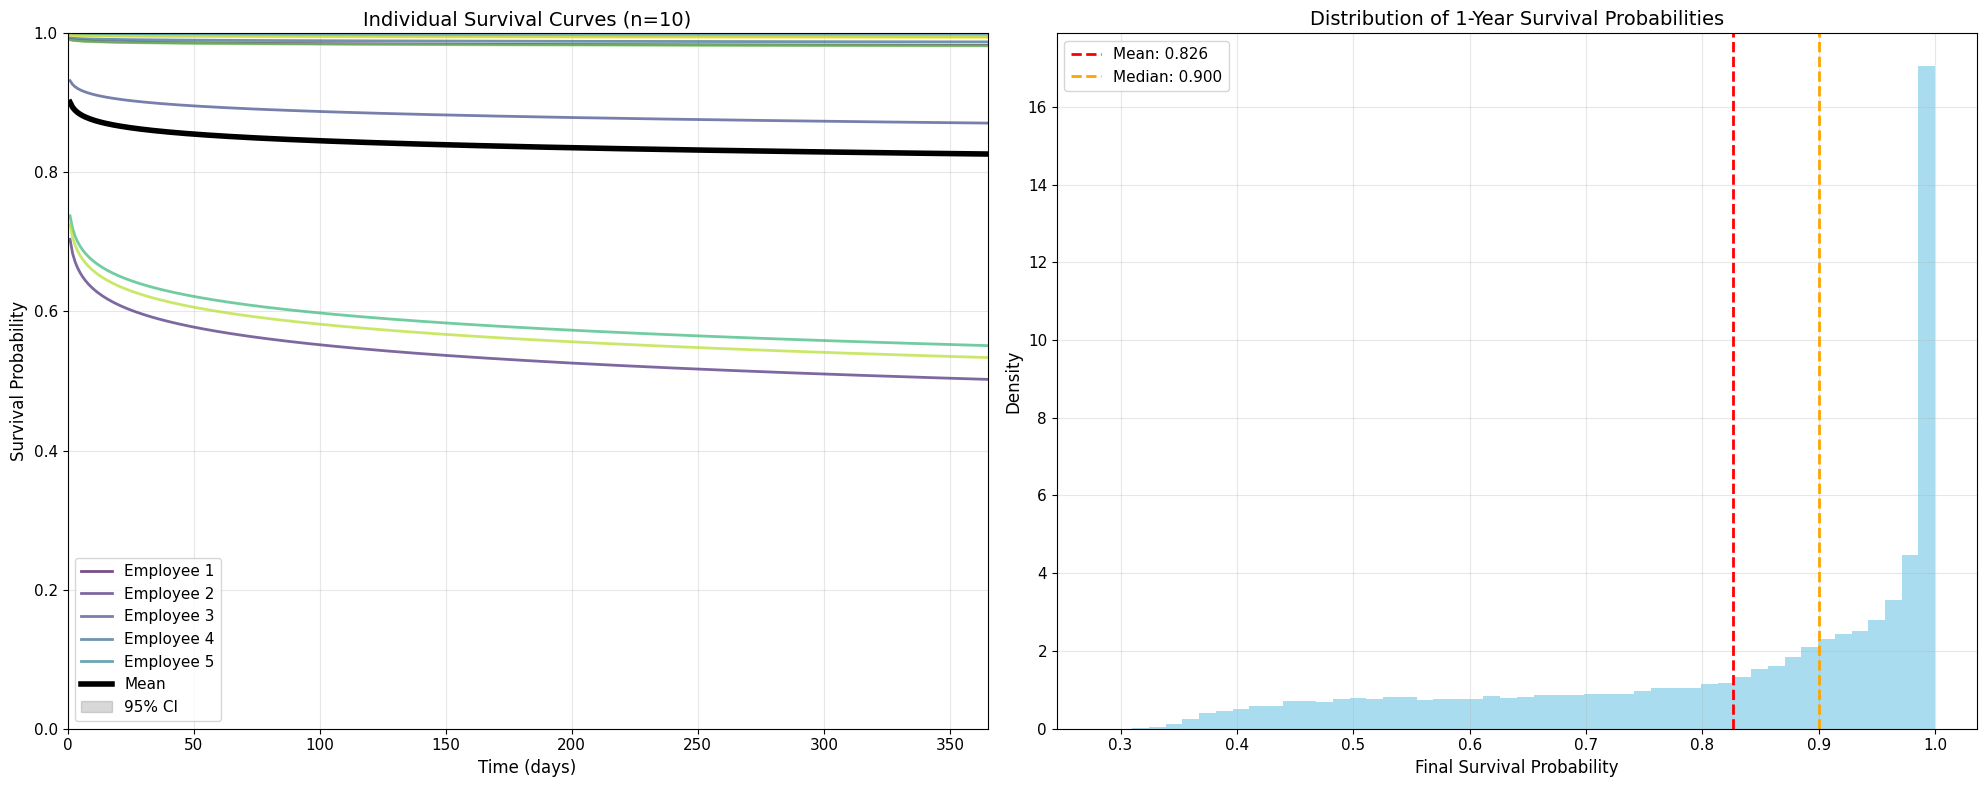

Survival Curve Statistics:
   Mean final survival: 0.826
   Std final survival: 0.184
   Range: [0.281, 1.000]
   Coefficient of variation: 0.223

7. Enhanced Risk Assessment...
Enhanced Lorenz Curve Calculation:
   Risk scores - Mean: 0.803, Std: 0.155
   Gini coefficient: 0.3620


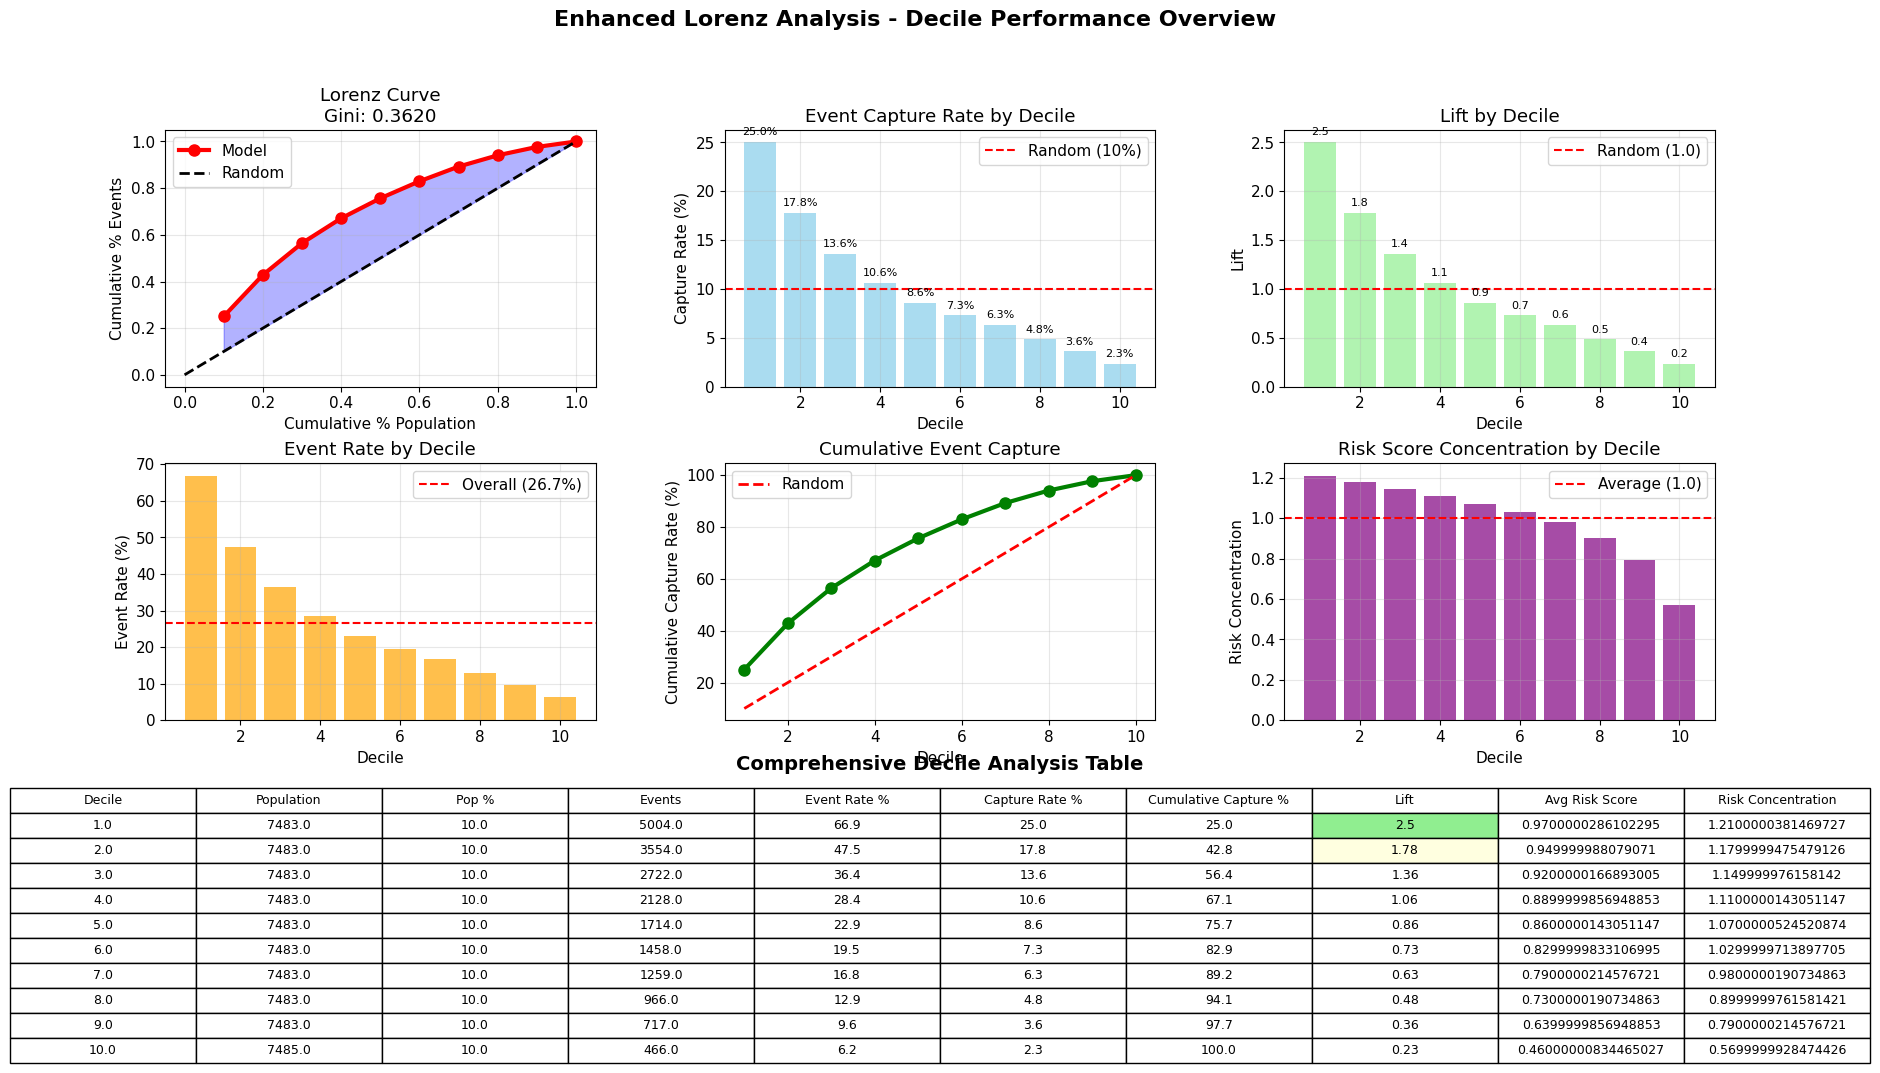


DECILE ANALYSIS INSIGHTS:
Top decile captures 25.0% of all events
Top decile lift: 2.5x better than random
Top decile event rate: 66.9%
Top 3 deciles capture 56.4% of all events
Top 3 deciles represent 30.0% of population

8. Additional Analysis Plots...


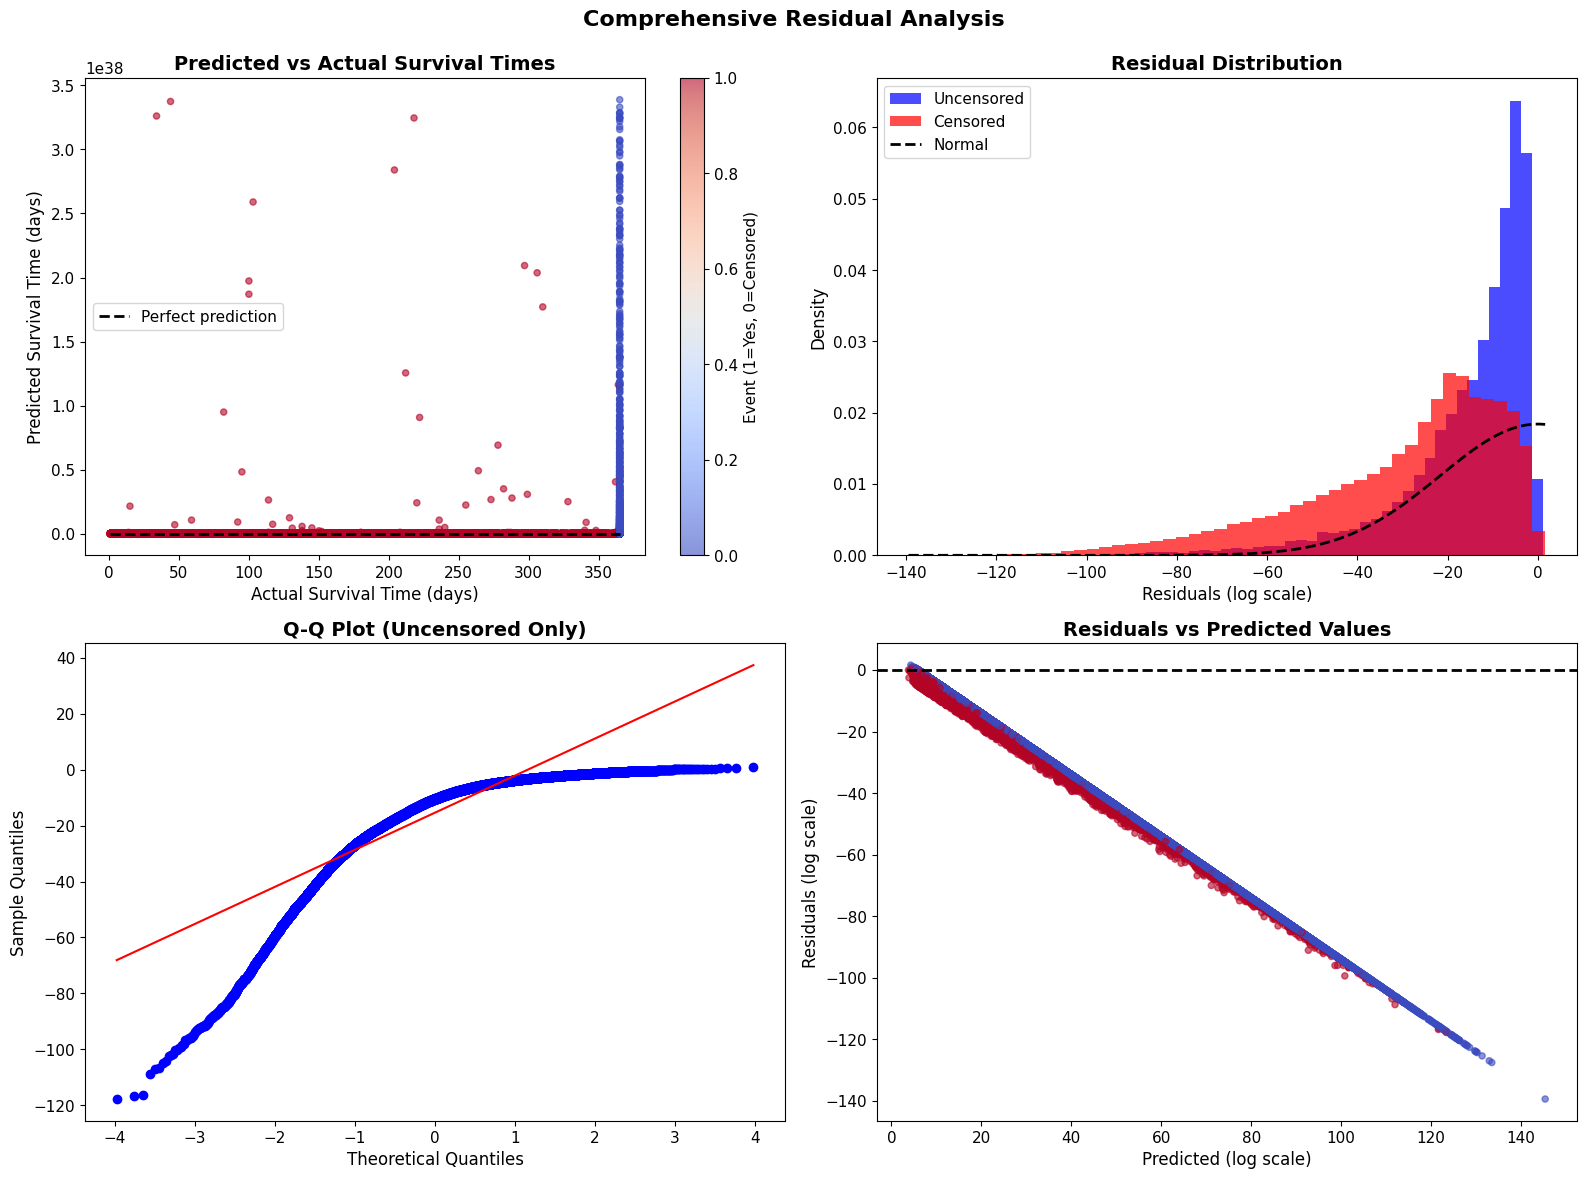


Residual Analysis Summary:
   Mean residual: -26.1521
   Std residual: 21.6722
   Skewness: -1.2688
   Kurtosis: 1.3015
   Normality test p-value: 0.0000


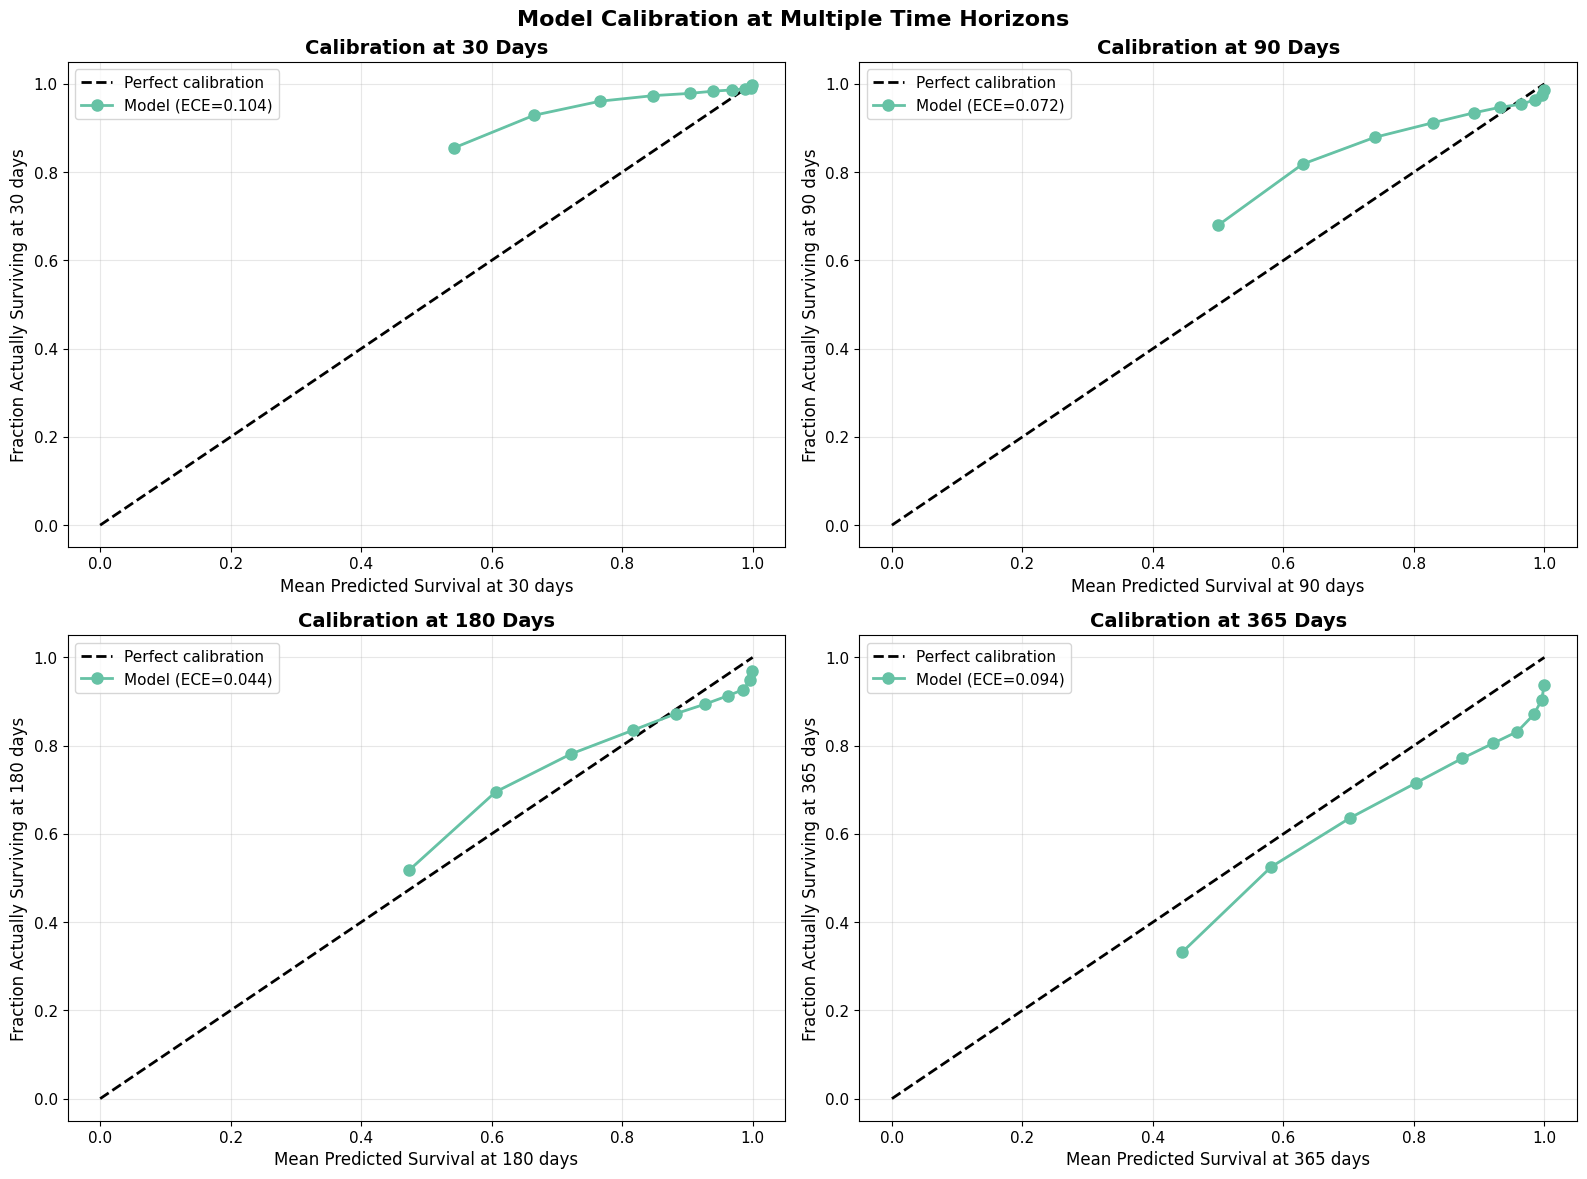


Calibration Summary:
   30_days - ECE: 0.1042
   90_days - ECE: 0.0717
   180_days - ECE: 0.0440
   365_days - ECE: 0.0935


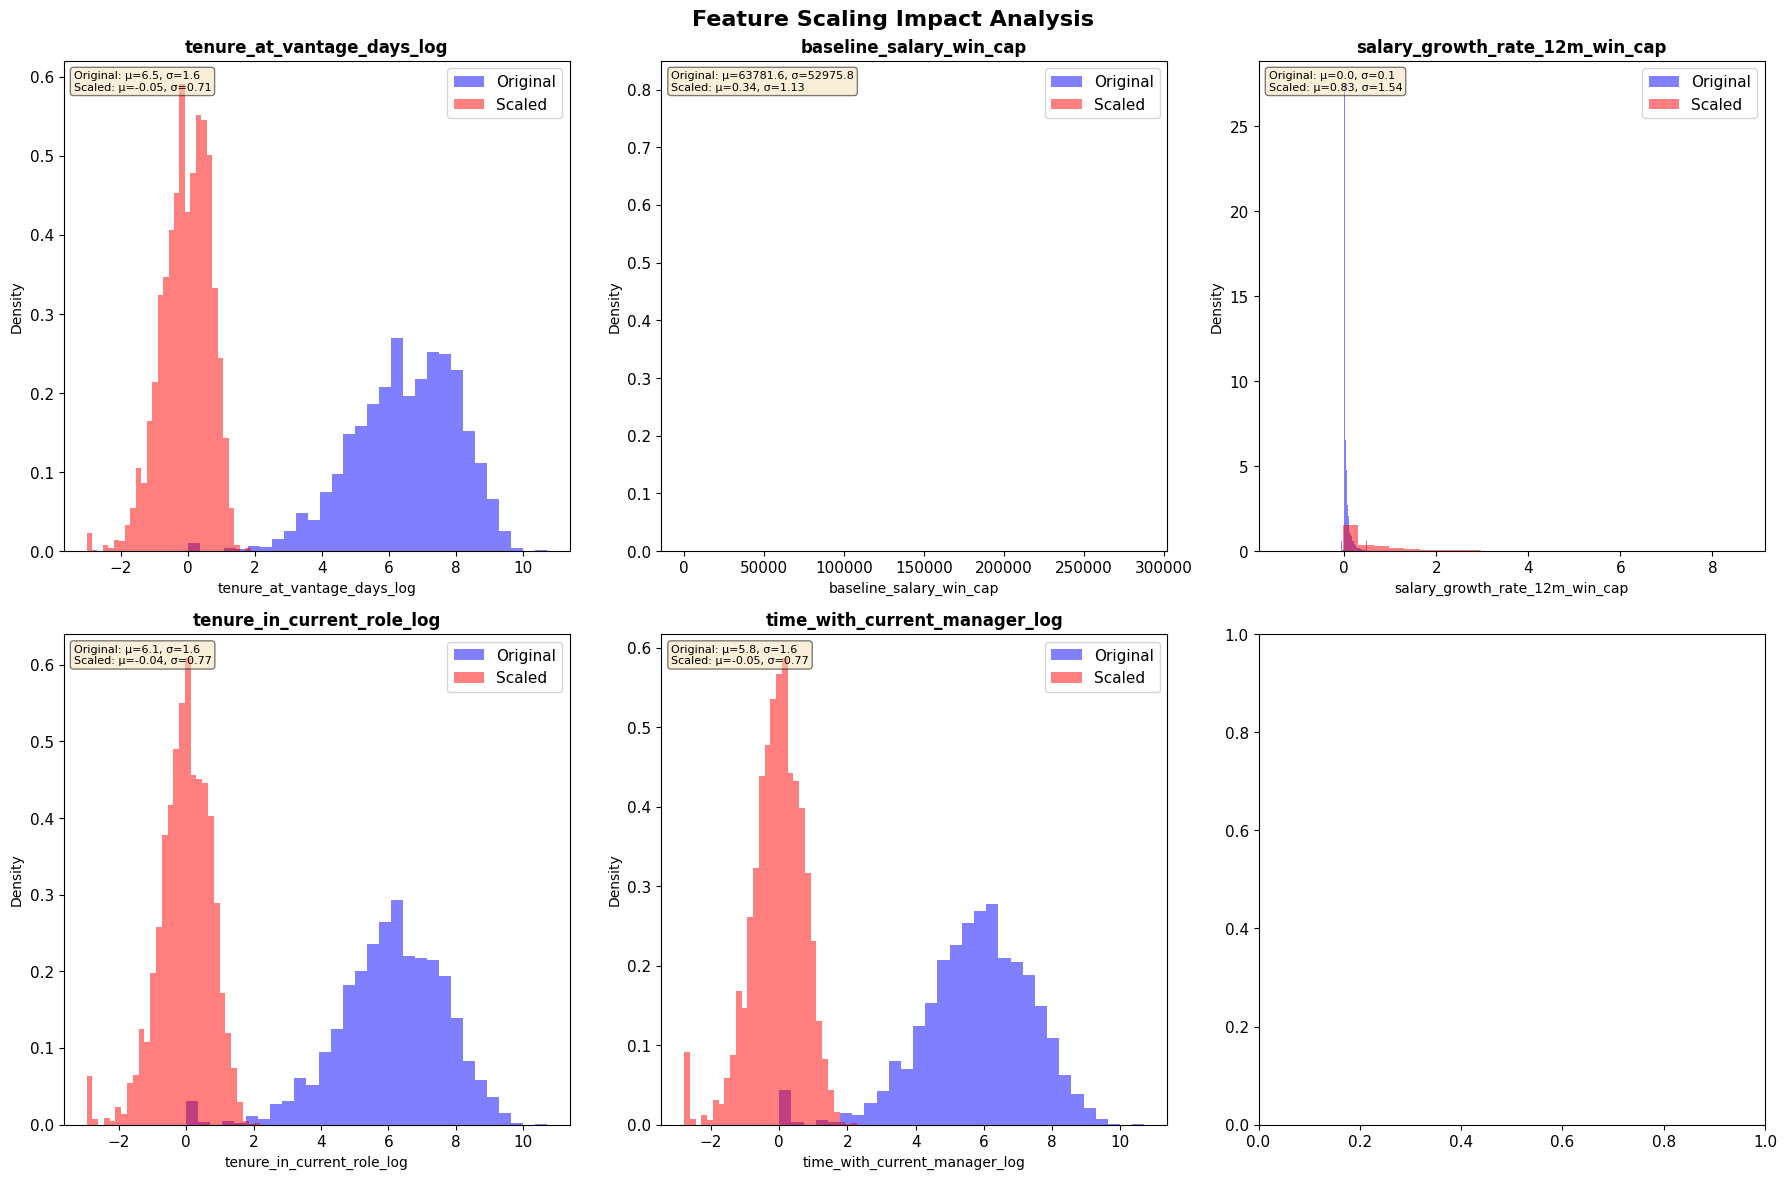

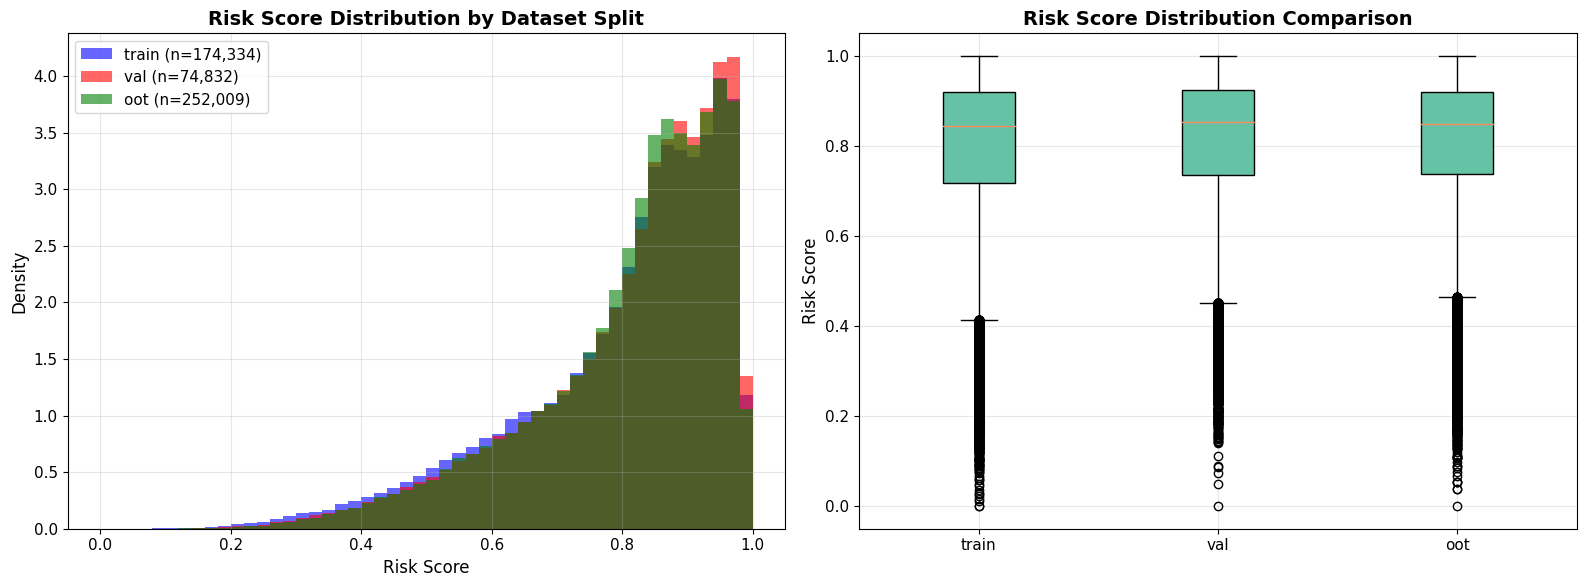


Risk Score Stability:
   KS test (train vs val): statistic=0.0294, p-value=0.0000
   KS test (train vs oot): statistic=0.0279, p-value=0.0000


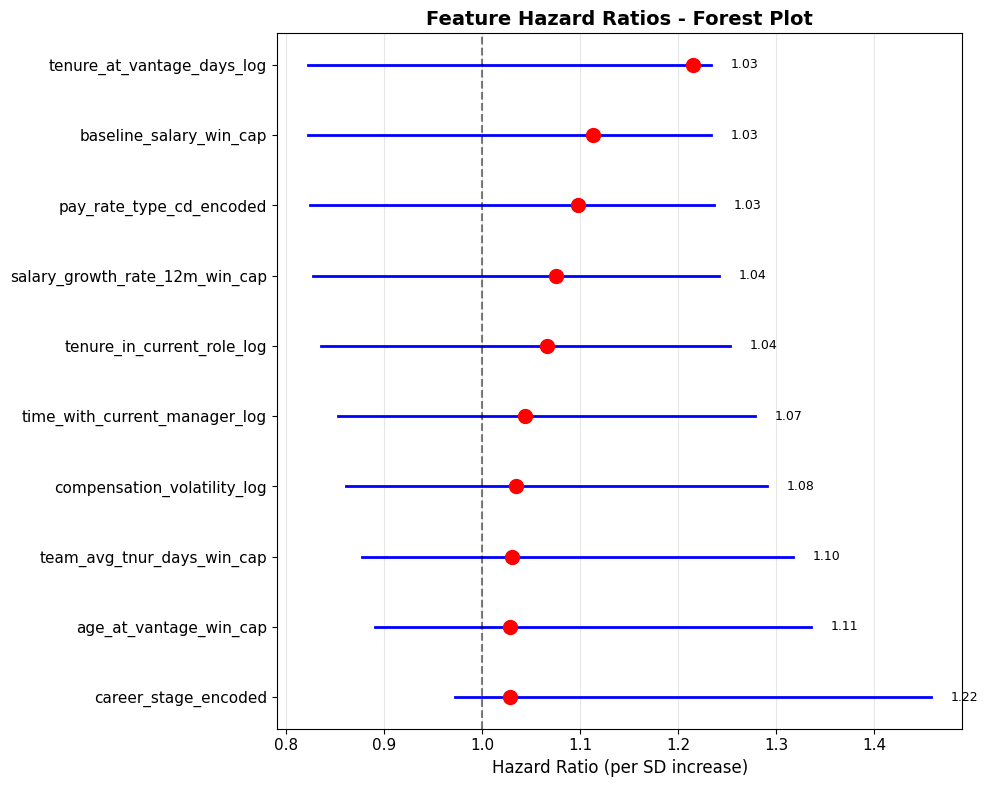

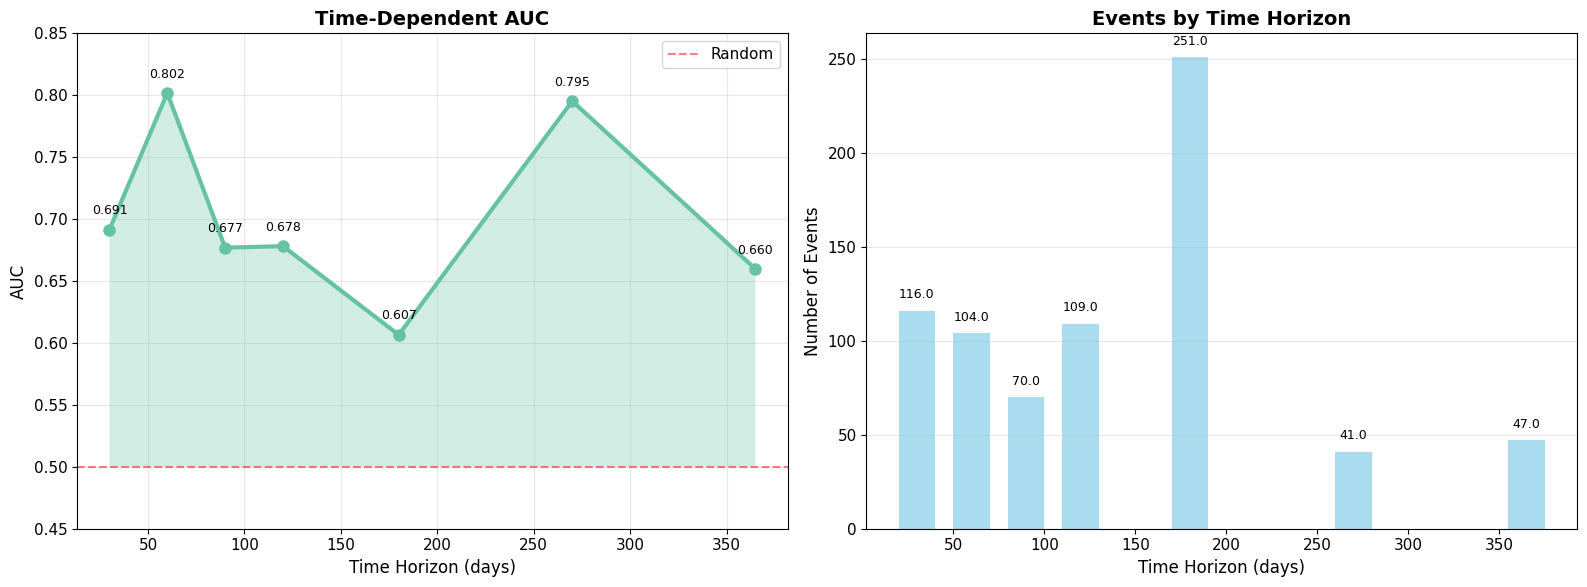


Time-Dependent AUC Summary:
   Best AUC: 0.802 at 60 days
   Average AUC: 0.701

9. Model Validation...

COMPREHENSIVE MODEL VALIDATION
1. PREDICTION DISTRIBUTION:
   Mean: 31.720 (log-scale)
   Std: 21.869 (log-scale)
   Range: [3.811, 145.351] (log-scale)
   Unique predictions: 74346

2. PREDICTION vs ACTUAL CORRELATION:
   Pearson correlation: 0.268 (p=0.000e+00)
   Spearman correlation: 0.393 (p=0.000e+00)

3. DIRECTIONAL VALIDATION:
   High predictions group:
     Average actual survival: 340.3 days
     Event rate: 0.130
   Low predictions group:
     Average actual survival: 275.8 days
     Event rate: 0.404
   Direction correct (high pred = longer survival): True
   Event direction correct (high pred = lower events): True

4. SURVIVAL CURVE VALIDATION:
   Final survival probabilities:
     Mean: 0.826
     Std: 0.184
     Range: [0.281, 1.000]
   Adequate variance: True
   Difference between extreme curves: 0.277

5. RISK RANKING VALIDATION:
   Top decile event rate: 0.669
   

In [0]:
analyzer = EnhancedSurvivalAnalysis(data, AFTDistribution.EXTREME)
results = analyzer.run_comprehensive_analysis()

RUNNING COMPREHENSIVE ENHANCED SURVIVAL ANALYSIS

1. Baseline Analysis...

2. Industry Analysis...

3. Demographic Analysis...

4. Temporal Trends Analysis...

5. Enhanced Predictive Modeling...
Building enhanced XGBoost AFT predictive model...

AFT Parameter Estimation:
   Uncensored observations: 46651
   Prediction range (log): [3.467, 194.230]
   Residual std (uncensored): 15.044
   Sigma (MAD): 9.445
   Sigma (IQR): 11.148
   Final sigma: 6.146


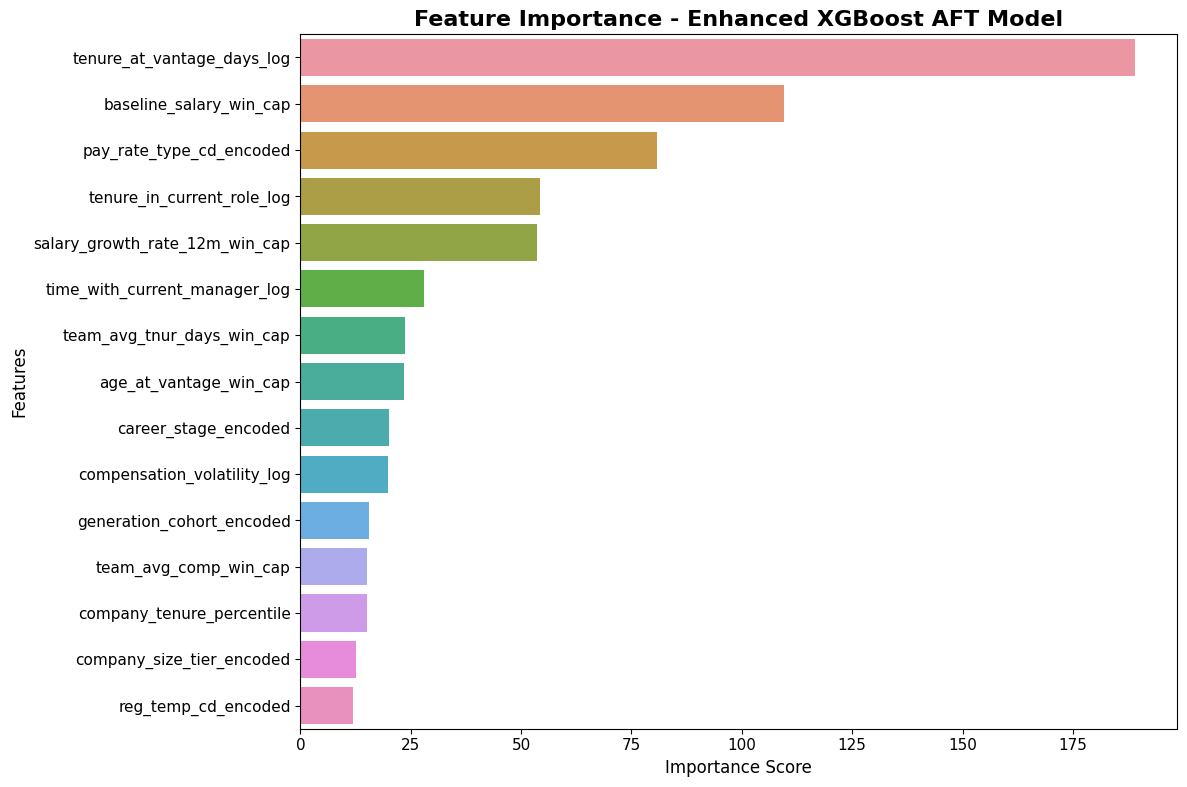

MODEL PERFORMANCE:
   Training size: 174334
   Validation size: 74832
   C-index (validation): 0.725
   AFT distribution: logistic
   Best iteration: 999
   Scale parameter: 6.146

6. Generating Survival Curves...
AFT Survival Curve Generation:
   Predictions (log scale) - Mean: 32.261, Std: 24.162
   Scale parameter (σ): 6.146
   Distribution: logistic
   Survival Curve Statistics:
     1-day survival: 0.944 (std: 0.078)
     365-day survival: 0.882 (std: 0.150)
     Average decline: 0.062


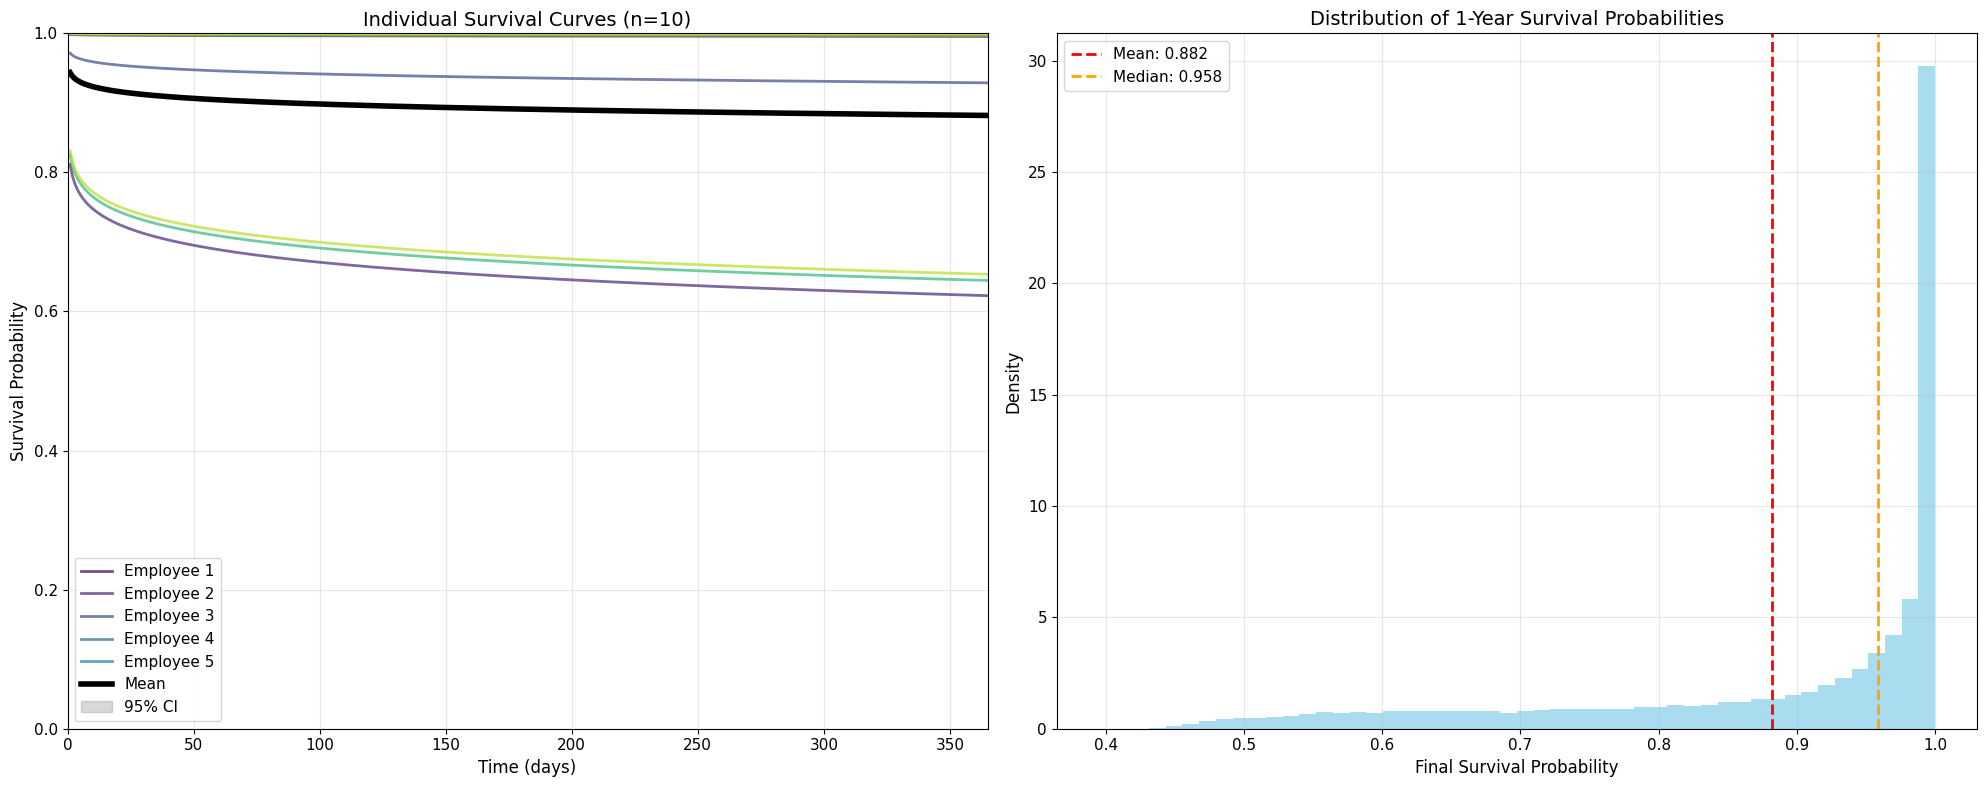

Survival Curve Statistics:
   Mean final survival: 0.882
   Std final survival: 0.150
   Range: [0.395, 1.000]
   Coefficient of variation: 0.170

7. Enhanced Risk Assessment...
Enhanced Lorenz Curve Calculation:
   Risk scores - Mean: 0.858, Std: 0.118
   Gini coefficient: 0.3651


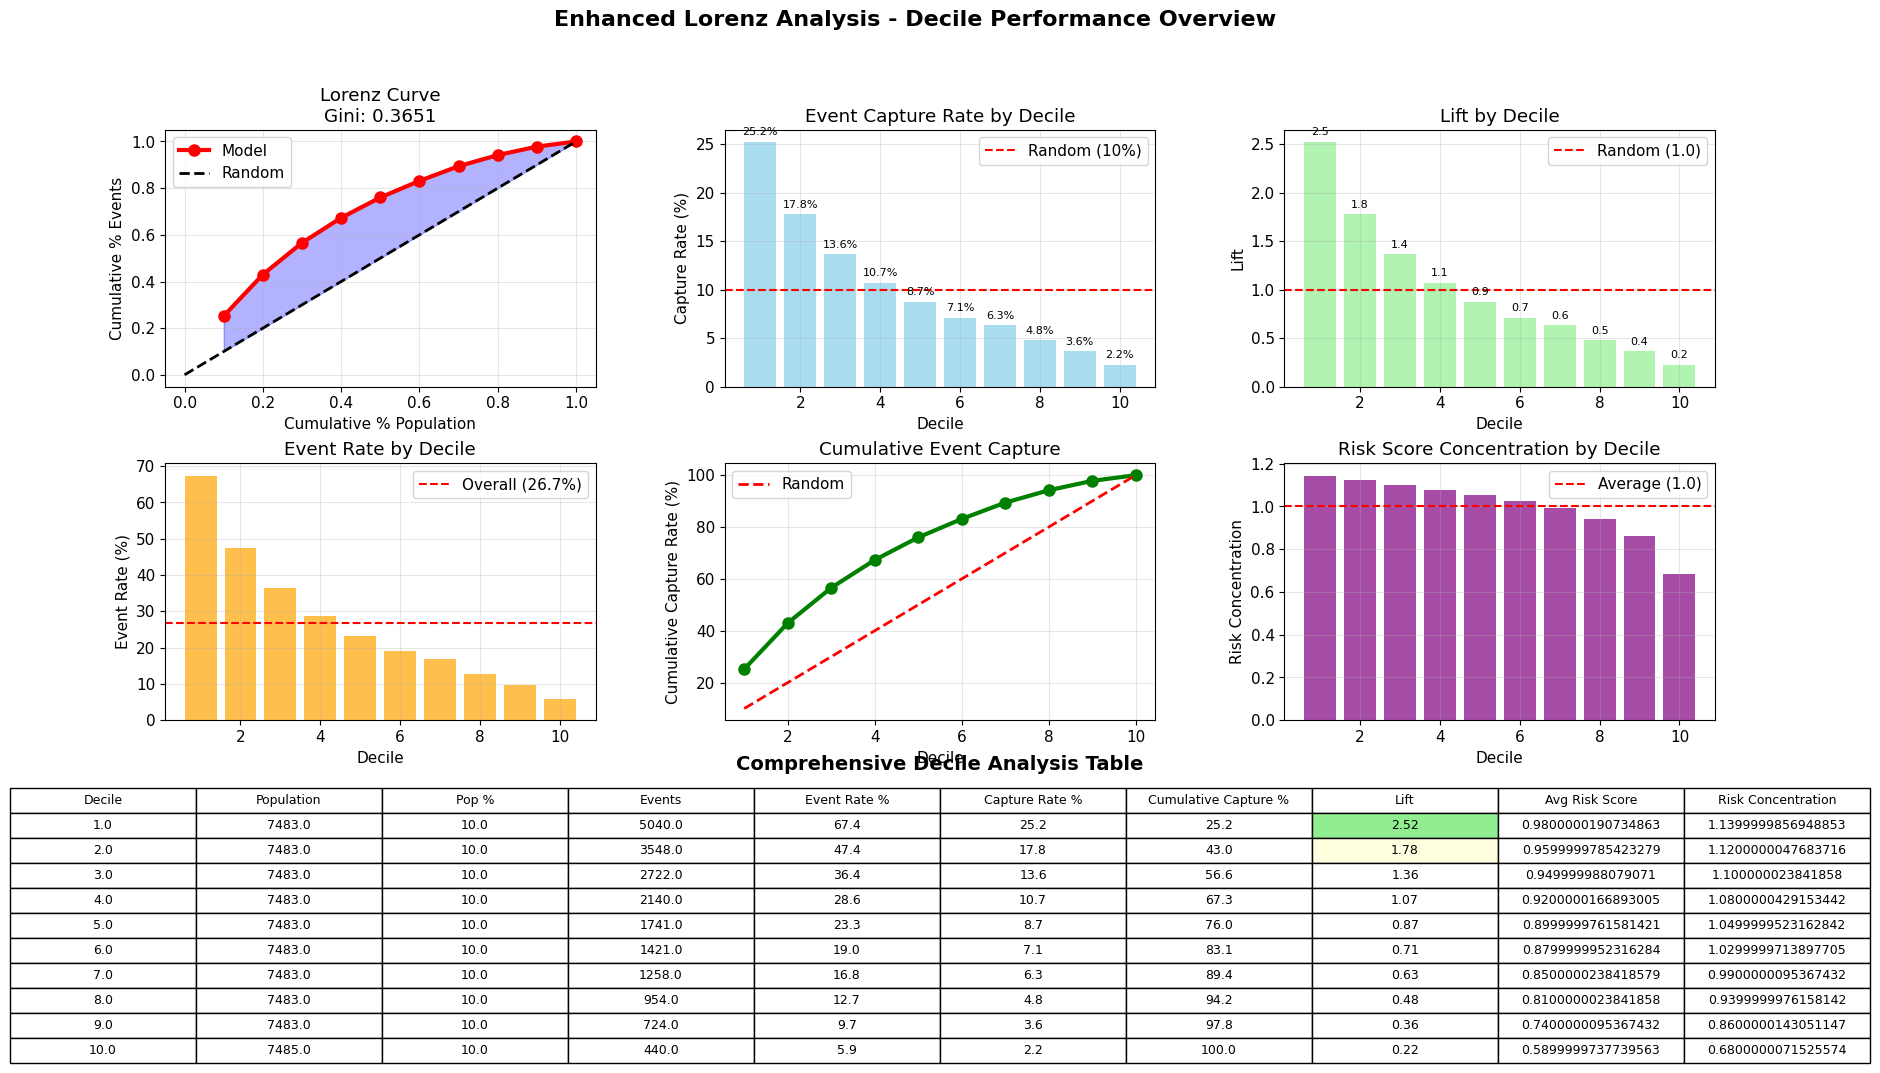


DECILE ANALYSIS INSIGHTS:
Top decile captures 25.2% of all events
Top decile lift: 2.5x better than random
Top decile event rate: 67.4%
Top 3 deciles capture 56.6% of all events
Top 3 deciles represent 30.0% of population

8. Additional Analysis Plots...


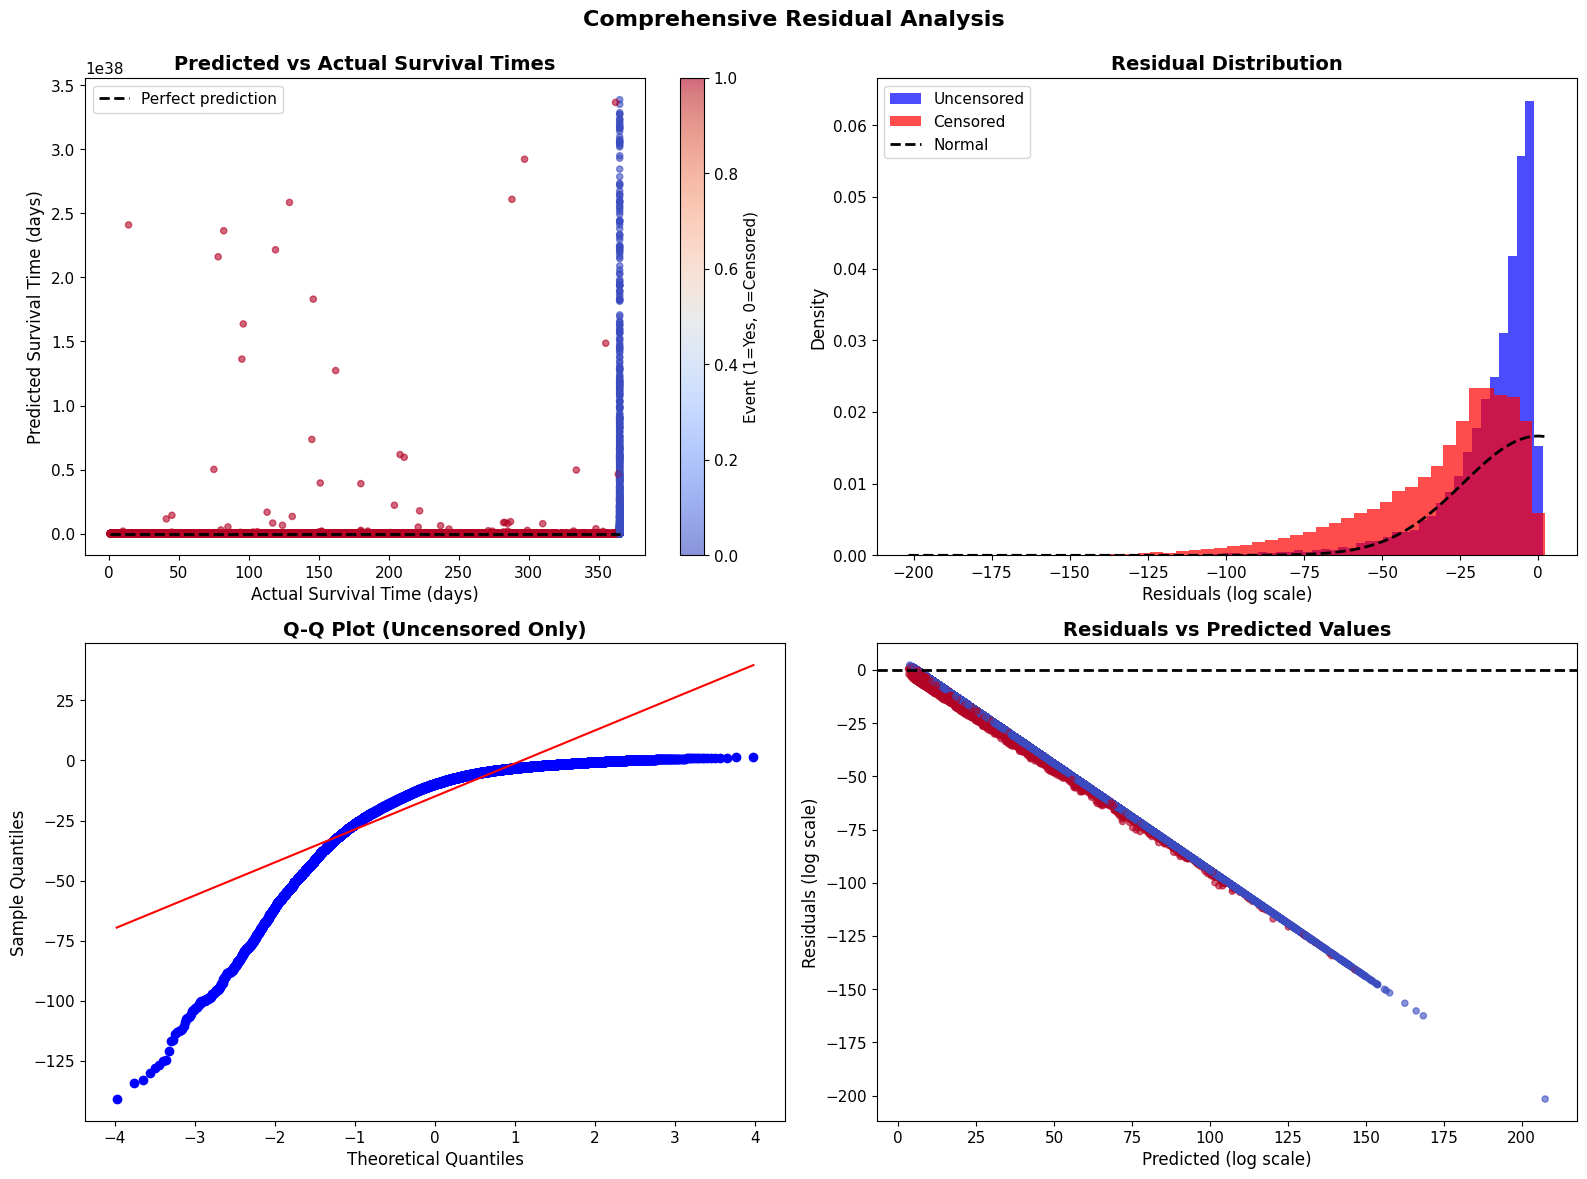


Residual Analysis Summary:
   Mean residual: -26.6931
   Std residual: 23.9701
   Skewness: -1.5109
   Kurtosis: 2.3850
   Normality test p-value: 0.0000


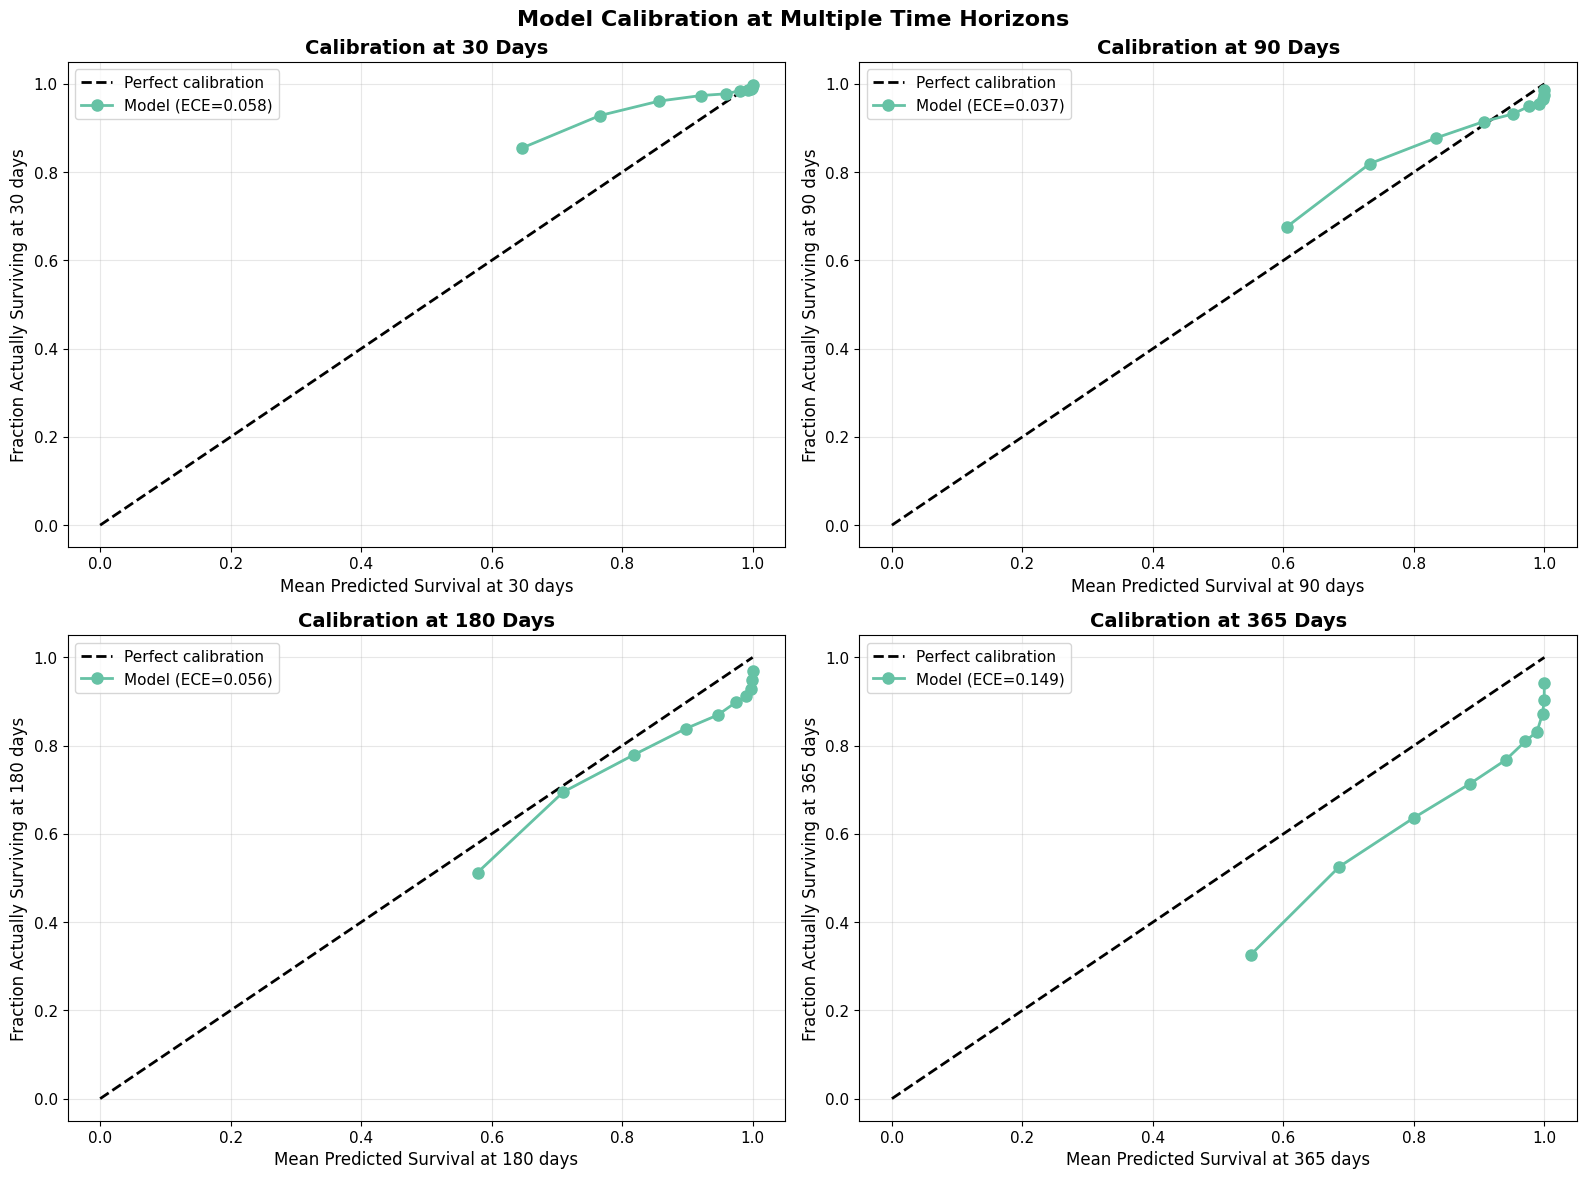


Calibration Summary:
   30_days - ECE: 0.0576
   90_days - ECE: 0.0365
   180_days - ECE: 0.0559
   365_days - ECE: 0.1490


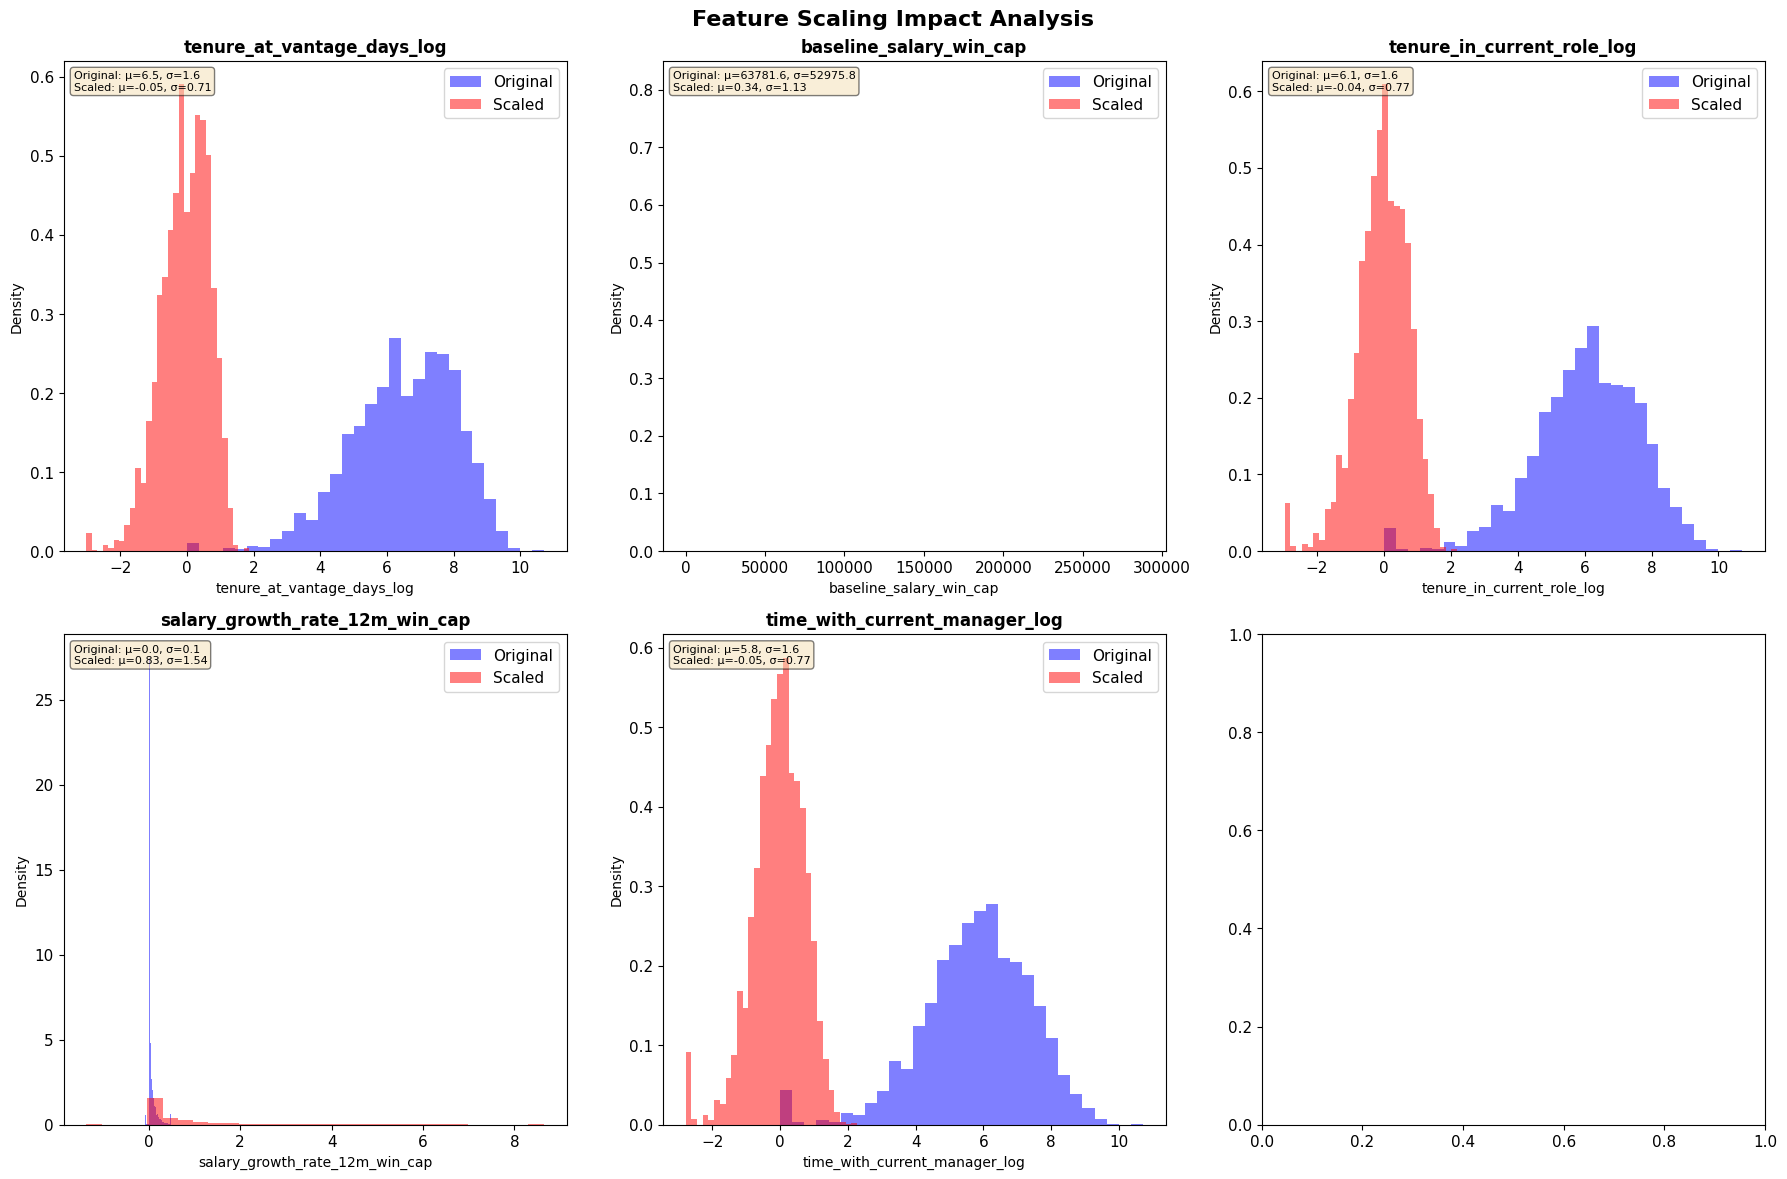

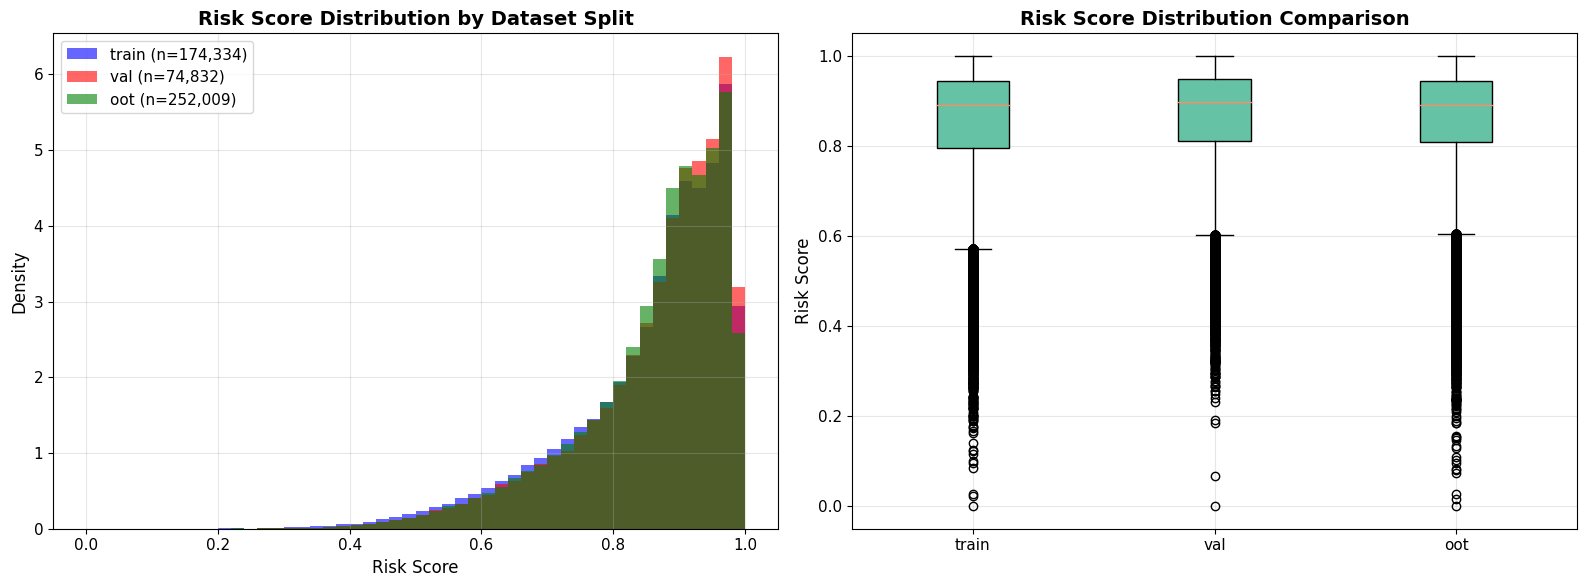


Risk Score Stability:
   KS test (train vs val): statistic=0.0299, p-value=0.0000
   KS test (train vs oot): statistic=0.0228, p-value=0.0000


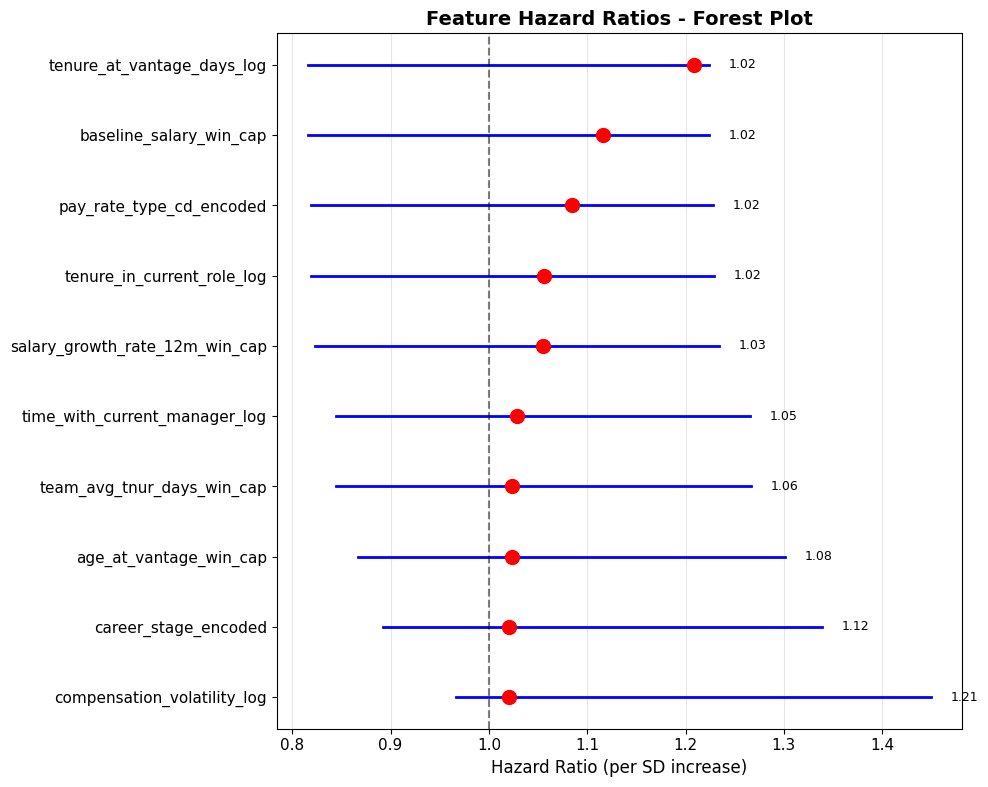

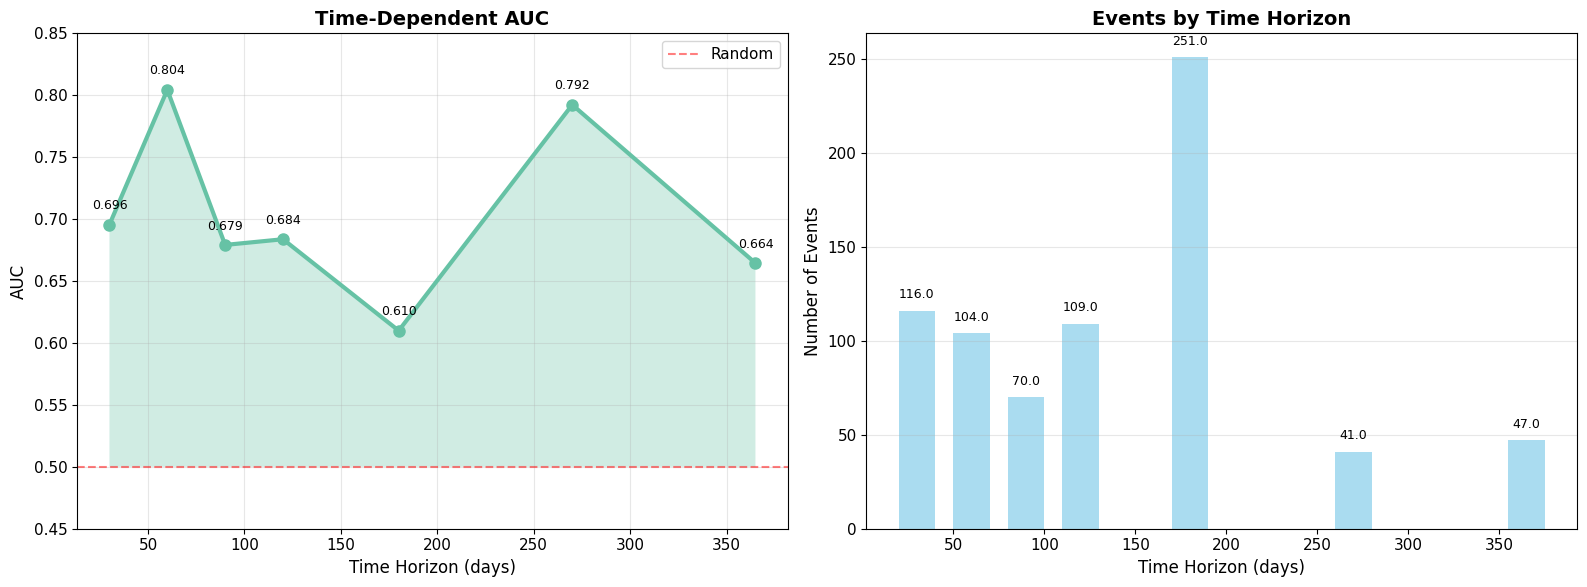


Time-Dependent AUC Summary:
   Best AUC: 0.804 at 60 days
   Average AUC: 0.704

9. Model Validation...

COMPREHENSIVE MODEL VALIDATION
1. PREDICTION DISTRIBUTION:
   Mean: 32.261 (log-scale)
   Std: 24.162 (log-scale)
   Range: [3.276, 207.513] (log-scale)
   Unique predictions: 74406

2. PREDICTION vs ACTUAL CORRELATION:
   Pearson correlation: 0.261 (p=0.000e+00)
   Spearman correlation: 0.396 (p=0.000e+00)

3. DIRECTIONAL VALIDATION:
   High predictions group:
     Average actual survival: 340.7 days
     Event rate: 0.128
   Low predictions group:
     Average actual survival: 275.3 days
     Event rate: 0.406
   Direction correct (high pred = longer survival): True
   Event direction correct (high pred = lower events): True

4. SURVIVAL CURVE VALIDATION:
   Final survival probabilities:
     Mean: 0.882
     Std: 0.150
     Range: [0.395, 1.000]
   Adequate variance: True
   Difference between extreme curves: 0.160

5. RISK RANKING VALIDATION:
   Top decile event rate: 0.674
   

In [0]:
analyzer = EnhancedSurvivalAnalysis(data, AFTDistribution.LOGISTIC)
results = analyzer.run_comprehensive_analysis()

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import IsolationForest
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

class OptimizedAFTDiagnostics:
    """Optimized AFT diagnostics with unlimited features/industries, smart sampling"""
    
    def __init__(self, output_path='./aft_diagnostics', performance_mode=True):
        self.output_path = output_path
        self.performance_mode = performance_mode
        
        # Sampling parameters only (no feature/industry limits)
        self.max_sample_size = 50000*5 if performance_mode else None
        self.max_kde_samples = 10000*5
        self.max_test_samples = 2000*5
        self.chunk_size = 100000  # For memory management
        
        self.fitted_transformers = {}
        
        import os
        os.makedirs(output_path, exist_ok=True)
    
    def smart_sample(self, df, max_samples=None, stratify_col=None):
        """Intelligent sampling preserving all segments"""
        if max_samples is None:
            max_samples = self.max_sample_size
            
        if len(df) <= max_samples:
            return df
        
        if stratify_col and stratify_col in df.columns:
            # Stratified sampling to preserve all segments
            return df.groupby(stratify_col).apply(
                lambda x: x.sample(min(len(x), max_samples // df[stratify_col].nunique()), 
                                 random_state=42)
            ).reset_index(drop=True)
        else:
            return df.sample(n=max_samples, random_state=42)
    
    def process_in_chunks(self, df, chunk_size=None):
        """Process large dataframes in chunks for memory efficiency"""
        if chunk_size is None:
            chunk_size = self.chunk_size
            
        for i in range(0, len(df), chunk_size):
            yield df.iloc[i:i+chunk_size]
    
    def assess_target_distribution(self, df, time_col='survival_time_days', event_col='event_indicator_all'):
        """Optimized target distribution analysis with sampling"""
        # Sample for performance while preserving distribution
        if len(df) > self.max_sample_size:
            df_sample = self.smart_sample(df, self.max_sample_size, event_col)
        else:
            df_sample = df
        
        uncensored_mask = df_sample[event_col] == 1
        survival_times = df_sample.loc[uncensored_mask, time_col].values
        
        # Limit samples for expensive statistical tests only
        if len(survival_times) > self.max_test_samples:
            test_sample = np.random.choice(survival_times, self.max_test_samples, replace=False)
        else:
            test_sample = survival_times
        
        log_survival_times = np.log(test_sample + 1)
        
        # Fast normality test (Jarque-Bera instead of Shapiro-Wilk)
        if len(log_survival_times) > 20:
            jb_stat, jb_p = stats.jarque_bera(log_survival_times)
        else:
            jb_stat, jb_p = np.nan, np.nan
        
        # Distribution fit tests with sampling
        logistic_params = stats.logistic.fit(log_survival_times)
        ks_logistic = stats.kstest(log_survival_times[:10000],  # Sample for speed
                                 lambda x: stats.logistic.cdf(x, *logistic_params))
        
        return {
            'target_distribution_tests': {
                'normal_aft': {
                    'jarque_bera': {'statistic': jb_stat, 'p_value': jb_p},
                    'interpretation': 'PASS' if jb_p > 0.05 else 'FAIL'
                },
                'logistic_aft': {
                    'ks_test': {'statistic': ks_logistic.statistic, 'p_value': ks_logistic.pvalue},
                    'interpretation': 'PASS' if ks_logistic.pvalue > 0.05 else 'FAIL'
                }
            },
            'recommended_distribution': self._recommend_distribution(jb_p, ks_logistic.pvalue),
            'sample_size': len(survival_times),
            'censoring_rate': 1 - uncensored_mask.mean(),
            'total_records': len(df)
        }
    
    def plot_target_kde_analysis(self, df, time_col='survival_time_days', event_col='event_indicator_all'):
        """KDE analysis with sampling but all industries shown"""
        # Sample data for KDE performance
        df_sample = self.smart_sample(df, self.max_kde_samples, event_col)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        uncensored_data = df_sample[df_sample[event_col] == 1][time_col]
        censored_data = df_sample[df_sample[event_col] == 0][time_col]
        
        # 1. Original survival times
        if len(uncensored_data) > 0:
            sns.kdeplot(data=uncensored_data, ax=axes[0,0], label='Uncensored', alpha=0.6)
        if len(censored_data) > 0:
            sns.kdeplot(data=censored_data, ax=axes[0,0], label='Censored', alpha=0.6)
        axes[0,0].set_title('Survival Times Distribution')
        axes[0,0].legend()
        
        # 2. Log-transformed
        if len(uncensored_data) > 0:
            log_uncensored = np.log(uncensored_data + 1)
            sns.kdeplot(data=log_uncensored, ax=axes[0,1], label='Log(Uncensored)', alpha=0.6)
            axes[0,1].set_title('Log-Transformed Distribution')
            axes[0,1].legend()
        
        # 3. ALL industries (no limit) - sample within each industry
        if 'naics_2digit' in df_sample.columns:
            all_industries = df_sample['naics_2digit'].value_counts()
            # Show all industries with sufficient data
            valid_industries = all_industries[all_industries >= 50].index
            colors = sns.color_palette("husl", len(valid_industries))
            
            for i, industry in enumerate(valid_industries):
                industry_data = df_sample[df_sample['naics_2digit'] == industry][time_col]
                if len(industry_data) > 50:
                    # Sample within industry if needed
                    if len(industry_data) > 1000:
                        industry_data = industry_data.sample(1000, random_state=42)
                    sns.kdeplot(data=np.log(industry_data + 1), ax=axes[1,0],
                              label=f'NAICS {industry}', color=colors[i % len(colors)], alpha=0.7)
            
            axes[1,0].set_title(f'Distribution by ALL Industries ({len(valid_industries)} shown)')
            axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 4. Event vs Censored comparison
        if len(uncensored_data) > 0 and len(censored_data) > 0:
            sns.kdeplot(data=np.log(uncensored_data + 1), ax=axes[1,1], 
                       label='Events', alpha=0.6, color='red')
            sns.kdeplot(data=np.log(censored_data + 1), ax=axes[1,1], 
                       label='Censored', alpha=0.6, color='green')
            axes[1,1].set_title('Event vs Censored Comparison')
            axes[1,1].legend()
        
        plt.tight_layout()
        plt.savefig(f'{self.output_path}/target_kde_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    def plot_feature_kde_analysis(self, df, feature_cols):
        """KDE analysis for ALL features with intelligent sampling"""
        # Sample data but keep ALL features
        df_sample = self.smart_sample(df, 20000*5)
        
        # Calculate number of subplot rows/cols for ALL features
        n_features = len(feature_cols)
        n_cols = 4
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.ravel()
        
        for idx, feature in enumerate(feature_cols):
            if feature not in df_sample.columns:
                continue
                
            ax = axes[idx]
            
            # Original distribution with sampling
            original_data = df_sample[feature].dropna()
            if len(original_data) > 5000:
                original_data = original_data.sample(5000*5, random_state=42)
            
            if len(original_data) > 0:
                sns.kdeplot(data=original_data, ax=ax, label='Original', alpha=0.6, color='blue')
            
            # Event-stratified KDEs
            if 'event_indicator_all' in df_sample.columns:
                event_data = df_sample[df_sample['event_indicator_all'] == 1][feature].dropna()
                censored_data = df_sample[df_sample['event_indicator_all'] == 0][feature].dropna()
                
                if len(event_data) > 50:
                    sample_size = min(2000*5, len(event_data))
                    event_sample = event_data.sample(sample_size, random_state=42) if len(event_data) > sample_size else event_data
                    sns.kdeplot(data=event_sample, ax=ax, label='Events', color='red', alpha=0.7)
                
                if len(censored_data) > 50:
                    sample_size = min(2000*5, len(censored_data))
                    censored_sample = censored_data.sample(sample_size, random_state=42) if len(censored_data) > sample_size else censored_data
                    sns.kdeplot(data=censored_sample, ax=ax, label='Censored', color='green', alpha=0.7)
            
            ax.set_title(f'{feature}')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # Hide empty subplots
        for idx in range(len(feature_cols), len(axes)):
            axes[idx].set_visible(False)
        
        plt.suptitle(f'Feature Distribution Analysis - ALL {len(feature_cols)} Features', fontsize=14)
        plt.tight_layout()
        plt.savefig(f'{self.output_path}/feature_kde_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    def calculate_residuals(self, model, X, y, event, distribution='normal'):
        """Fast residual calculation with chunked processing"""
        # Process in chunks for memory efficiency
        all_residuals = {'cox_snell': [], 'martingale': [], 'standardized': []}
        
        for chunk in self.process_in_chunks(pd.concat([X, y, event], axis=1), 50000*5):
            X_chunk = chunk.iloc[:, :-2]
            y_chunk = chunk.iloc[:, -2]
            event_chunk = chunk.iloc[:, -1]
            
            # Get predictions for chunk
            if hasattr(model, 'predict'):
                dmatrix = xgb.DMatrix(X_chunk)
                eta_pred = model.predict(dmatrix)
            else:
                eta_pred = model
            
            # Calculate residuals for chunk
            log_y = np.log(y_chunk)
            standardized_residuals = log_y - eta_pred
            
            # Simple Cox-Snell approximation
            z_scores = standardized_residuals / np.std(standardized_residuals)
            cox_snell_residuals = np.abs(z_scores)
            
            # Martingale residuals
            martingale_residuals = event_chunk - cox_snell_residuals
            
            # Collect results
            all_residuals['cox_snell'].extend(cox_snell_residuals.tolist())
            all_residuals['martingale'].extend(martingale_residuals.tolist())
            all_residuals['standardized'].extend(standardized_residuals.tolist())
        
        # Convert back to arrays
        for key in all_residuals:
            all_residuals[key] = np.array(all_residuals[key])
        
        return all_residuals
    
    def binned_performance_analysis(self, df, predictions_col, feature_cols, sample_size=100000*5):
        """Binned analysis for ALL features with sampling"""
        # Sample data if too large
        if len(df) > sample_size:
            df_sample = df.sample(n=sample_size, random_state=42)
        else:
            df_sample = df
        
        results = {}
        
        # Process ALL features (no limit)
        for feature in feature_cols:
            if feature not in df_sample.columns:
                continue
            
            feature_data = df_sample[[feature, predictions_col, 'event_indicator_all']].dropna()
            
            if len(feature_data) < 100:
                continue
            
            # Create bins
            try:
                feature_data['bin'] = pd.qcut(feature_data[feature], q=5, 
                                           labels=[f'Q{i+1}' for i in range(5)])
            except:
                feature_data['bin'] = pd.cut(feature_data[feature], bins=5, 
                                          labels=[f'Q{i+1}' for i in range(5)])
            
            bin_results = []
            for bin_name in feature_data['bin'].cat.categories:
                bin_df = feature_data[feature_data['bin'] == bin_name]
                
                if len(bin_df) < 20:
                    continue
                
                bin_metrics = {
                    'feature': feature,
                    'bin': bin_name,
                    'sample_size': len(bin_df),
                    'event_rate': bin_df['event_indicator_all'].mean(),
                    'mean_prediction': bin_df[predictions_col].mean(),
                    'calibration_error': abs(bin_df[predictions_col].mean() - 
                                           bin_df['event_indicator_all'].mean())
                }
                bin_results.append(bin_metrics)
            
            results[feature] = bin_results
        
        return results
    
    def stability_analysis(self, df, model, feature_cols):
        """Stability analysis for ALL industries with sampling"""
        stability_results = {}
        
        # Industry analysis (ALL industries, no limit)
        if 'naics_2digit' in df.columns:
            industry_counts = df['naics_2digit'].value_counts()
            valid_industries = industry_counts[industry_counts >= 500].index.tolist()  # Lower threshold
            
            for industry in valid_industries:
                industry_df = df[df['naics_2digit'] == industry].copy()
                
                # Sample within industry if too large
                if len(industry_df) > 20000:
                    industry_df = industry_df.sample(20000, random_state=42)
                
                # Prepare features
                X_industry = industry_df[feature_cols].fillna(0)
                
                # Calculate predictions
                dmatrix = xgb.DMatrix(X_industry)
                predictions = model.predict(dmatrix)
                
                # Get actual outcomes
                y_actual = industry_df['event_indicator_all'].values
                times_actual = industry_df['survival_time_days'].values
                
                # Calculate metrics
                industry_metrics = self._calculate_segment_metrics(
                    predictions, y_actual, times_actual, f'Industry_{industry}'
                )
                
                stability_results[industry] = industry_metrics
        
        return stability_results
    
    def _calculate_segment_metrics(self, predictions, actuals, times, segment_name):
        """Calculate comprehensive metrics for each segment"""
        from sklearn.metrics import roc_auc_score
        
        n_samples = len(predictions)
        event_rate = np.mean(actuals)
        mean_survival_time = np.mean(times[actuals == 1]) if np.any(actuals == 1) else np.nan
        
        # Discrimination metrics
        if len(set(actuals)) > 1:
            try:
                auc = roc_auc_score(actuals, predictions)
            except:
                auc = np.nan
        else:
            auc = np.nan
        
        # Calibration metrics
        mean_predicted_risk = np.mean(predictions)
        calibration_error = abs(mean_predicted_risk - event_rate)
        
        return {
            'segment': segment_name,
            'n_samples': n_samples,
            'event_rate': event_rate,
            'mean_survival_time': mean_survival_time,
            'auc': auc,
            'mean_predicted_risk': mean_predicted_risk,
            'calibration_error': calibration_error,
            'prediction_std': np.std(predictions)
        }
    
    def _recommend_distribution(self, normal_p, logistic_p):
        """Quick distribution recommendation"""
        if not np.isnan(normal_p) and normal_p > logistic_p:
            return {'distribution': 'normal', 'confidence': 'high' if normal_p > 0.05 else 'low'}
        else:
            return {'distribution': 'logistic', 'confidence': 'high' if logistic_p > 0.05 else 'low'}
    
    def comprehensive_diagnostics(self, df, model, feature_cols, 
                                time_col='survival_time_days', event_col='event_indicator_all'):
        """Main diagnostic pipeline - ALL features, ALL industries, smart sampling"""
        
        print(f"=== COMPREHENSIVE AFT DIAGNOSTICS ===")
        print(f"Dataset size: {len(df):,} records")
        print(f"Features: {len(feature_cols)} (ALL included)")
        
        results = {}
        
        # 1. Target distribution analysis
        print("\n1. Analyzing target distribution...")
        target_results = self.assess_target_distribution(df, time_col, event_col)
        results['target_distribution'] = target_results
        
        # 2. KDE visualizations
        print("\n2. Generating KDE visualizations...")
        self.plot_target_kde_analysis(df, time_col, event_col)
        self.plot_feature_kde_analysis(df, feature_cols)
        
        # 3. Add predictions to dataframe
        print("\n3. Calculating predictions...")
        X_all = df[feature_cols].fillna(0)
        
        # Process predictions in chunks if dataset is large
        all_predictions = []
        for chunk in self.process_in_chunks(X_all, 50000*5):
            dmatrix = xgb.DMatrix(chunk)
            chunk_predictions = model.predict(dmatrix)
            all_predictions.extend(chunk_predictions.tolist())
        
        df_copy = df.copy()
        df_copy['predictions'] = all_predictions
        
        # 4. Binned performance analysis (ALL features)
        print(f"\n4. Analyzing ALL {len(feature_cols)} features across bins...")
        binned_results = self.binned_performance_analysis(df_copy, 'predictions', feature_cols)
        results['binned_performance'] = binned_results
        
        # 5. Stability analysis (ALL industries)
        print("\n5. Stability analysis across ALL industries...")
        stability_results = self.stability_analysis(df_copy, model, feature_cols)
        results['stability'] = stability_results
        
        # 6. Residual analysis (sampled)
        print("\n6. Residual diagnostics...")
        # Sample for residual analysis
        sample_size = min(30000, len(df))
        df_residual = df.sample(sample_size, random_state=42)
        
        X_residual = df_residual[feature_cols].fillna(0)
        y_residual = df_residual[time_col]
        event_residual = df_residual[event_col]
        
        residual_results = self.calculate_residuals(model, X_residual, y_residual, event_residual)
        results['residuals'] = residual_results
        
        # 7. Generate summary report
        print("\n7. Generating comprehensive report...")
        self._generate_summary_report(results, len(feature_cols), len(stability_results))
        
        return results
    
    def _generate_summary_report(self, results, n_features, n_industries):
        """Generate comprehensive summary report"""
        
        target = results['target_distribution']
        
        report = f"""
COMPREHENSIVE AFT DIAGNOSTICS REPORT
===================================

DATASET OVERVIEW:
- Total records: {target['total_records']:,}
- Sample used for tests: {target['sample_size']:,}
- Censoring rate: {target['censoring_rate']:.1%}

ANALYSIS SCOPE:
- Features analyzed: {n_features} (ALL features included)
- Industries analyzed: {n_industries} (ALL valid industries)
- Sampling applied: Yes (for performance optimization)

TARGET DISTRIBUTION:
- Recommended AFT distribution: {target['recommended_distribution']['distribution']}
- Confidence: {target['recommended_distribution']['confidence']}
- Normal AFT test: {target['target_distribution_tests']['normal_aft']['interpretation']}
- Logistic AFT test: {target['target_distribution_tests']['logistic_aft']['interpretation']}

PERFORMANCE ANALYSIS:
- Binned analysis completed for ALL {n_features} features
- Industry stability analysis: {n_industries} industries analyzed
- No artificial limits applied to features or industries

RESIDUAL DIAGNOSTICS:
- Residual analysis completed with sampling optimization
- Memory-efficient chunked processing applied

RECOMMENDATIONS:
1. Use {target['recommended_distribution']['distribution']} AFT distribution
2. All {n_features} features retained in analysis
3. All {n_industries} industries monitored for stability
4. Sampling strategy preserves statistical validity while ensuring performance

OPTIMIZATION APPLIED:
✓ Smart sampling for statistical tests and visualizations
✓ Chunked processing for memory efficiency
✓ Preserved all features and industries as requested
✓ Maintained statistical rigor with performance optimization
"""
        
        # Save report
        with open(f"{self.output_path}/comprehensive_report.txt", "w") as f:
            f.write(report)
        
        print(report)
        return report

# USAGE EXAMPLE
def run_full_diagnostics(df, model, feature_cols):
    """
    Complete diagnostic pipeline respecting user preferences:
    - ALL features included (no limits)
    - ALL industries analyzed (no limits) 
    - Smart sampling for performance
    - Other optimizations as needed
    """
    
    # Initialize diagnostics
    diagnostics = OptimizedAFTDiagnostics(
        output_path='./diagnostics',
        performance_mode=True  # Enables sampling optimizations
    )
    
    # Run comprehensive analysis
    results = diagnostics.comprehensive_diagnostics(
        df=df,
        model=model,
        feature_cols=feature_cols,
        time_col='survival_time_days',
        event_col='event_indicator_all'
    )
    
    return results

# Example usage:
# results = run_full_diagnostics(your_dataframe, your_xgboost_model, your_feature_columns)

In [0]:
_model = analyzer.model
_df = analyzer.model_data['X_train'].copy()
_df['survival_time_days'] = analyzer.model_data['y_train']
_df['event_indicator_all'] = analyzer.model_data['event_train']

=== COMPREHENSIVE AFT DIAGNOSTICS ===
Dataset size: 174,334 records
Features: 27 (ALL included)

1. Analyzing target distribution...

2. Generating KDE visualizations...


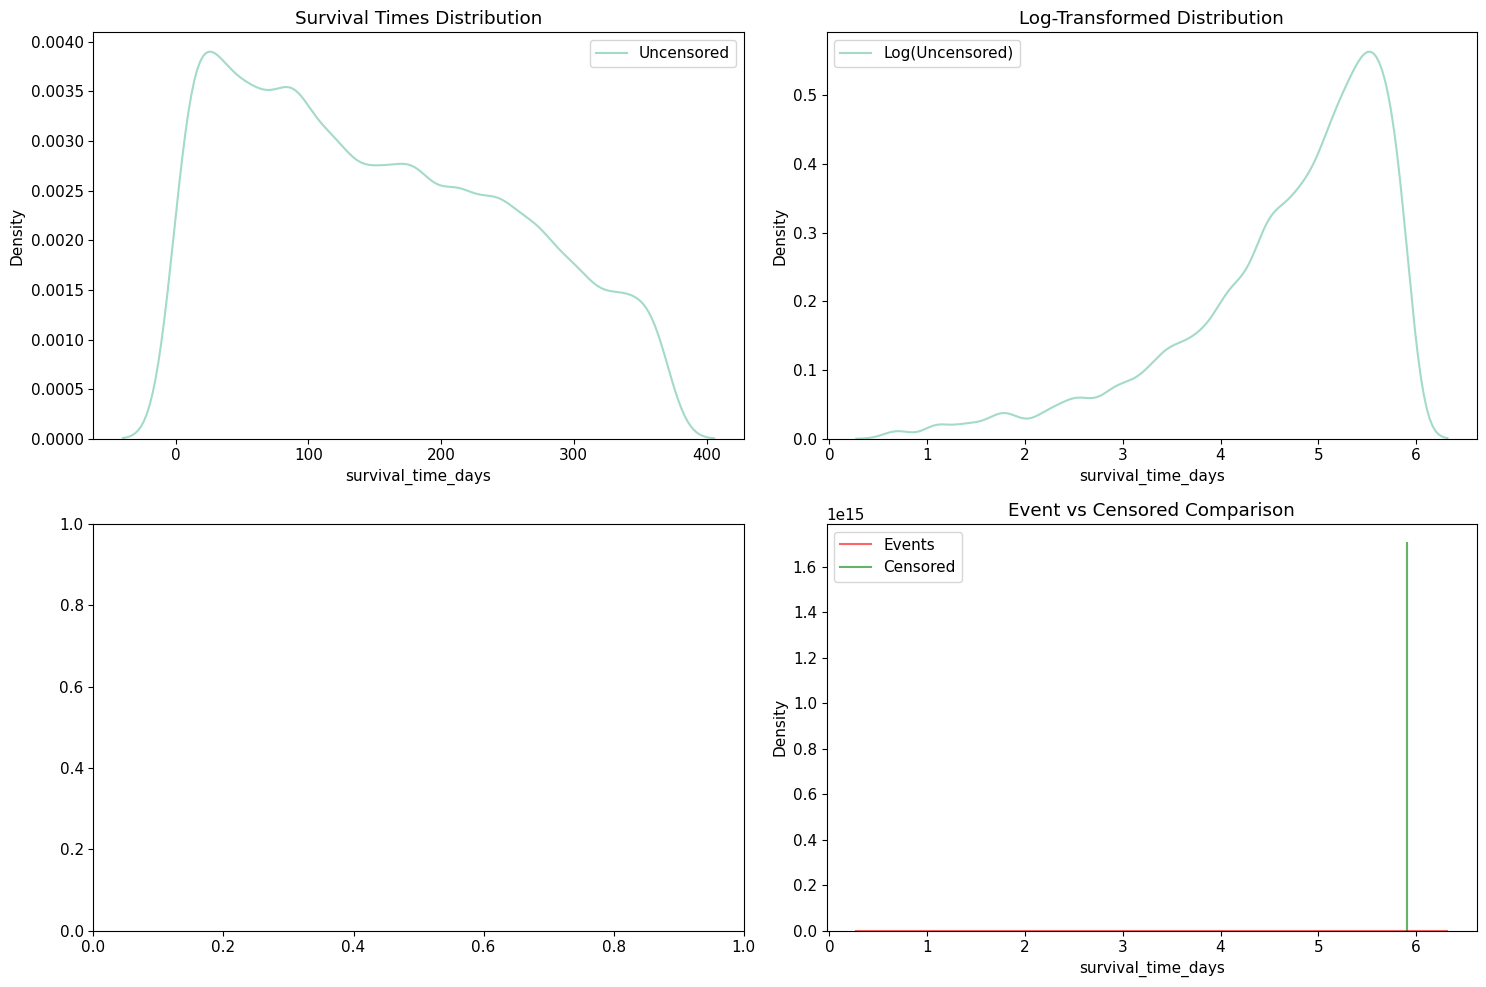

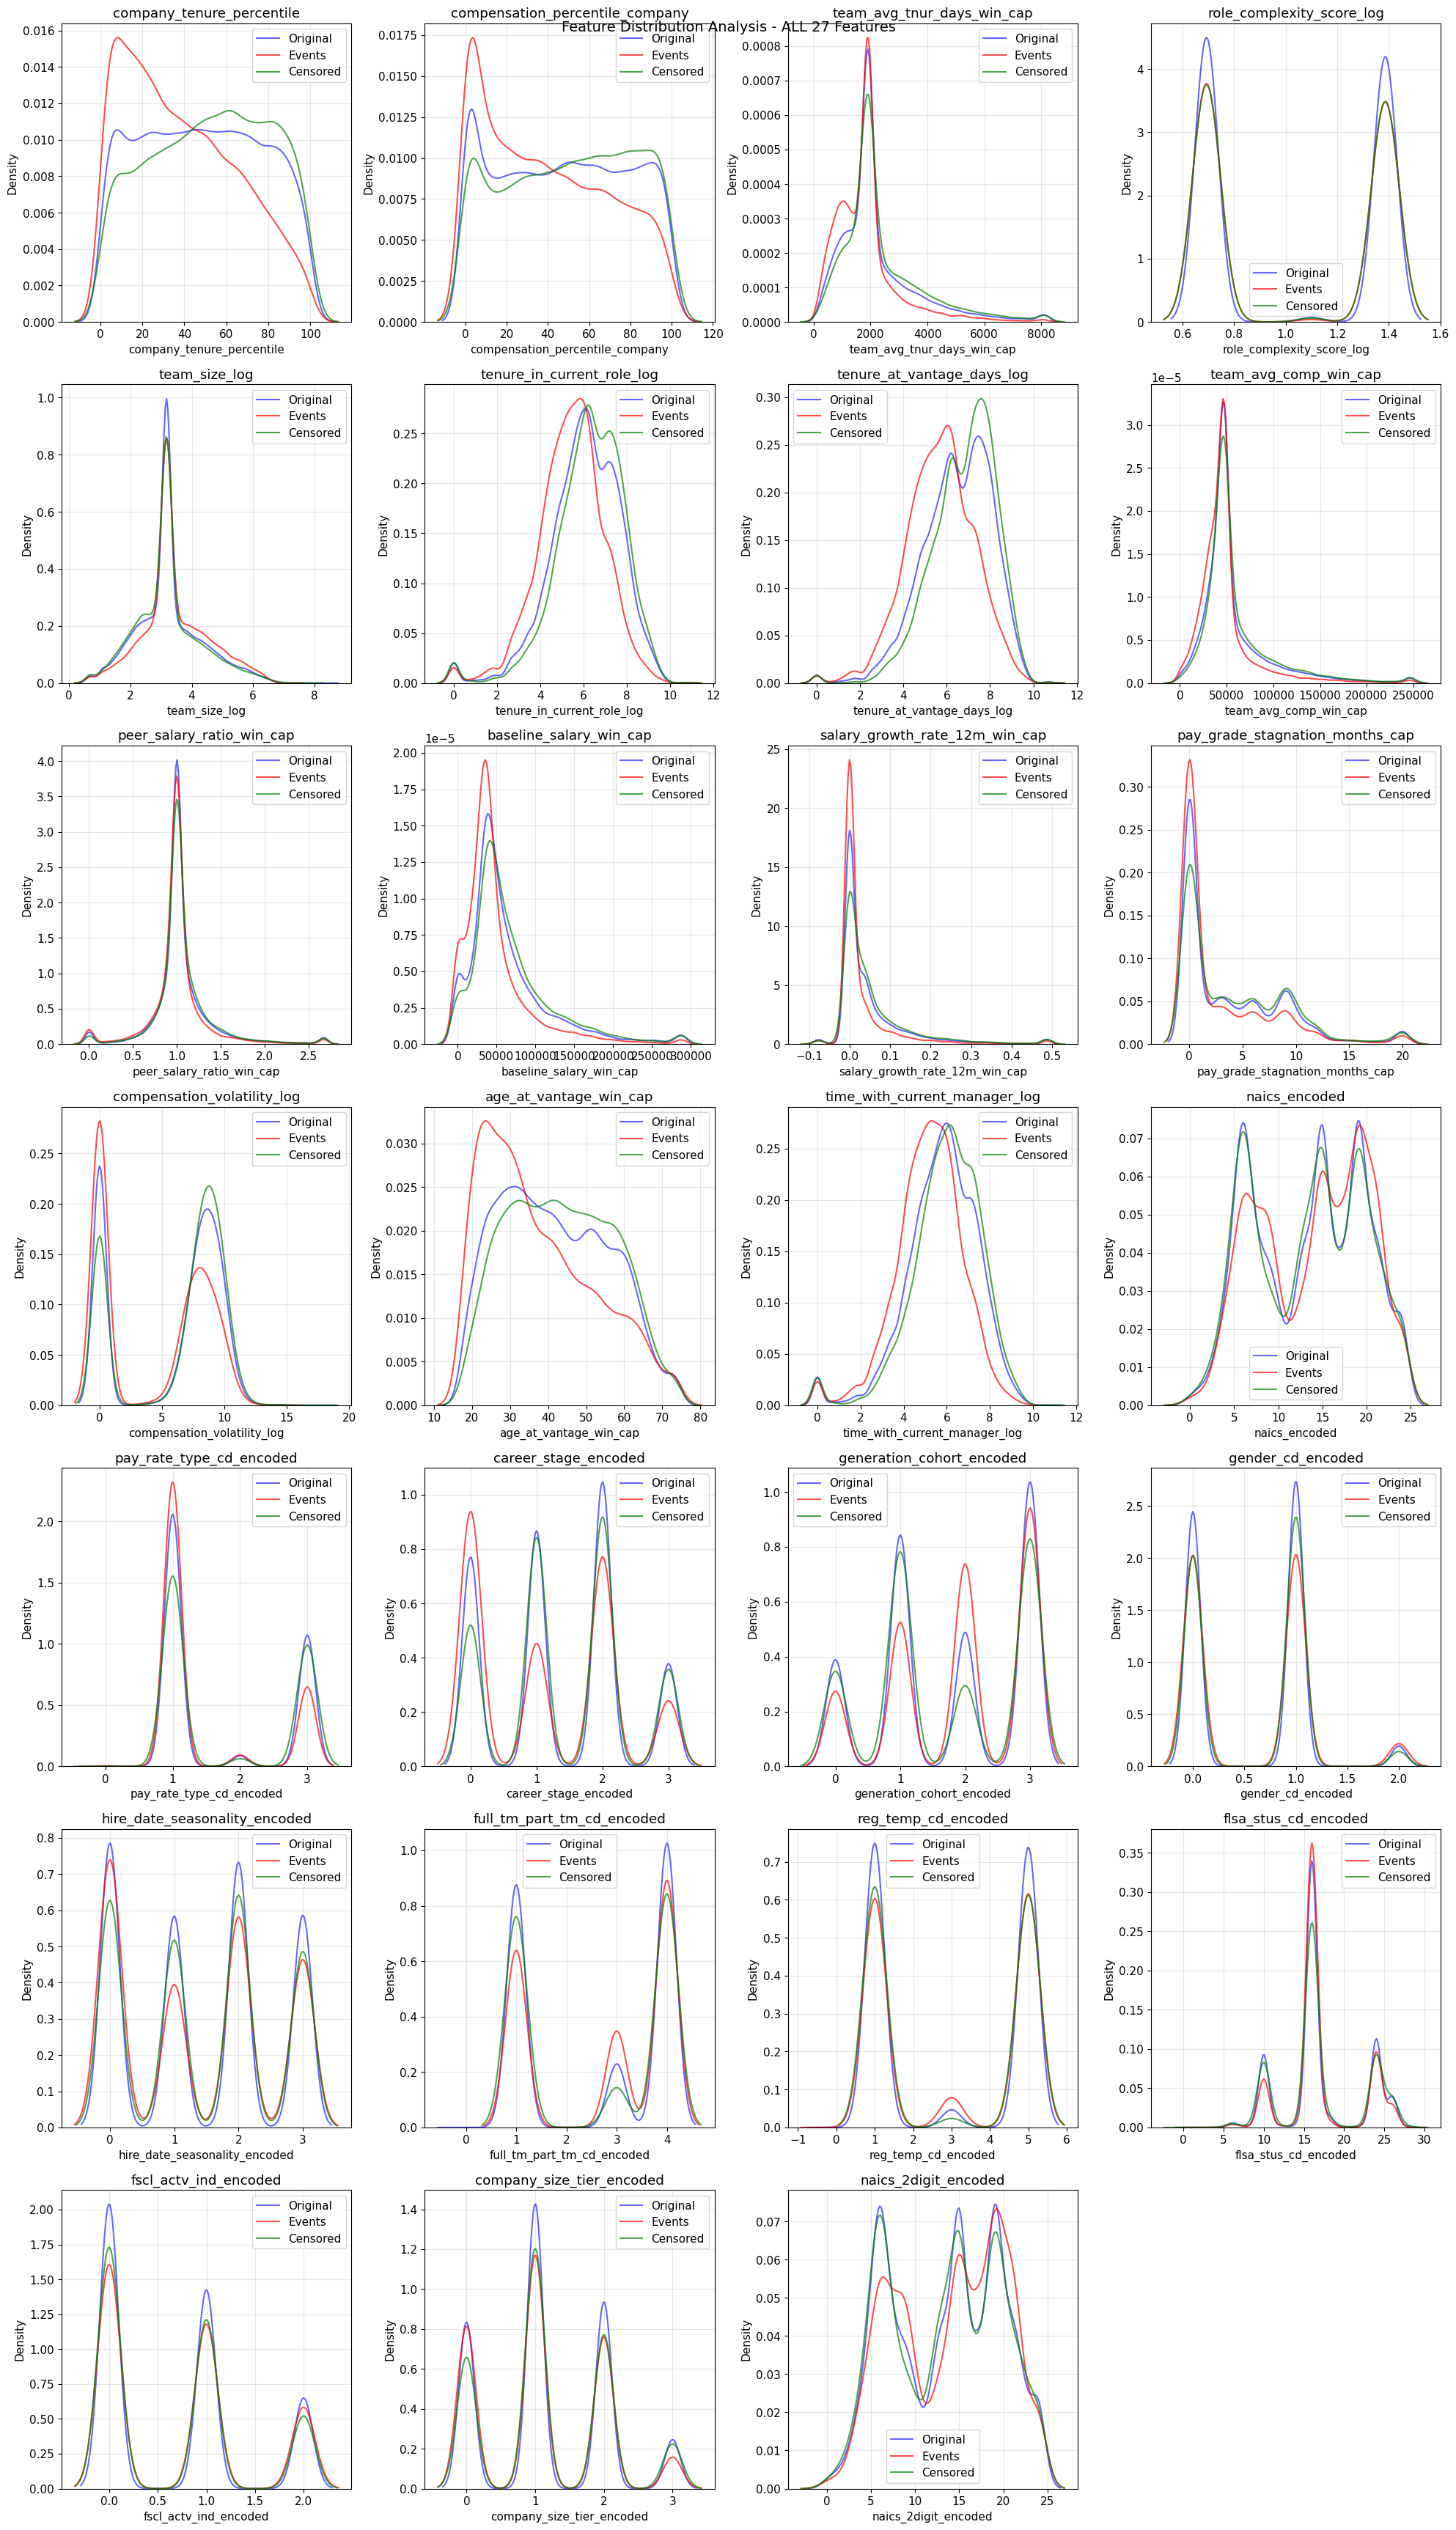


3. Calculating predictions...

4. Analyzing ALL 27 features across bins...

5. Stability analysis across ALL industries...

6. Residual diagnostics...

7. Generating comprehensive report...

COMPREHENSIVE AFT DIAGNOSTICS REPORT

DATASET OVERVIEW:
- Total records: 174,334
- Sample used for tests: 46,651
- Censoring rate: 73.2%

ANALYSIS SCOPE:
- Features analyzed: 27 (ALL features included)
- Industries analyzed: 0 (ALL valid industries)
- Sampling applied: Yes (for performance optimization)

TARGET DISTRIBUTION:
- Recommended AFT distribution: logistic
- Confidence: low
- Normal AFT test: FAIL
- Logistic AFT test: FAIL

PERFORMANCE ANALYSIS:
- Binned analysis completed for ALL 27 features
- Industry stability analysis: 0 industries analyzed
- No artificial limits applied to features or industries

RESIDUAL DIAGNOSTICS:
- Residual analysis completed with sampling optimization
- Memory-efficient chunked processing applied

RECOMMENDATIONS:
1. Use logistic AFT distribution
2. All 27 feat

{'target_distribution': {'target_distribution_tests': {'normal_aft': {'jarque_bera': {'statistic': 3980.0658311402035,
     'p_value': 0.0},
    'interpretation': 'FAIL'},
   'logistic_aft': {'ks_test': {'statistic': 0.12533394479552518,
     'p_value': 2.208739170764267e-137},
    'interpretation': 'FAIL'}},
  'recommended_distribution': {'distribution': 'logistic',
   'confidence': 'low'},
  'sample_size': 46651,
  'censoring_rate': 0.7324044649924857,
  'total_records': 174334},
 'binned_performance': {'company_tenure_percentile': [{'feature': 'company_tenure_percentile',
    'bin': 'Q1',
    'sample_size': 34867,
    'event_rate': 0.40860986032638313,
    'mean_prediction': 16.013691706964707,
    'calibration_error': 15.605081846638324},
   {'feature': 'company_tenure_percentile',
    'bin': 'Q2',
    'sample_size': 34867,
    'event_rate': 0.32681331918432904,
    'mean_prediction': 21.918549801658017,
    'calibration_error': 21.59173648247369},
   {'feature': 'company_tenure_pe

In [0]:
run_full_diagnostics(_df, _model, analyzer.model_data['feature_columns'])

# KDE Plots

In [0]:
def plot_feature_kde_distributions(data, feature_cols, event_col='event_indicator_all', suptitle=None):
    n_features = len(feature_cols)
    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.ravel()

    for idx, feature in enumerate(feature_cols):    
        ax = axes[idx]
        original_data = data[feature].dropna()
        if len(original_data) > 0:
            sns.kdeplot(data=original_data, ax=ax, label='Original', alpha=0.6, color='blue')
        if event_col in data.columns:
            event_data = data[data[event_col] == 1][feature].dropna()
            censored_data = data[data[event_col] == 0][feature].dropna()
            sns.kdeplot(data=event_data, ax=ax, label='Events', color='red', alpha=0.7)
            sns.kdeplot(data=censored_data, ax=ax, label='Censored', color='green', alpha=0.7)
        ax.set_title(f'{feature}')
        ax.legend()
        ax.grid(True, alpha=0.3)

    for idx in range(len(feature_cols), len(axes)):     
        axes[idx].set_visible(False)

    if suptitle is None:
        suptitle = f'Feature Distribution Analysis - ALL {len(feature_cols)} Features'
    plt.suptitle(suptitle, fontsize=14)
    plt.tight_layout()
    plt.show()

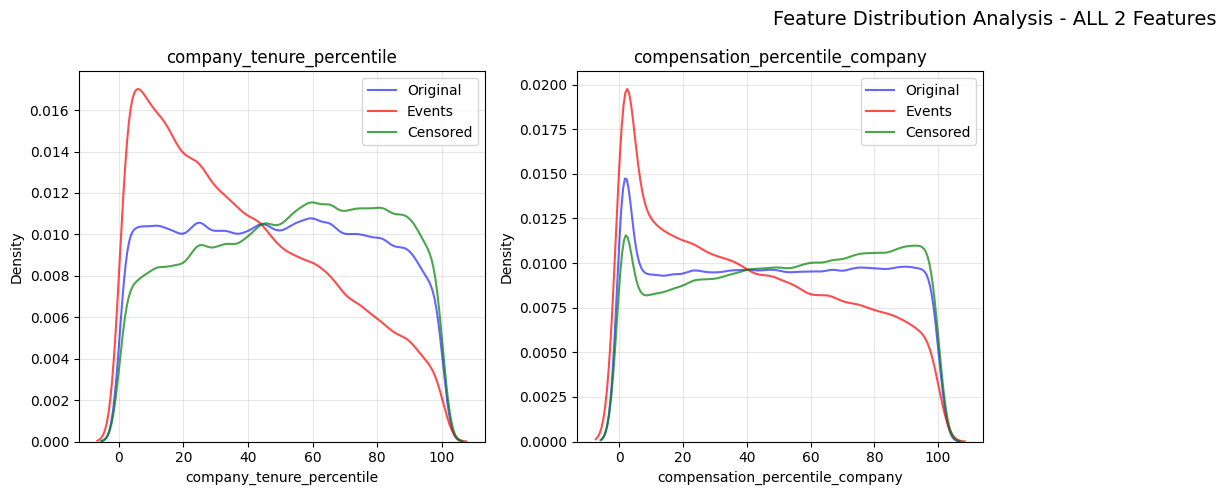

In [0]:
plot_feature_kde_distributions(data,['company_tenure_percentile','compensation_percentile_company'])

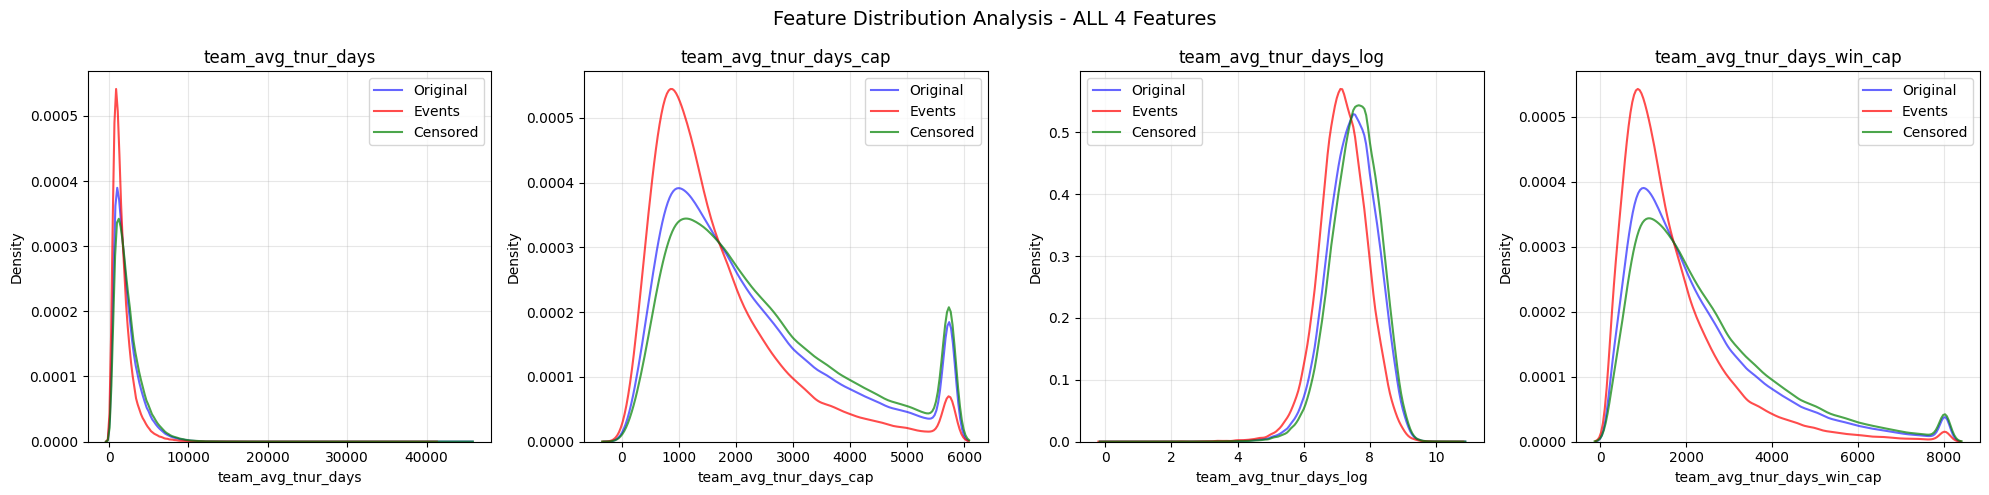

In [0]:
plot_feature_kde_distributions(data,['team_avg_tnur_days','team_avg_tnur_days_cap','team_avg_tnur_days_log','team_avg_tnur_days_win_cap'])

/home/spark-e23d30e3-583c-4b5a-806d-f6/.ipykernel/4519/command-7391689589885647-2634917406:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original_data, ax=ax, label='Original', alpha=0.6, color='blue')
/home/spark-e23d30e3-583c-4b5a-806d-f6/.ipykernel/4519/command-7391689589885647-2634917406:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=event_data, ax=ax, label='Events', color='red', alpha=0.7)
/home/spark-e23d30e3-583c-4b5a-806d-f6/.ipykernel/4519/command-7391689589885647-2634917406:20: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=censored_data, ax=ax, label='Censored', color='green', alpha=0.7)


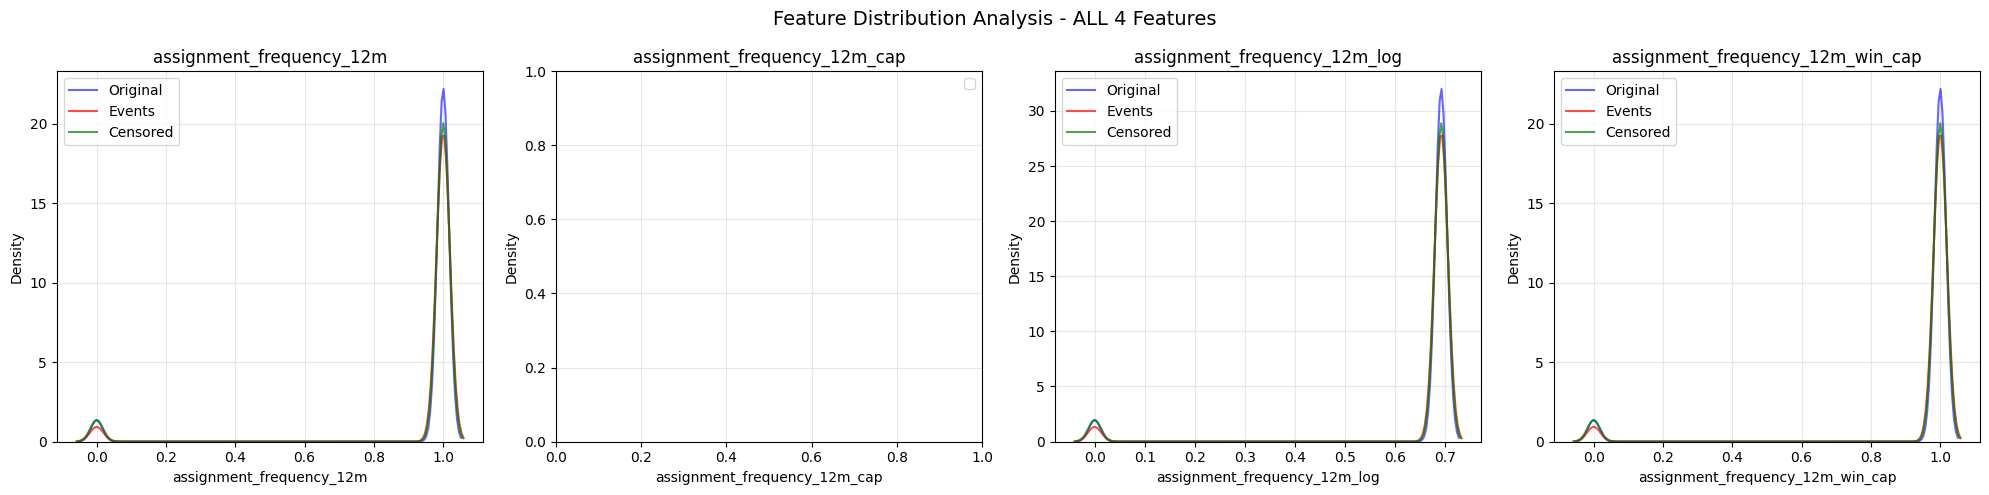

In [0]:
plot_feature_kde_distributions(data,['assignment_frequency_12m','assignment_frequency_12m_cap','assignment_frequency_12m_log','assignment_frequency_12m_win_cap'])

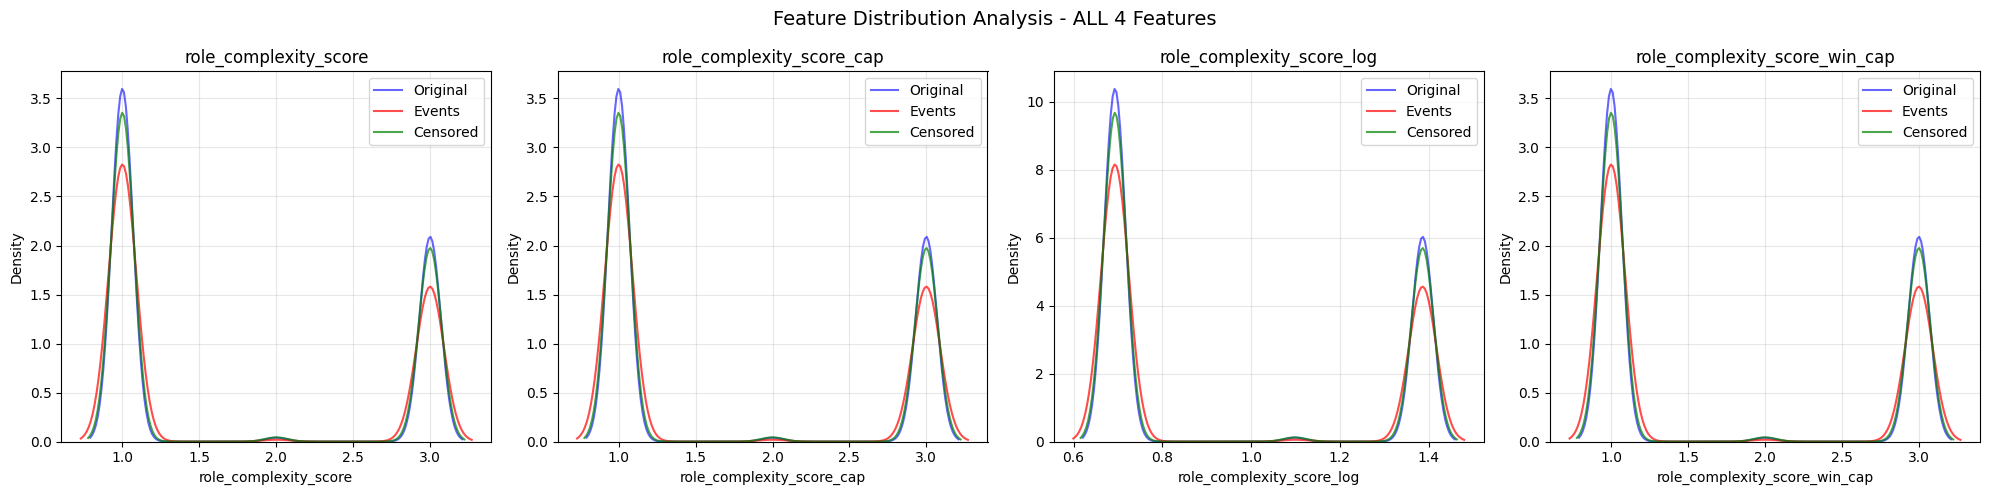

In [0]:
plot_feature_kde_distributions(data,['role_complexity_score','role_complexity_score_cap','role_complexity_score_log','role_complexity_score_win_cap'])

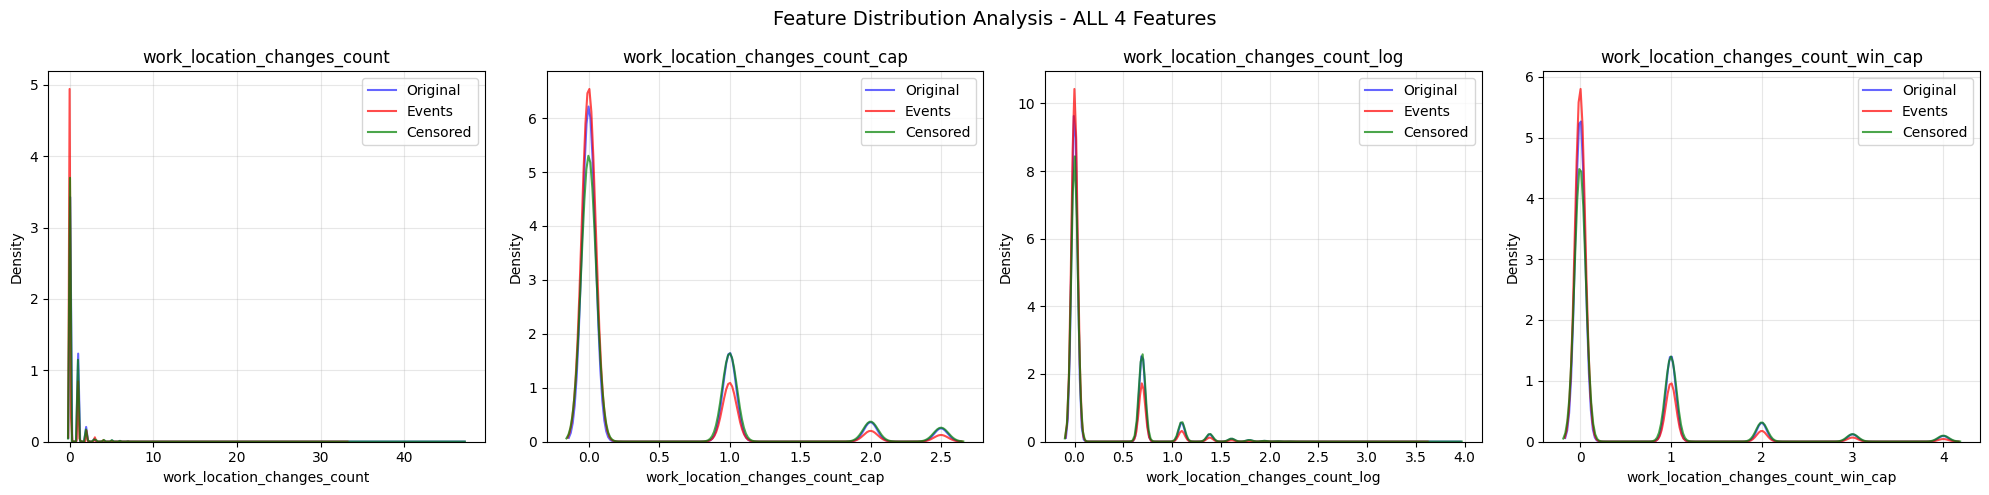

In [0]:
plot_feature_kde_distributions(data,['work_location_changes_count','work_location_changes_count_cap','work_location_changes_count_log','work_location_changes_count_win_cap'])

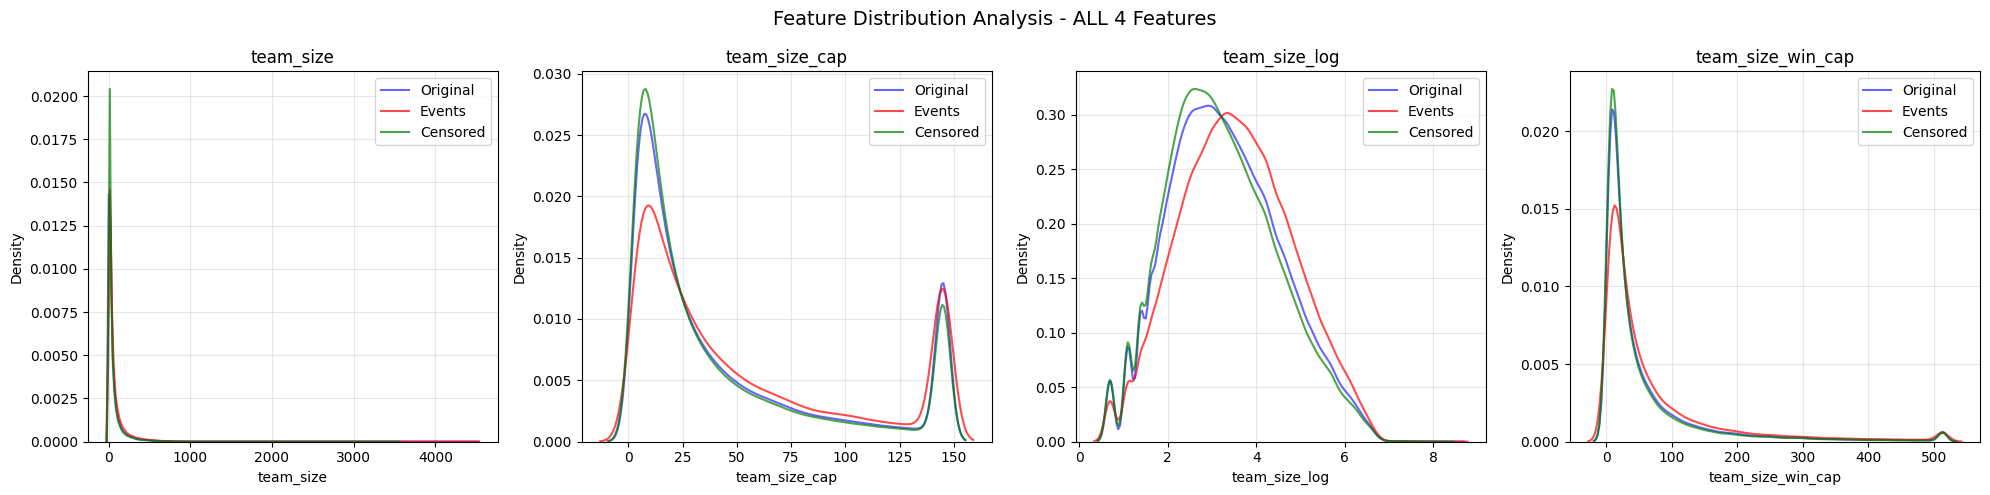

In [0]:
plot_feature_kde_distributions(data,['team_size','team_size_cap','team_size_log','team_size_win_cap'])

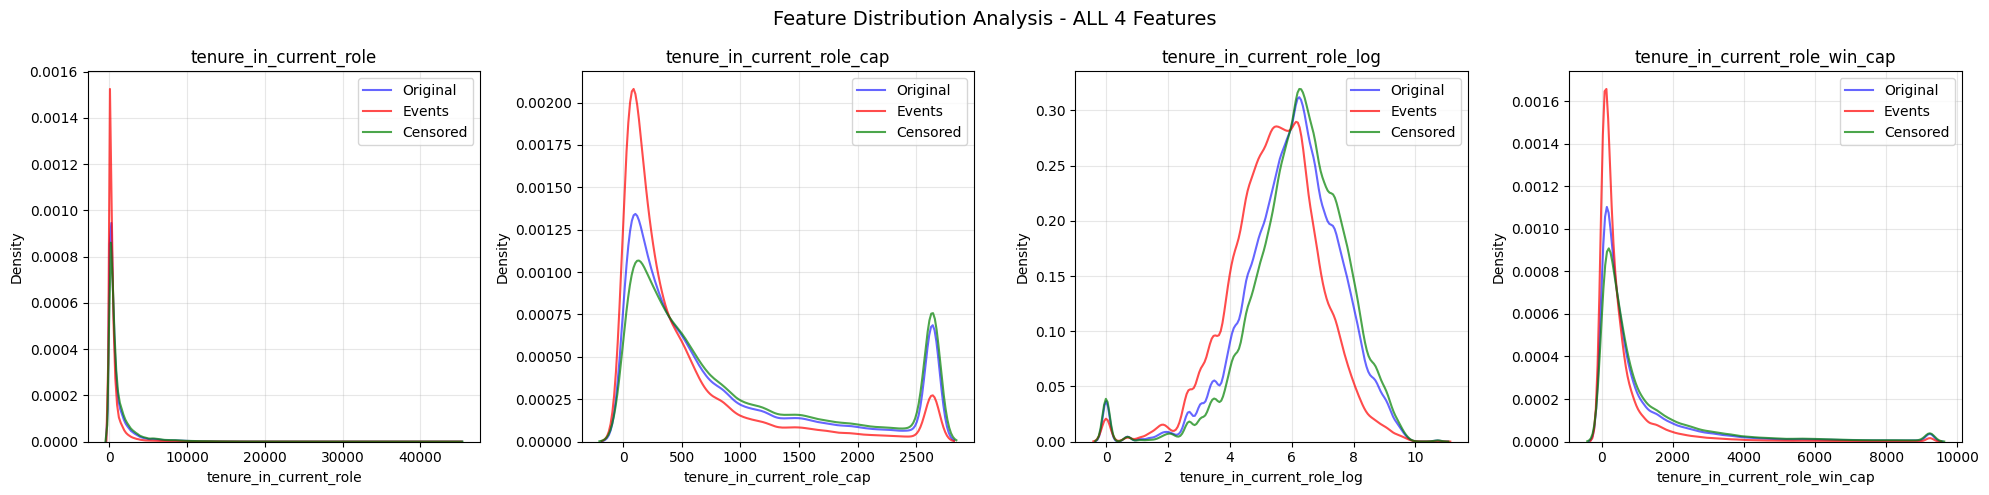

In [0]:
plot_feature_kde_distributions(data,['tenure_in_current_role','tenure_in_current_role_cap','tenure_in_current_role_log','tenure_in_current_role_win_cap'])

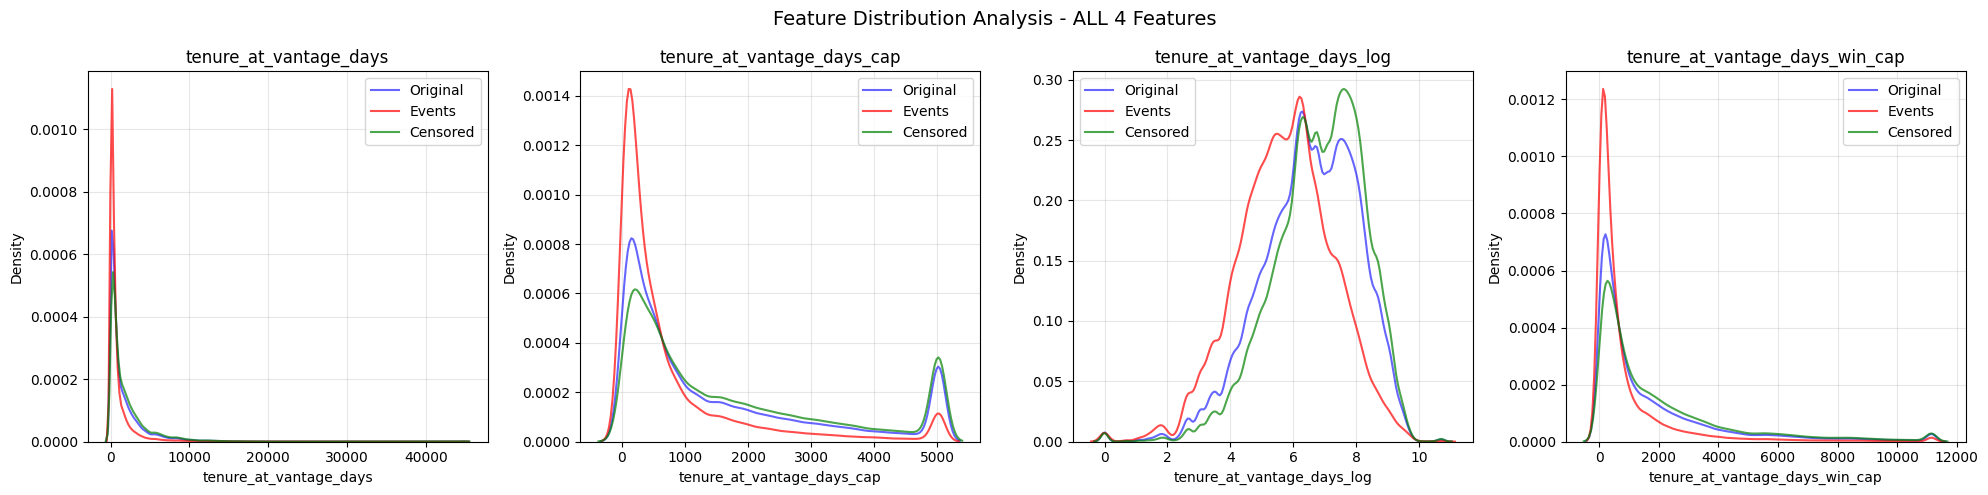

In [0]:
plot_feature_kde_distributions(data,['tenure_at_vantage_days','tenure_at_vantage_days_cap','tenure_at_vantage_days_log','tenure_at_vantage_days_win_cap'])

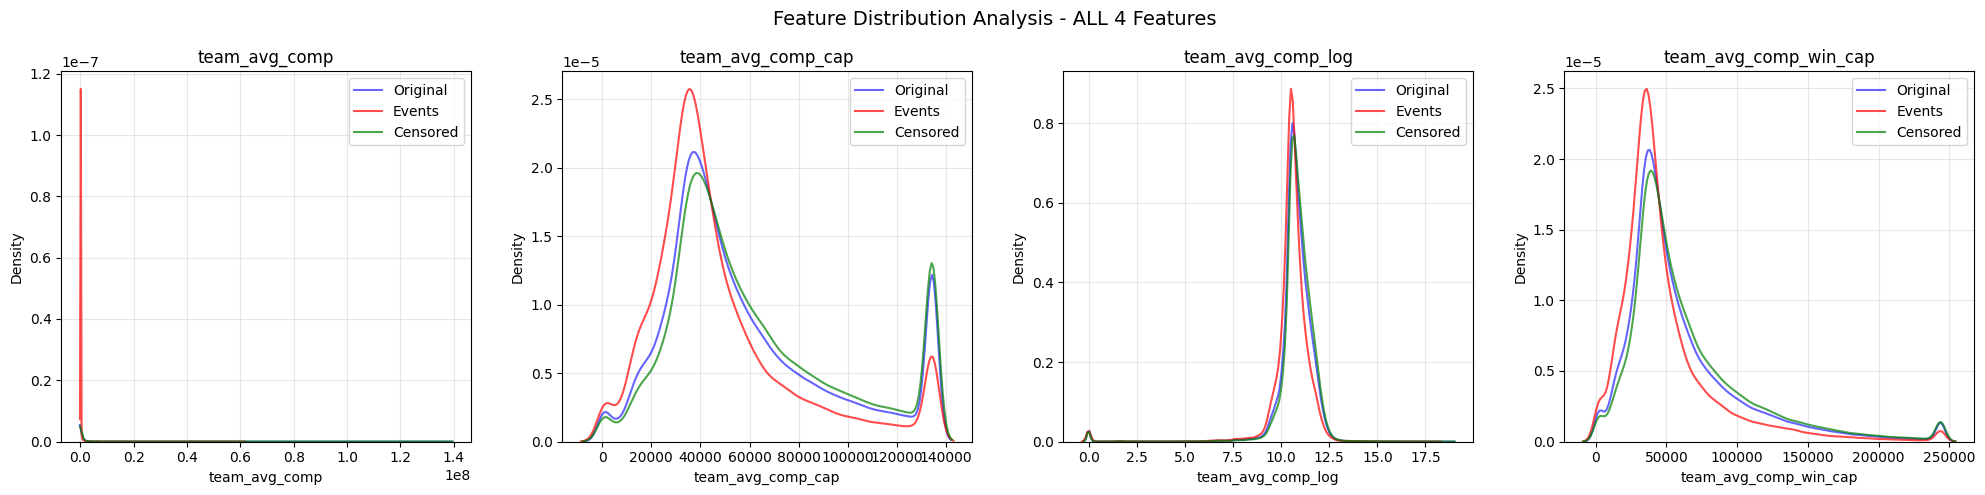

In [0]:
plot_feature_kde_distributions(data,['team_avg_comp','team_avg_comp_cap','team_avg_comp_log','team_avg_comp_win_cap'])

In [0]:
impact=(data[data['team_avg_comp']!=data['team_avg_comp_cap']].shape[0])/data.shape[0]*100
impact

In [0]:
impact=(data[data['team_avg_comp']!=data['team_avg_comp_win_cap']].shape[0])/data.shape[0]*100
impact

In [0]:
plot_feature_kde_distributions(data,['peer_salary_ratio','peer_salary_ratio_cap','peer_salary_ratio_log','peer_salary_ratio_win_cap'])

In [0]:
impact=(data[data['peer_salary_ratio']!=data['peer_salary_ratio_cap']].shape[0])/data.shape[0]*100
impact

In [0]:
plot_feature_kde_distributions(data,['baseline_salary','baseline_salary_cap','baseline_salary_log','baseline_salary_win_cap'])

In [0]:
impact=(data[data['baseline_salary']!=data['baseline_salary_cap']].shape[0])/data.shape[0]*100
impact

In [0]:
impact=(data[data['baseline_salary']!=data['baseline_salary_win_cap']].shape[0])/data.shape[0]*100
impact

In [0]:
plot_feature_kde_distributions(data,['salary_growth_rate_12m','salary_growth_rate_12m_cap','salary_growth_rate_12m_log',             'salary_growth_rate_12m_win_cap'])

In [0]:
impact=(data[data['salary_growth_rate_12m']!=data['salary_growth_rate_12m_cap']].shape[0])/data.shape[0]*100
impact

In [0]:
impact=(data[data['salary_growth_rate_12m']!=data['salary_growth_rate_12m_win_cap']].shape[0])/data.shape[0]*100
impact

In [0]:
plot_feature_kde_distributions(data,['pay_grade_stagnation_months','pay_grade_stagnation_months_cap','pay_grade_stagnation_months_log','pay_grade_stagnation_months_win_cap'])

In [0]:
impact=(data[data['pay_grade_stagnation_months']!=data['pay_grade_stagnation_months_cap']].shape[0])/data.shape[0]*100
impact

In [0]:
plot_feature_kde_distributions(data,['compensation_volatility','compensation_volatility_cap','compensation_volatility_log','compensation_volatility_win_cap'])

In [0]:
impact=(data[data['compensation_volatility']!=data['compensation_volatility_cap']].shape[0])/data.shape[0]*100
impact

In [0]:
plot_feature_kde_distributions(data,['age_at_vantage','age_at_vantage_cap','age_at_vantage_log','age_at_vantage_win_cap'])

In [0]:
impact=(data[data['age_at_vantage']!=data['age_at_vantage_cap']].shape[0])/data.shape[0]*100
impact

In [0]:
impact=(data[data['age_at_vantage']!=data['age_at_vantage_win_cap']].shape[0])/data.shape[0]*100
impact

In [0]:
plot_feature_kde_distributions(data,['time_with_current_manager','time_with_current_manager_cap','time_with_current_manager_log','time_with_current_manager_win_cap'])

In [0]:
impact=(data[data['time_with_current_manager']!=data['time_with_current_manager_cap']].shape[0])/data.shape[0]*100
impact

In [0]:
plot_feature_kde_distributions(data,['time_since_last_promotion','time_since_last_promotion_cap','time_since_last_promotion_log','time_since_last_promotion_win_cap'])